In [1]:
!cat readme.txt

In [ ]:
# https://core.ac.uk/download/pdf/83461632.pdf

# https://www.emerald.com/insight/content/doi/10.1108/JSIT-10-2016-0061/full/pdf?casa_token=P8yIBuV70x4AAAAA:4rCEvt-IJa6g12I3JydKrI-RIP2sASgZYCBQdF7h49B3bWFlmtoLefn5cYIhmroh_6KIxUkWRTvm7R5PWPrf5sG11eNb4EzcstM7g0fjbcKh1kGFnGHk

In [364]:
import numpy as np 
import pandas as pd
import pyarrow
import sys

from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import tqdm

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

from collections import Counter

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import precision_recall_curve


In [ ]:
from utils import diff_to_days _get_features

In [212]:
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
!pip freeze > requirements.txt
!mkdir results

mkdir: cannot create directory ‘results’: File exists


# 1) Анализ данных (EDA)

In [3]:
# Что лежит в папке
!ls -Slhr

total 1.3G
drwxr-xr-x 3 root root  150 Jan 16 00:29  results
-rw-r--r-- 1 root root 1.7K Jan 17 14:32  requirements.txt
-rw-r--r-- 1 root root 1.9K Jan  7 20:29  readme.txt
-rw-r--r-- 1 root root  10K Dec 28 05:46 'data description.xlsx'
-rw-r--r-- 1 root root  17K Sep 18 13:38  plants.csv
-rw-r--r-- 1 root root  56K Jan 17 14:52  df_stat.csv
-rw-r--r-- 1 root root 327K Jan 16 04:06  lenta.ipynb
-rw-r--r-- 1 root root 3.5M Jan 17 17:04  lenta2-Copy1.ipynb
-rw-r--r-- 1 root root 3.5M Jan 17 17:15  lenta2.ipynb
-rw-r--r-- 1 root root 4.7M Sep 18 13:40  clients.csv
-rw-r--r-- 1 root root  18M Sep 18 13:38  materials.csv
-rw-r--r-- 1 root root 1.2G Dec 28 13:42  transactions.parquet


In [4]:
%%time
filepath = 'transactions.parquet'
df = pd.read_parquet(filepath, engine='pyarrow')
print("df.shape", df.shape)
df.head()

df.shape (32109414, 9)
CPU times: user 19.6 s, sys: 9.56 s, total: 29.2 s
Wall time: 15.9 s


chq_id                             plant  \
0  ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
1  ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
2  ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
3  ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
4  ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   

    chq_date chq_position                         client_id  \
0 2016-11-01          004  90fca68123e692a005a4edeadd94b2f2   
1 2016-11-01          003  90fca68123e692a005a4edeadd94b2f2   
2 2016-11-01          012  90fca68123e692a005a4edeadd94b2f2   
3 2016-11-01          013  90fca68123e692a005a4edeadd94b2f2   
4 2016-11-01          011  90fca68123e692a005a4edeadd94b2f2   

                           material  sales_count  sales_sum  is_promo  
0  232cfe8b28970434f685b737737b26d4          2.0     146.98         0  
1  12ec64451b8e426db16f3f05ea770901          1.0     249.99         1  
2  1212ff8ecf53aebef093ca8ae216db68          1.0      47.99         1  
3  1212ff8ecf53aebef093ca8ae216db68          1.0      47.99         1  
4  571c6d3b559db8445e05265649eb30ab          2.0      53.98         1

In [5]:
# Сколько уникальных элементов, что за тип
for key in df.keys():
    print(f"{key} {' '*(20-len(key))}  {df[key].nunique()} \t {df[key].dtype}")

chq_id                 2964775 	 object
plant                  388 	 object
chq_date               366 	 datetime64[ns]
chq_position           459 	 object
client_id              100000 	 object
material               105694 	 object
sales_count            9359 	 float64
sales_sum              173839 	 float64
is_promo               2 	 int64


In [6]:
# Посмотрим на один id-шник транзакции
df[df['chq_id'] == 'ce5b3d1c531348c5d0d8e859b6d0cf91'].sort_values('chq_position')

chq_id                             plant  \
5   ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
11  ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
1   ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
0   ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
9   ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
6   ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
8   ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
10  ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
12  ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
7   ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
4   ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
2   ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   
3   ce5b3d1c531348c5d0d8e859b6d0cf91  7cd86ecb09aa48c6e620b340f6a74592   

     chq_date chq_position                         client_id  \
5  2016-11-01          001  90fca68123e692a005a4edeadd94b2f2   
11 2016-11-01          002  90fca68123e692a005a4edeadd94b2f2   
1  2016-11-01          003  90fca68123e692a005a4edeadd94b2f2   
0  2016-11-01          004  90fca68123e692a005a4edeadd94b2f2   
9  2016-11-01          005  90fca68123e692a005a4edeadd94b2f2   
6  2016-11-01          006  90fca68123e692a005a4edeadd94b2f2   
8  2016-11-01          007  90fca68123e692a005a4edeadd94b2f2   
10 2016-11-01          008  90fca68123e692a005a4edeadd94b2f2   
12 2016-11-01          009  90fca68123e692a005a4edeadd94b2f2   
7  2016-11-01          010  90fca68123e692a005a4edeadd94b2f2   
4  2016-11-01          011  90fca68123e692a005a4edeadd94b2f2   
2  2016-11-01          012  90fca68123e692a005a4edeadd94b2f2   
3  2016-11-01          013  90fca68123e692a005a4edeadd94b2f2   

                            material  sales_count  sales_sum  is_promo  
5   76608b1b1d38384fcac3e2b14e6ec0c9        2.000      64.78         1  
11  ada84ea081d5d3c919dc12a5bdde904e        1.000     179.99         1  
1   12ec64451b8e426db16f3f05ea770901        1.000     249.99         1  
0   232cfe8b28970434f685b737737b26d4        2.000     146.98         0  
9   b726b2ec8d0643d38e29d96733153dd4        2.000      51.98         1  
6   86069eddeab2b94b00eca5801628c879        0.728      65.51         0  
8   f6f07df28266b03cb7822b62abf0a385        2.000      72.99         1  
10  33fa1fd7d0c11ccde404416d63e9b50a        1.000     549.94         1  
12  e09bae8a6aa3492347bef47d9913344a        1.000      64.89         0  
7   cd8645ab842a98332560a07d137aed24        1.000      36.99         1  
4   571c6d3b559db8445e05265649eb30ab        2.000      53.98         1  
2   1212ff8ecf53aebef093ca8ae216db68        1.000      47.99         1  
3   1212ff8ecf53aebef093ca8ae216db68        1.000      47.99         1

In [7]:
# Одной транзакции соответствует только одна дата?
# > Да
df.groupby('chq_id')['chq_date'].nunique().sort_values()

chq_id
00000391443926003b45cebac9a4c0b2    1
aa9396b8fb0c77d0b3212a11c6c001d0    1
aa93a13cc6647f4a4040778ea2518e87    1
aa93a620266697563a6f5d49bcf84d21    1
aa93abce2f67950a13c8eb049962ae5e    1
                                   ..
55578139ad4d993942819014035f8c13    1
5557935b6247e2ffbdd80c311179ece9    1
555793833019971b3b6ecd3a40a046bb    1
5557bd59e8afe67d52fd84c6b75a237a    1
fffff22a5bb4ef42a166e2e20cff0d14    1
Name: chq_date, Length: 2964775, dtype: int64

Text(0, 0.5, 'Number of transactions')

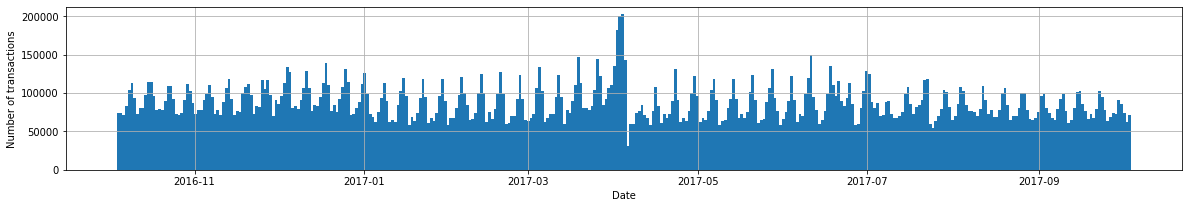

In [8]:
# Нарисуем распределение транзакция по времени
df['chq_date'].hist(figsize = (20, 3), bins = df['chq_date'].nunique())
plt.xlabel('Date')
plt.ylabel('Number of transactions')

### Посмотрим на две другие таблицы и добавим некоторые поля оттуда

#### df_materials

In [199]:
df_materials = pd.read_csv('materials.csv')
print(df_materials.nunique())
    
df_materials.head()

material            105609
hier_level_1             2
hier_level_2            60
hier_level_3           391
hier_level_4          2006
vendor                4185
is_private_label         2
is_alco                  2
dtype: int64


material hier_level_1  \
0  35cbdf61de9e19c8b417327aaef14c88      NONFOOD   
1  c0b0bf24d4ec71da3d304f761ec555d8      NONFOOD   
2  f0fc5e654a81a7c4b8ba8d7c26546e14      NONFOOD   
3  353693e64fb5f9e2d29746d7fe6edf1e      NONFOOD   
4  5d9e0b4302ce95448cae72165ff4cf5b      NONFOOD   

                       hier_level_2                      hier_level_3  \
0  ea5d2f1c4608232e07d3aa3d998e5135  99cad265a1768cc2dd013f0e740300ae   
1  ea5d2f1c4608232e07d3aa3d998e5135  99cad265a1768cc2dd013f0e740300ae   
2  ea5d2f1c4608232e07d3aa3d998e5135  99cad265a1768cc2dd013f0e740300ae   
3  ea5d2f1c4608232e07d3aa3d998e5135  b58f7d184743106a8a66028b7a28937c   
4  ea5d2f1c4608232e07d3aa3d998e5135  b58f7d184743106a8a66028b7a28937c   

                       hier_level_4                            vendor  \
0  9eed45f71360b4b1e2590637467220e5  212a38db0ddcd009f1e164cc8483485c   
1  de2eb747e0896c050905a6b635ab800a  9b0b6c7d55413ad3b67761b7b125b534   
2  8a969031832c535daf96e0c2aed8e814  9b0b6c7d55413ad3b67761b7b125b534   
3  4c0dc012ebb679a18b244c53c6f59b5a  a3c8be149d718771e892619bd310b961   
4  4c0dc012ebb679a18b244c53c6f59b5a  a3c8be149d718771e892619bd310b961   

   is_private_label  is_alco  
0                 0        0  
1                 0        0  
2                 0        0  
3                 0        0  
4                 0        0

In [203]:
o = df_materials.set_index('material')
for key in ['hier_level_1', 'is_private_label', 'is_alco']:
    dct = o[key].to_dict()
    df[f'material__{key}'] = df['material'].map(dct)
    
df['material__is_food'] = (df['material__hier_level_1']=='FOOD').astype(int)
del df['material__hier_level_1']

In [204]:
df.keys()

Index(['chq_id', 'plant', 'chq_date', 'chq_position', 'client_id', 'material',
       'sales_count', 'sales_sum', 'is_promo', 'chq_id_sum_sales_count',
       'chq_id_len', 'chq_id_sum_sales_sum', 'chq_date(month)',
       'material__is_private_label', 'material__is_alco', 'material__is_food'],
      dtype='object')

#### df_plants

In [205]:
df_plants = pd.read_csv('plants.csv')
print(df_plants.nunique())
print("HM", df_plants['plant_type'].unique())
print("city", df_plants['city'].unique())
df_plants.head()


plant         388
plant_type      2
city            3
dtype: int64
HM ['HM' 'SM']
city ['St. Petersburg' 'Other' 'Moscow']


plant plant_type            city
0  95b09698fda1f64af16708ffb859eab9         HM  St. Petersburg
1  926abae84a4bd33c834bc6b981b8cf30         HM  St. Petersburg
2  ae2bac2e4b4da805d01b2952d7e35ba4         HM  St. Petersburg
3  0e7e3cf0ded4d9db8b376b317c007f99         HM  St. Petersburg
4  540bd55a2cf295b8ea9cd78650e89d03         HM  St. Petersburg

In [206]:
o = df_plants.set_index('plant')

dct = (o["plant_type"]=='SM').astype(int).to_dict()
df[f'plant__is_SM'] = df['plant'].map(dct)

for city in  ['St. Petersburg', 'Other', 'Moscow']:
    dct = (o["city"]==f'{city}').astype(int).to_dict()
    df[f'plant__is_city_{city}'] = df['plant'].map(dct)

In [207]:
df.keys()

Index(['chq_id', 'plant', 'chq_date', 'chq_position', 'client_id', 'material',
       'sales_count', 'sales_sum', 'is_promo', 'chq_id_sum_sales_count',
       'chq_id_len', 'chq_id_sum_sales_sum', 'chq_date(month)',
       'material__is_private_label', 'material__is_alco', 'material__is_food',
       'plant__is_SM', 'plant__is_city_St. Petersburg', 'plant__is_city_Other',
       'plant__is_city_Moscow'],
      dtype='object')

### Добавим колоноки - агрегаты по транзакции

In [210]:
%%time

# Колонка количество товаров в транзакции (с учетом дубликатов)
dct = df.groupby('chq_id')['sales_count'].sum().to_dict()
df['chq_id_sum_sales_count'] = df['chq_id'].apply(lambda x:dct[x])

# Колонка количество товаров в транзакции (без учетом дубликатов)
dct = df.groupby('chq_id').apply(len).to_dict()
df['chq_id_len'] = df['chq_id'].apply(lambda x:dct[x])

# Сумма sales_sum товров в транзакции
dct = df.groupby('chq_id')['sales_sum'].sum().to_dict()
df['chq_id_sum_sales_sum'] = df['chq_id'].apply(lambda x:dct[x])

# Количество еды, алкоголя, is_private_label товров в транзакции
for key in ['material__is_private_label', 'material__is_alco', 'material__is_food']:
    dct = df.groupby('chq_id')[key].mean().to_dict()
    df[f'chq_id_{key}'] = df['chq_id'].apply(lambda x:dct[x])

CPU times: user 1min 43s, sys: 4.96 s, total: 1min 48s
Wall time: 1min 47s


### Добавим колоноки - агрегаты по времени (так можно будет отрисовать графики и что-то понять)

In [140]:
%%time
# Создаем различные варианты агрегаций времени

# Месяц
df['chq_date(month)']       = pd.to_datetime(df['chq_date'].dt.strftime('%Y.%m'))

# Неделя
df['chq_date(week)']        = df['chq_date'].apply(lambda dt: dt - timedelta(days=dt.weekday()))

# День недели
day_of_week_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['chq_date[day_of_week]'] = df['chq_date'].dt.dayofweek#.apply(lambda x:day_of_week_list[x])

In [13]:
# Данные идут всегда через день?
# > Да, равномерно через день
set(np.diff(sorted(df["chq_date"].unique())))

{numpy.timedelta64(86400000000000,'ns')}

### Графики зависимости от времени

In [14]:
%%time
#### Построем всякие различные графики по времени
# построим таблицу, проиндексированную по датам, сохранив ее
# len - число строк для данной даты в исх. таблице
# user_unique - число уникальных клиентов в день
# transaction_unique - число уникальнных транзакций в день
# sales_sum - за день продано на такую сумму
# sales_count - число проданных товаров
# average_sum - средняя сумма транзы в день
# material - число уникальных товаров, которые были проданы в этот день
# is_promo_sum - суммарное число проданных промо товаров в день
# is_promo_per_trans - среднее число проданных по промо товаров на транзакцию в этот день
# is_promo_sales_sum_sum - общая стоимость проданных по промо товаров
# is_promo_sales_sum_mean - общая сумма купленного по промо по отношению к общей сумме проданного в день
#unique_plant - число магазинов, в которых что-то было продано в этот день

def get_time_features(data):
    res = {'len' : len(data),
           'user_unique': data['client_id'].nunique(),
           'transaction_unique':data['chq_id'].nunique(),
           'sales_sum':data['sales_sum'].sum(),
           'sales_count':data['sales_count'].sum(),
           'average_sum':data['sales_sum'].mean(),
           'material':data['material'].nunique(),
           'is_promo_sum':data['is_promo'].sum(),
           'is_promo_per_trans':data['is_promo'].mean(),
           'is_promo_sales_sum_sum':data.loc[data['is_promo']==1, 'sales_sum'].sum(),
           'is_promo_sales_sum_mean':data.loc[data['is_promo']==1, 'sales_sum'].sum()/data['sales_sum'].sum(),
           'unique_plant':data['plant'].nunique()
          }
    return pd.Series(res)

df_stat = df.groupby('chq_date').apply(get_time_features)
df_stat.to_csv(r'df_stat.csv')

CPU times: user 35.1 s, sys: 3.06 s, total: 38.2 s
Wall time: 38.2 s


#### По дням

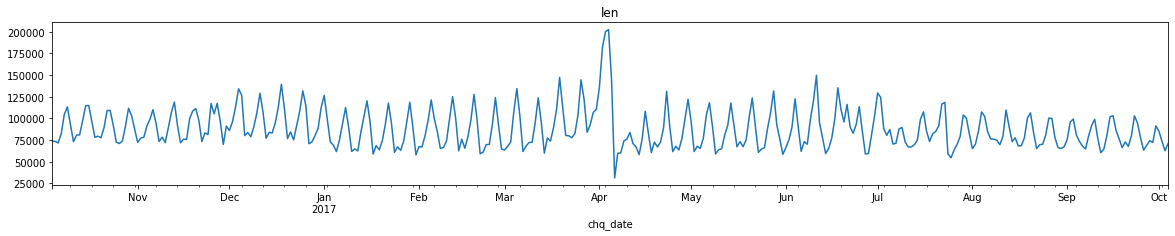

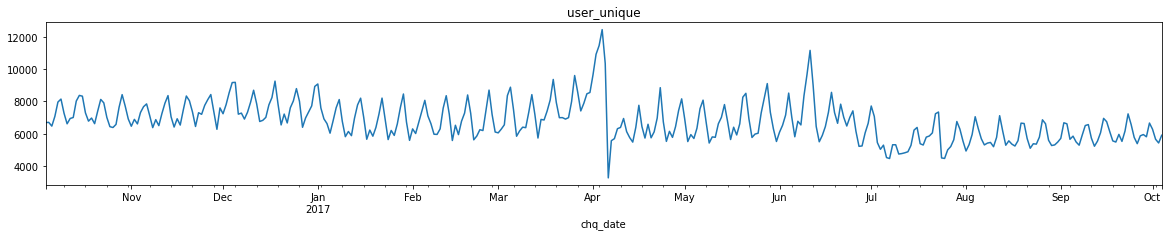

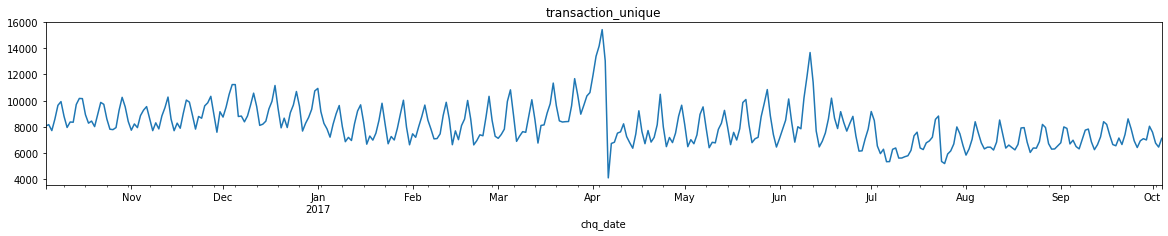

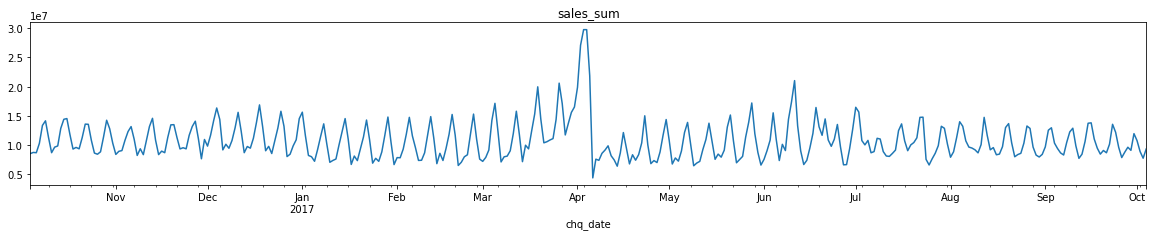

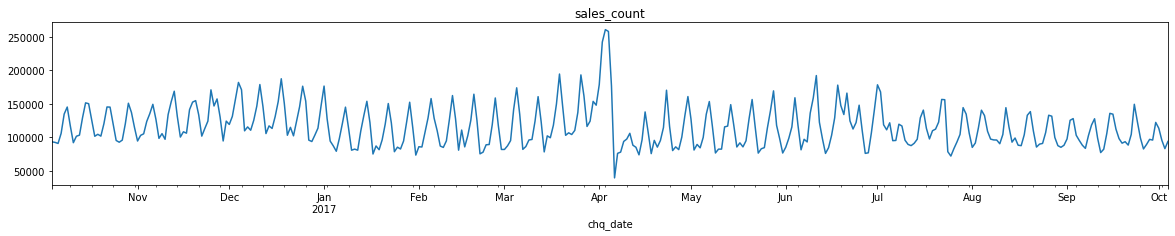

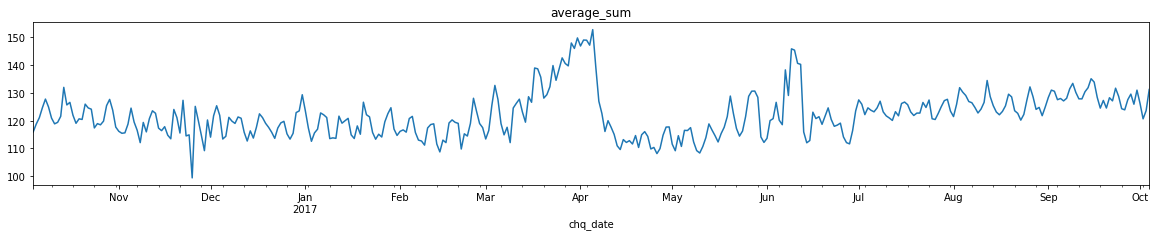

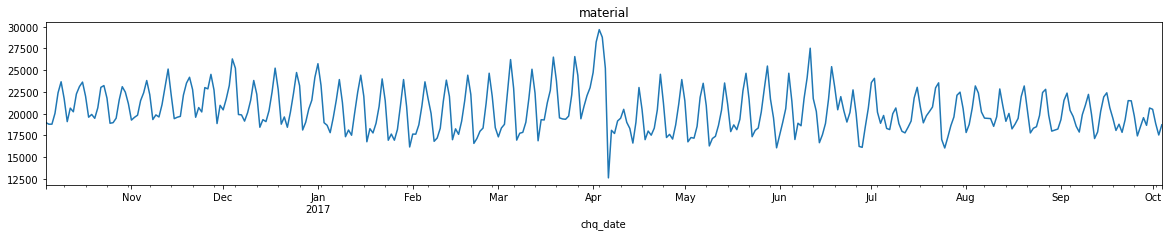

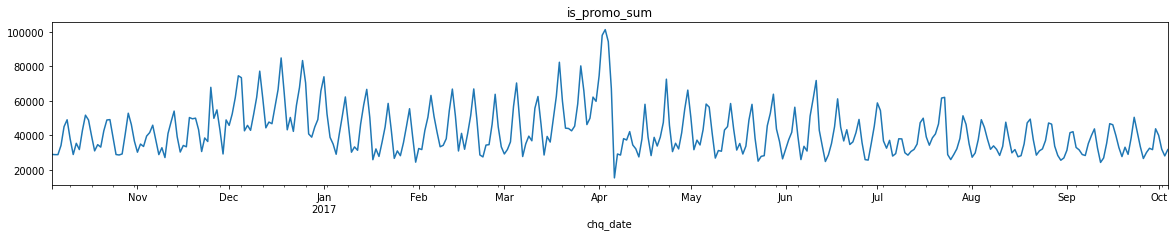

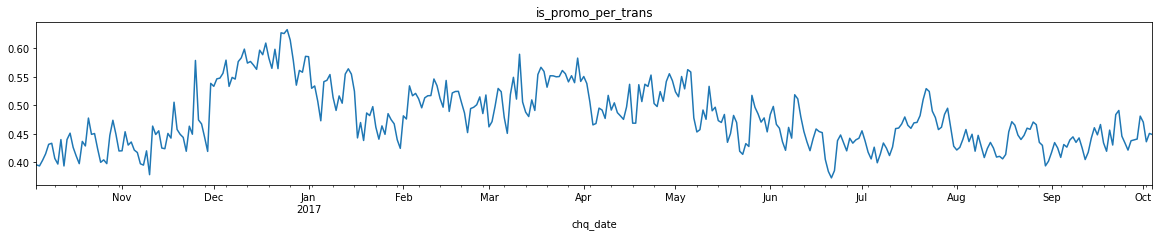

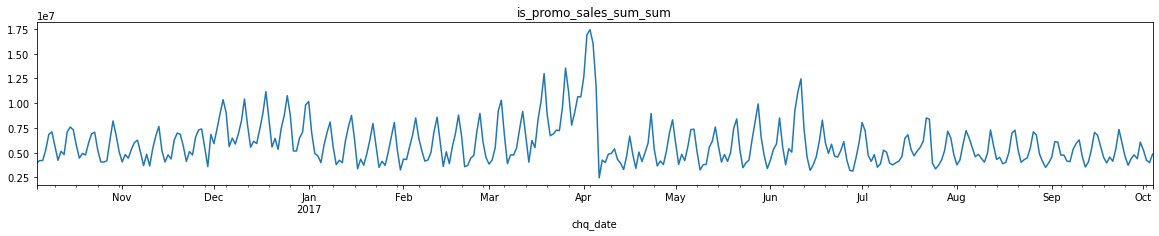

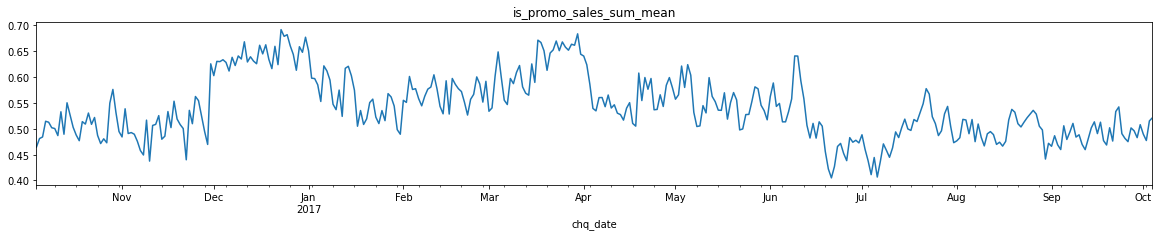

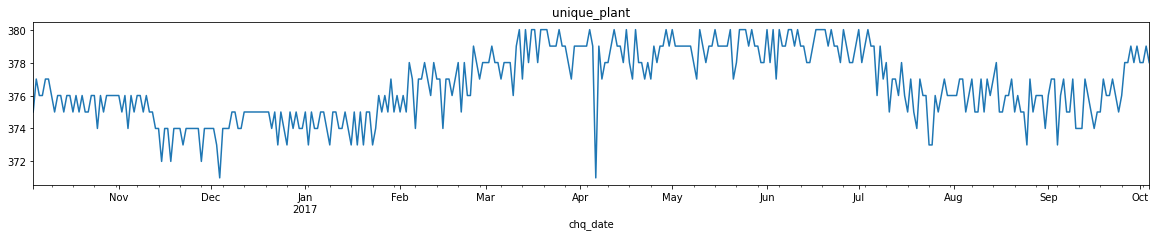

In [15]:
## Подневно
for key in df_stat.keys():
    df_stat[key].plot(figsize = (20, 3), title = key)
    #df_stat[key][-140-7*12:-112-7*12].reset_index(drop=True).plot(figsize = (20, 3), title = key)


    plt.show()
    
# есть сильная зависимость по дням
# по выходным на 50-70% лучше чем на неделе

# сезонной ззависимости мало

# есть небольшой общий тренд на понижение

# в апреле что-то случилось

In [16]:
#возле апреля интересно поведени графика average sum - средняя сумма транзакции росла в теч. месяца до странного события
#это могло бы объяснить некоторые графики, но не уникальное число покупателей в день - user_unique
#т.е. ближе к апрелю росло число покупателей И их средний чек
#конец какой-то скидочной программы? если и так, то это не промо-товары из таблицы: доля промо товаров в чеке и доля промо в проданном 
#не росли, подходя к рассматриваемой точке
#возможно, другая бонусная программа

#### По месяцам

Графики по месяцам


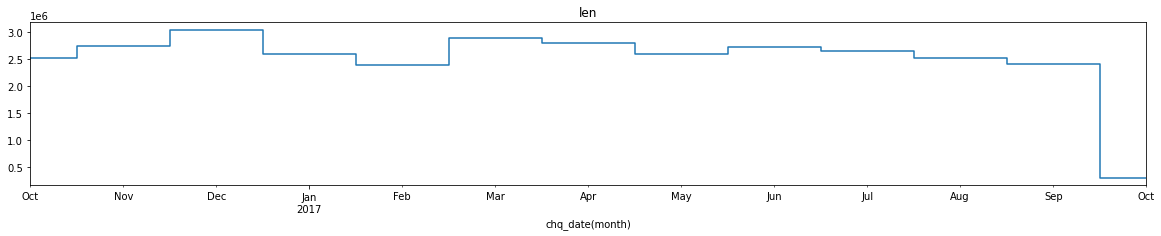

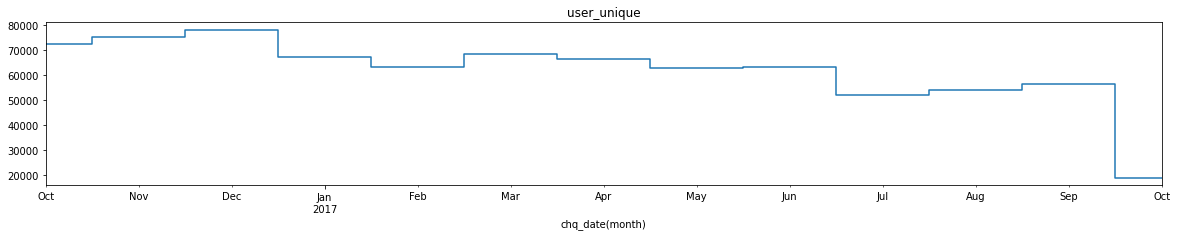

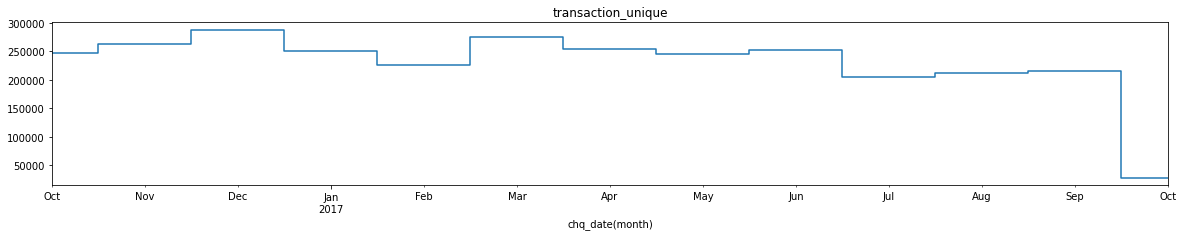

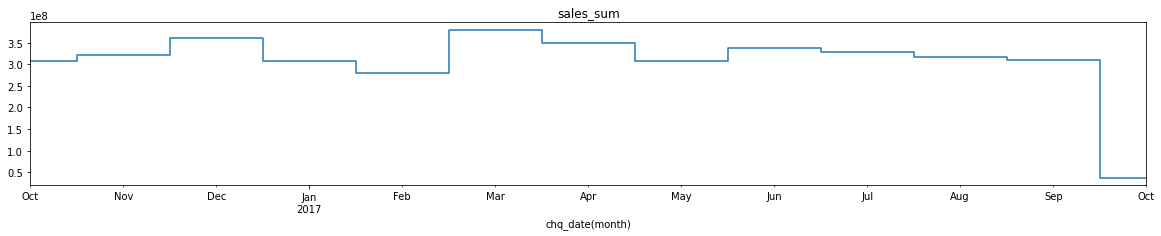

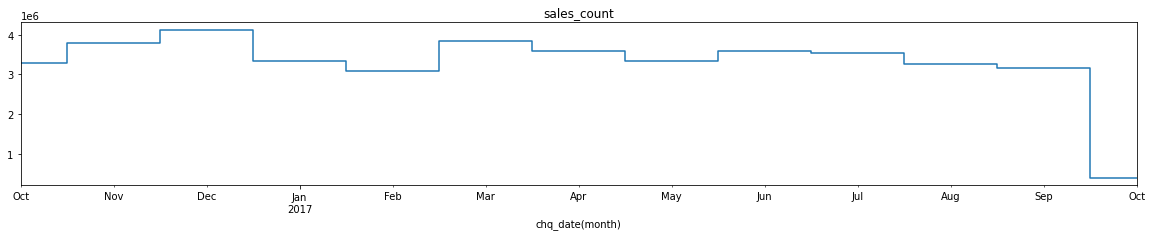

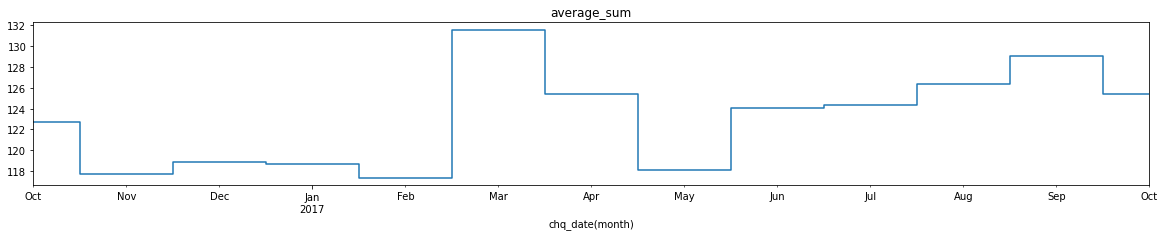

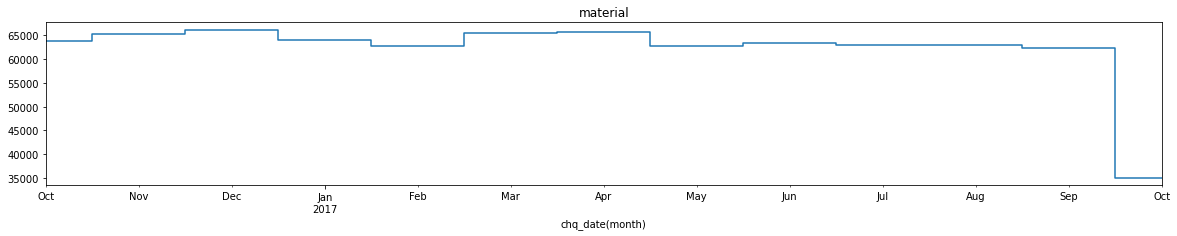

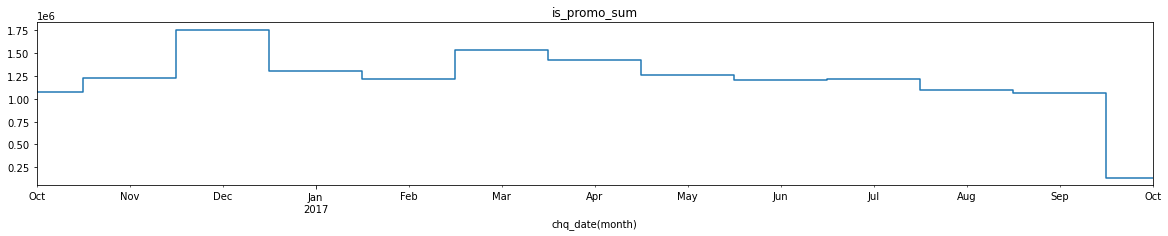

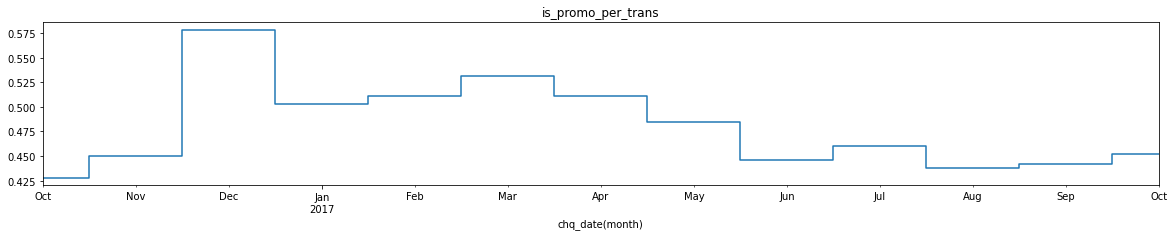

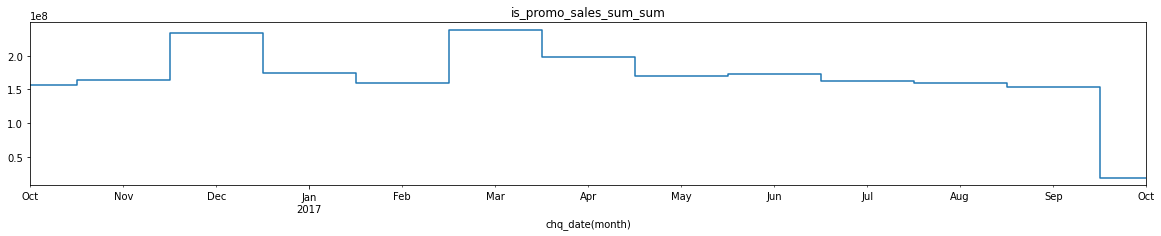

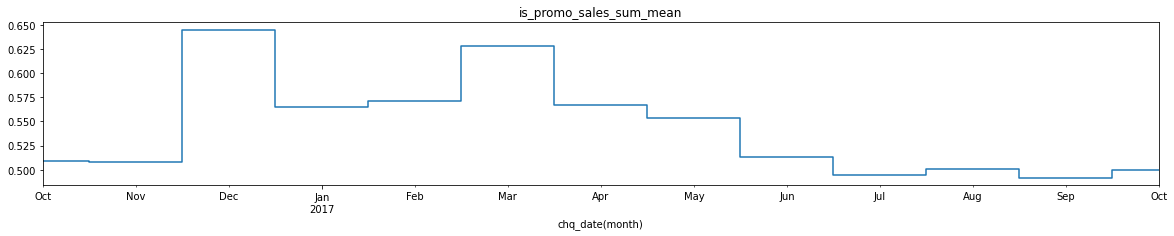

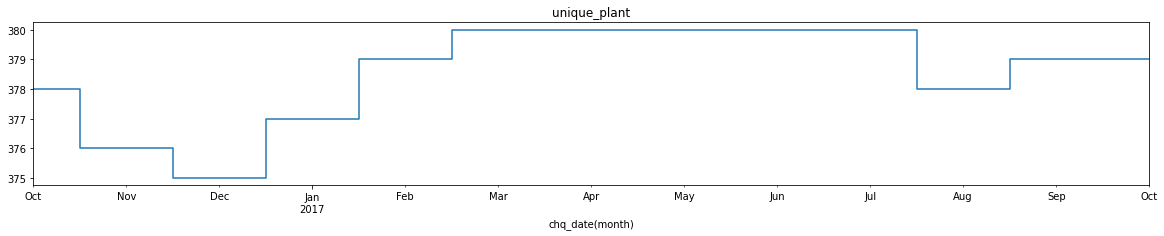

CPU times: user 6min 29s, sys: 6.55 s, total: 6min 36s
Wall time: 6min 35s


In [19]:
%%time
# # Создаем различные варианты агрегаций времени
# # Месяц

df['chq_date(month)'] = pd.to_datetime(df['chq_date'].dt.strftime('%Y.%m'))

print('Графики по месяцам')
df_temp = df.groupby('chq_date(month)').apply(get_time_features)
## Подневно
for key in df_temp.keys():
    df_temp[key].plot(figsize = (20, 3), 
                      title = key, 
                      drawstyle ="steps-mid")
    plt.show()

#### По неделям

Графики по неделям


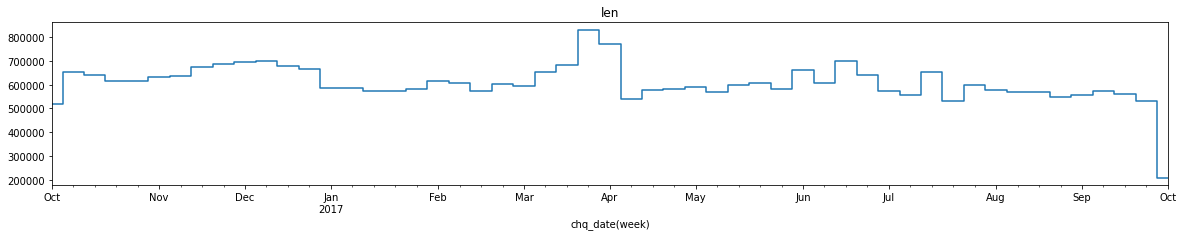

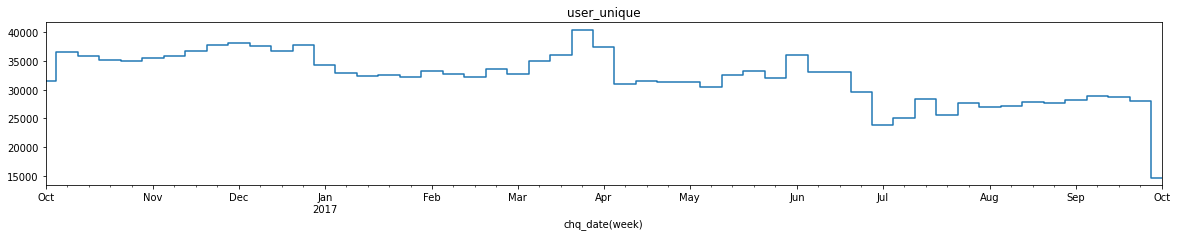

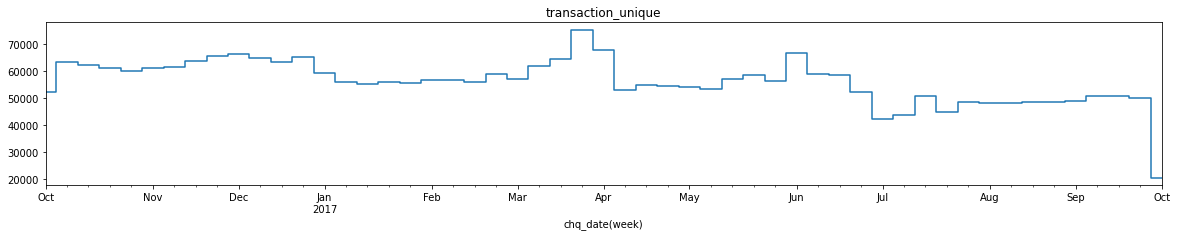

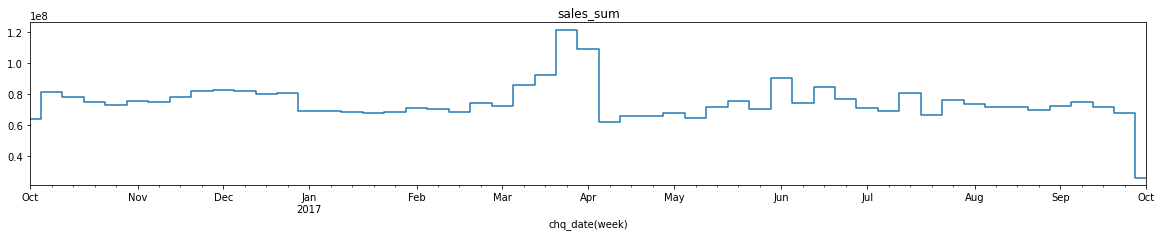

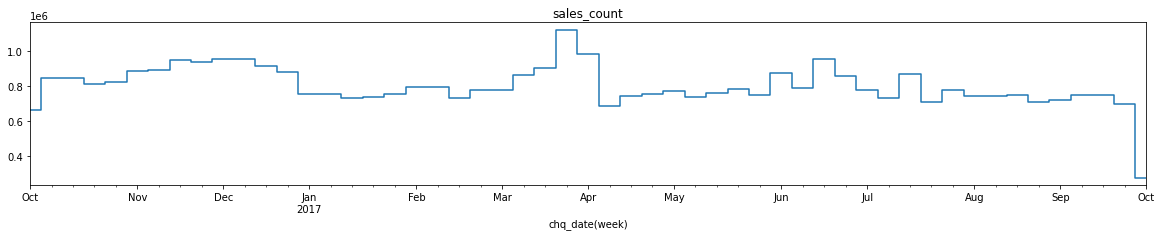

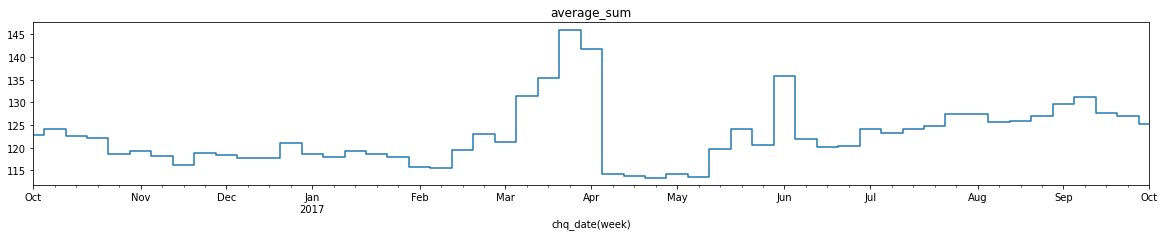

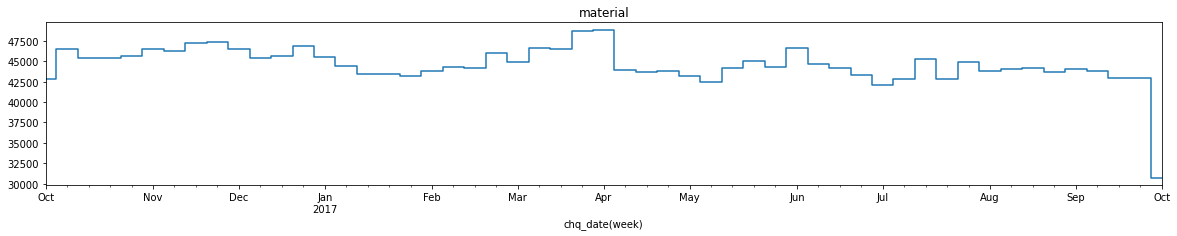

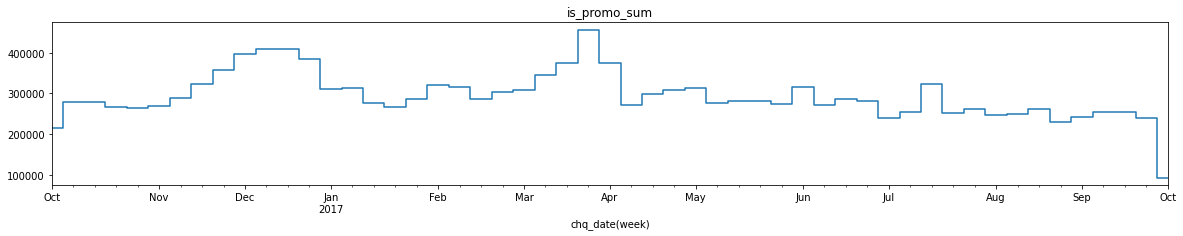

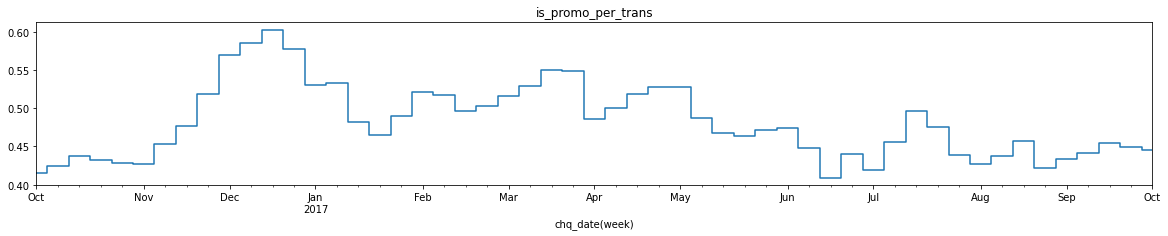

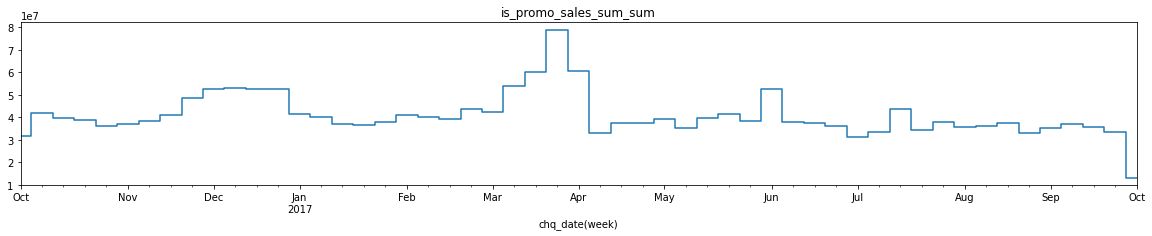

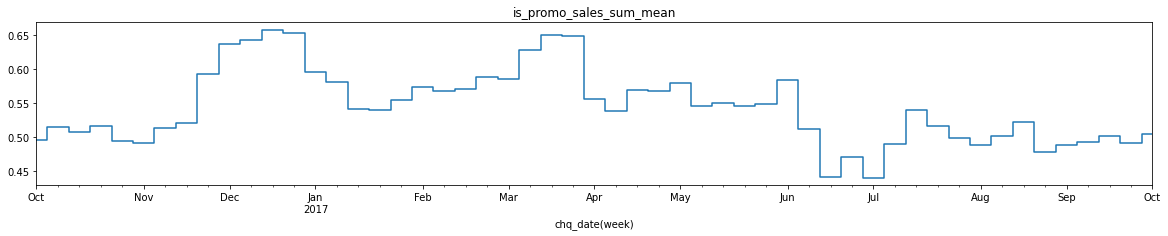

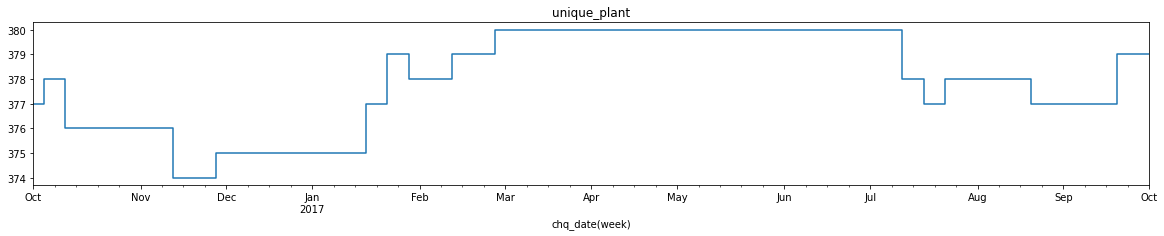

CPU times: user 9min 17s, sys: 13 s, total: 9min 30s
Wall time: 9min 30s


In [20]:
%%time
# Создаем различные варианты агрегаций времени
# Неделя

df['chq_date(week)'] = df['chq_date'].apply(lambda dt: dt - timedelta(days=dt.weekday()))

print('Графики по неделям')
df_temp = df.groupby('chq_date(week)').apply(get_time_features)
## Подневно
for key in df_temp.keys():
    df_temp[key].plot(figsize = (20, 3), 
                      title = key,
                      drawstyle ="steps-mid")
    plt.show()

#### По дням недели (понедельник, вторник, )

Графики по дням недели


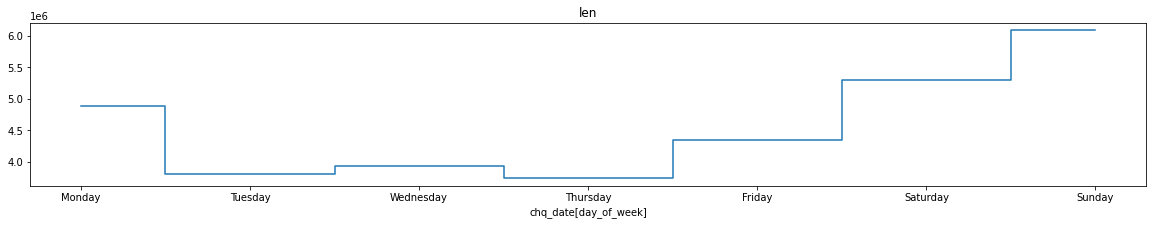

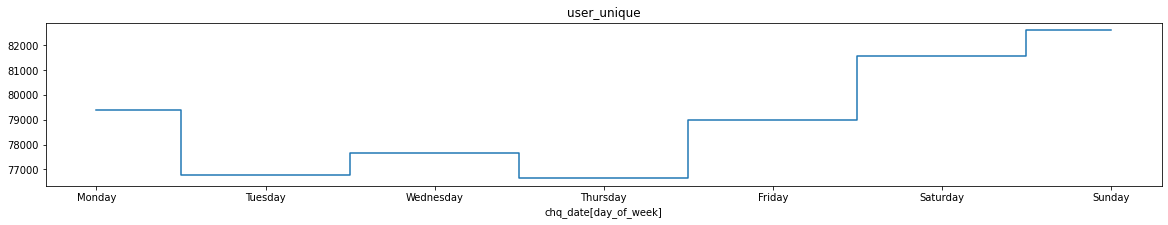

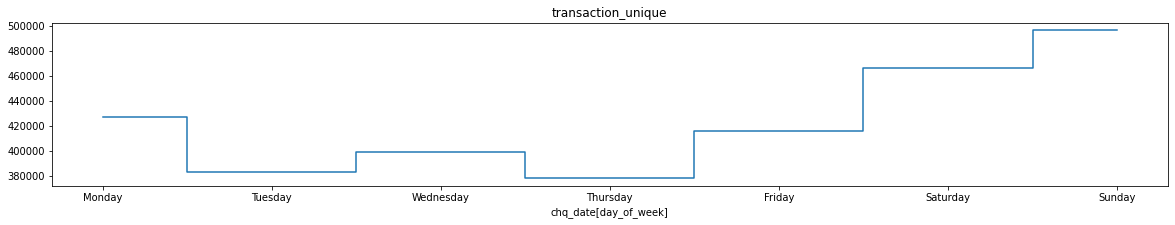

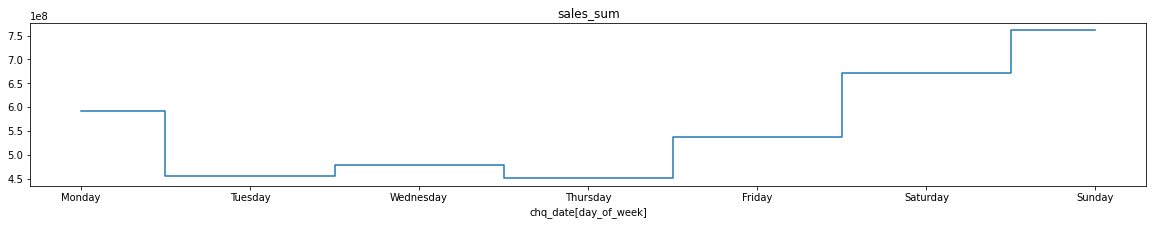

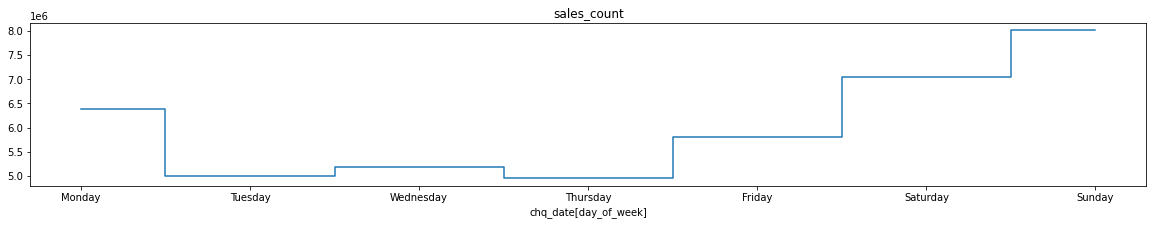

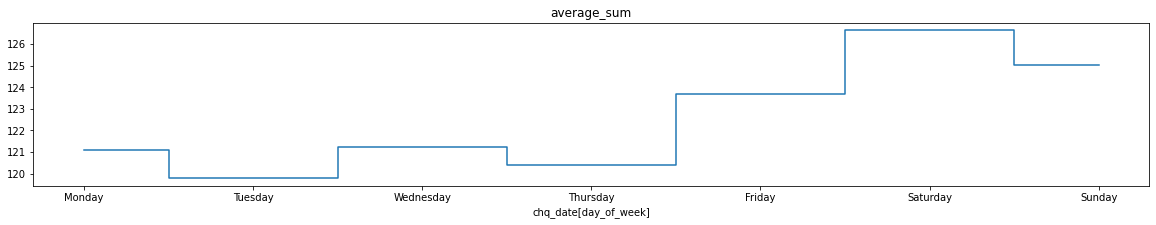

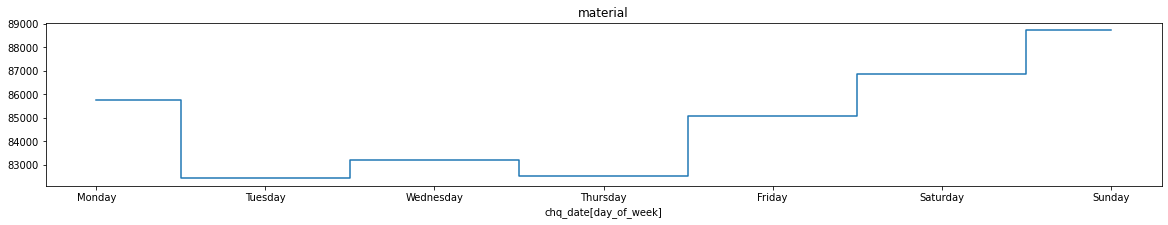

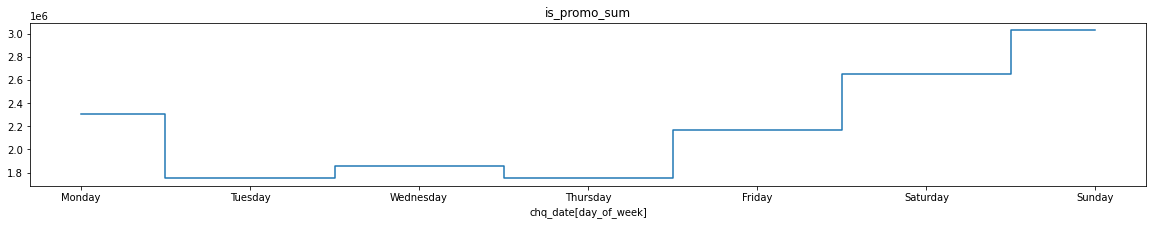

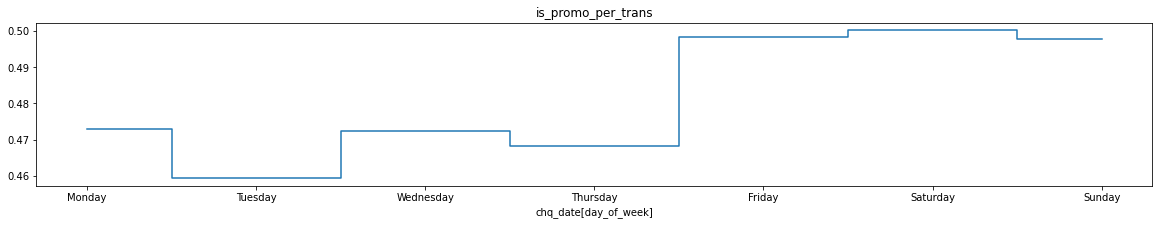

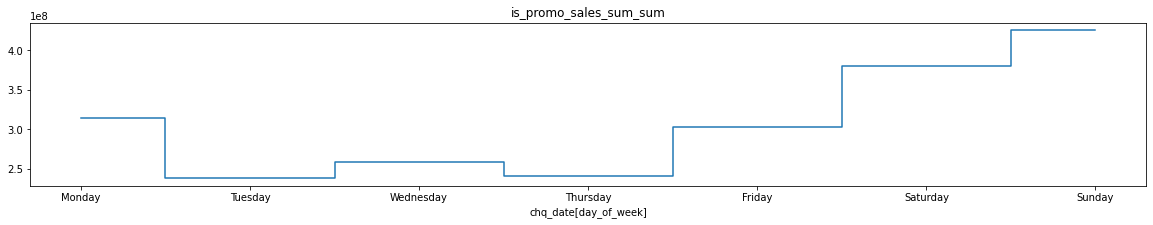

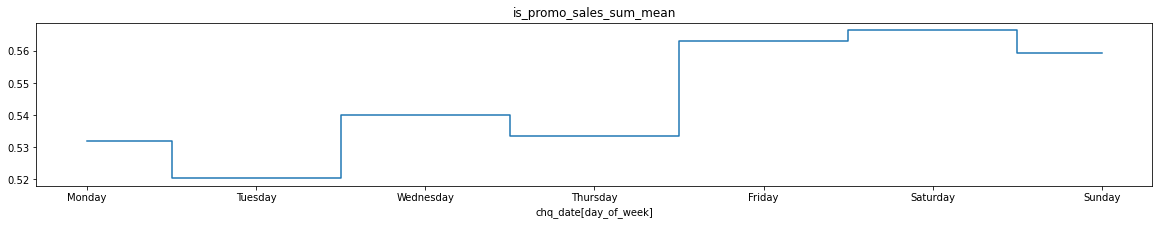

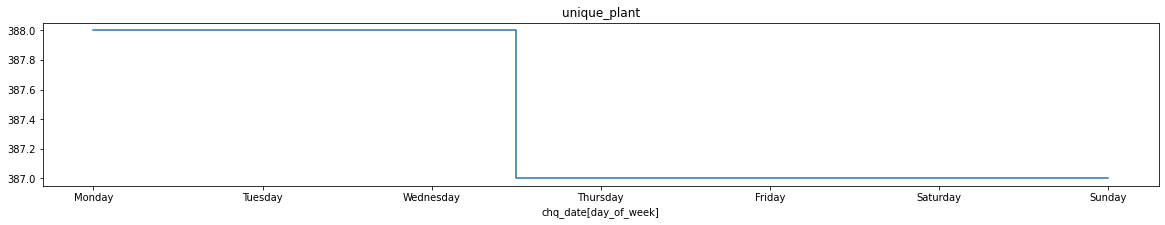

CPU times: user 34.2 s, sys: 3.15 s, total: 37.4 s
Wall time: 37.3 s


In [21]:
%%time
# Создаем различные варианты агрегаций времени
# День нелели

day_of_week_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# df['chq_date[day_of_week]'] = df['chq_date'].dt.dayofweek#.apply(lambda x:day_of_week_list[x])
print('Графики по дням недели')
df_temp = df.groupby('chq_date[day_of_week]').apply(get_time_features)
## Подневно
for key in df_stat.keys():
    df_temp[key].plot(figsize = (20, 3), 
                      title = key, 
                      drawstyle ="steps-mid"
                     )
    
    plt.xticks(range(0, len(day_of_week_list)), day_of_week_list)
    plt.show()

##### Выводы:
- Есть сильная зависимость по дням недели, в выходные, клиентов сильно больше.
  Забавно что понедельник и пятница, тоже более прибыльные дни (все готовятся в выходным или забыли что-то купить на выходных)
  
- На выходных люди покупают на 6% больше товаров по акции.

- Сезонная зависимость слабая

- Что-то интересное случилось в апреле, до него был сильный подъем, после него сильный спад
  > Скорее всего данные были амбусцированны(Сдвинуты вперед на x лет + 5 месяцев) и это новый год.
    Так как в декабре-январе нет такого пика
    
- В целом есть слабый тренд на понижении выручки
  > Возможно это связано с особенностью формирования данных
    (в выборку попали только клиенты пришедшие до 2017-01-03, они естественным образом убывают, а нового притока нет)


### Посмотрим на выручку по различным магазинам по периодам

In [22]:
def draw2plot(l1 = "2017-01-01",
              r1 = "2017-02-01",
              l2 = "2017-03-01",
              r2 = "2017-04-01", 
              name_str = "sales_sum"
             ):

    l = pd.to_datetime(l1)
    r = pd.to_datetime(r1)

    df0 = df[(df['chq_date']<r) & (df['chq_date']>l) ]

    l = pd.to_datetime(l2)
    r = pd.to_datetime(r2)


    df1 = df[(df['chq_date']<r) & (df['chq_date']>l) ]

    a = df0.groupby('plant')[[name_str]].sum().sort_values(name_str, ascending = False).rename(columns = {name_str:'first'})#.reset_index()
    b = df1.groupby('plant')[[name_str]].sum().sort_values(name_str, ascending = False).rename(columns = {name_str:'last'})#.reset_index()

    print(f"Number of stores 1: {len(a)}, 2: {len(b)}")
    
    df_store_stat = pd.merge(a, 
                             b, 
                             how = 'outer',
                             on  = 'plant')

    plt.figure(figsize = (10, 10))
    plt.scatter(df_store_stat['first'], df_store_stat['last'])
    t = max(df_store_stat['first'])
    plt.plot([0, t], [0, t], color = 'red', linestyle = '--', linewidth = 5, alpha = 0.5)
    plt.title(f'{name_str} sum', size = 22)
    plt.ylabel(f'last  month [{l1};{r1}]', size = 18)
    plt.xlabel(f'first month [{l2};{r2}]', size = 18)
    plt.show()


Number of stores 1: 377, 2: 380


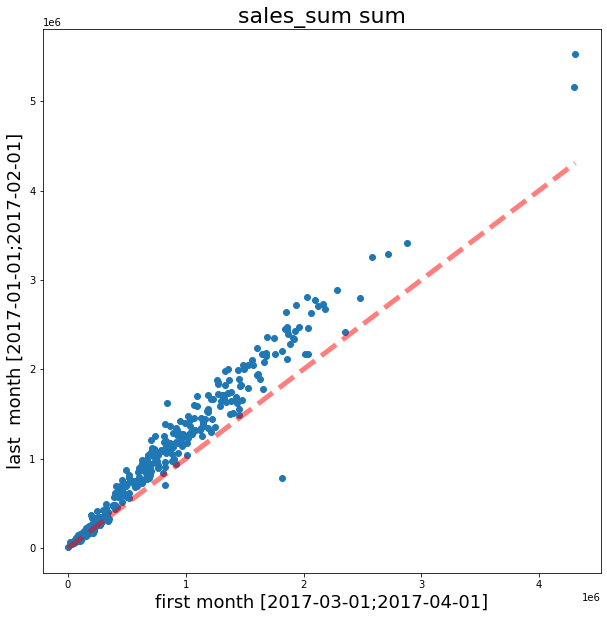

In [23]:
draw2plot(l1 = "2017-01-01",
          r1 = "2017-02-01",
          l2 = "2017-03-01",
          r2 = "2017-04-01")

Number of stores 1: 380, 2: 380


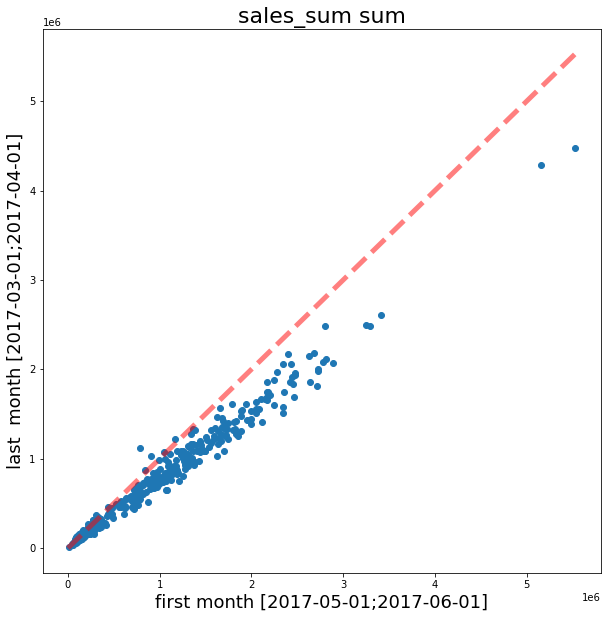

In [24]:
draw2plot(l1 = "2017-03-01",
          r1 = "2017-04-01",
          l2 = "2017-05-01",
          r2 = "2017-06-01")

Number of stores 1: 385, 2: 383


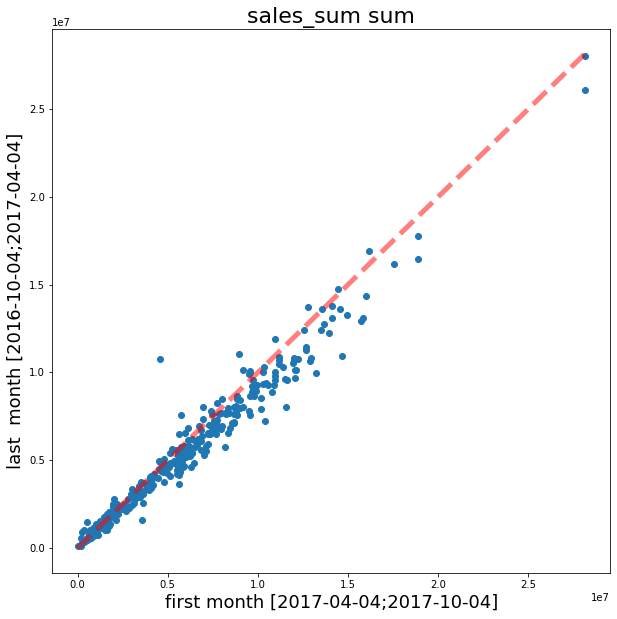

In [25]:
draw2plot(l1 = "2016-10-04",
          r1 = "2017-04-04",
          l2 = "2017-04-04",
          r2 = "2017-10-04")

#### Выводы
> Выбросов мало, все магазины ведут себя похожим образом

#### Странно, но в выборке есть негативные транзакции

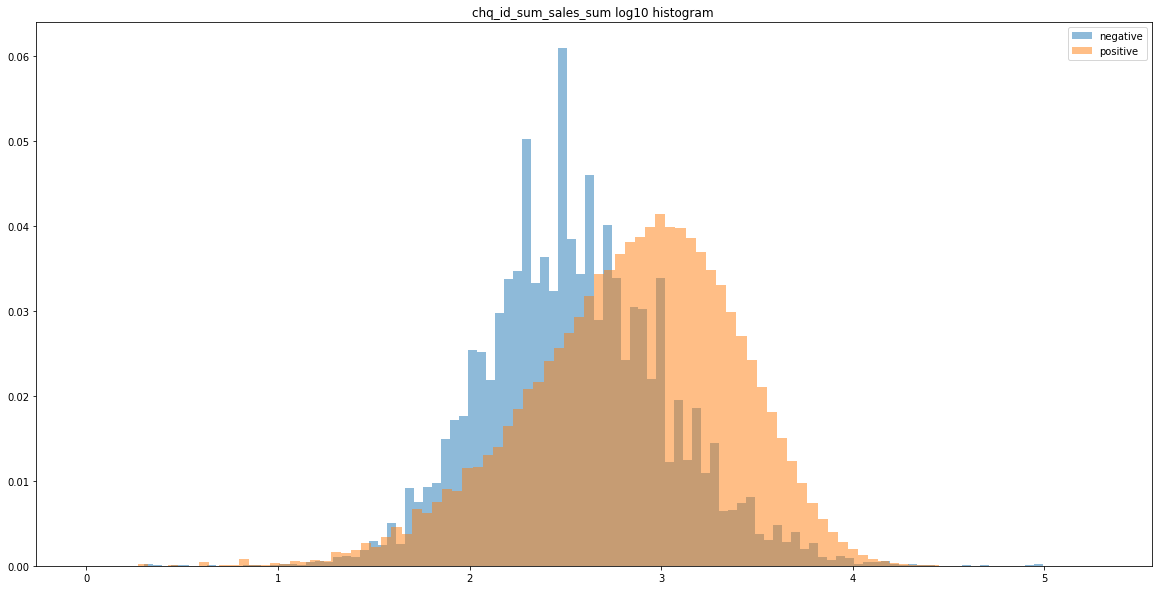

In [26]:
o = df.drop_duplicates('chq_id')
plt.figure(figsize = (20, 10))
o_current = o.loc[o['chq_id_sum_sales_sum']<0, 'chq_id_sum_sales_sum'].apply(lambda x:np.log10(1-x))
w = np.ones(len(o_current))/len(o_current)
plt.hist(o_current, weights=w, bins = 100, label = 'negative', alpha = 0.5)
plt.title('chq_id_sum_sales_sum log10 histogram ')

o_current = o.loc[o['chq_id_sum_sales_sum']>=0, 'chq_id_sum_sales_sum'].apply(lambda x:np.log10(1+x))
w = np.ones(len(o_current))/len(o_current)
plt.hist(o_current, weights=w, bins = 100, label = 'positive', alpha = 0.5)
plt.legend()
plt.show()

# В логарифмических осях построить распределение chq_id_sum_sales_sum, должно выйти лог-нормальное распределение

> Возможно это омена покупки?

Кстати средний чек около 1000 руб

### Как выглядят сумма положительных и отрицательных чеков по дням

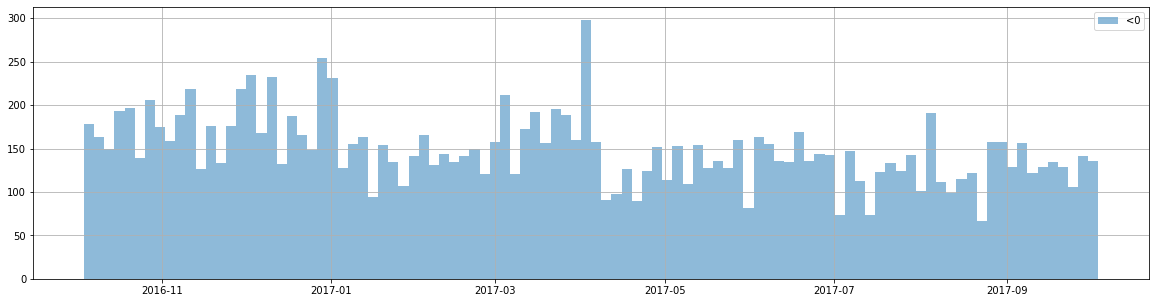

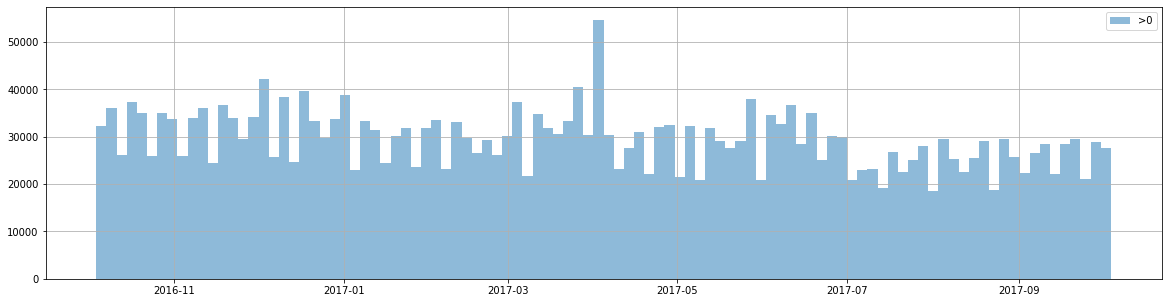

In [27]:
df.loc[df['chq_id_sum_sales_sum']<0].drop_duplicates('chq_id')['chq_date'].hist(label = '<0', figsize = (20, 5), alpha = 0.5, bins = 100)
plt.legend()
plt.show()

df.loc[df['chq_id_sum_sales_sum']>=0].drop_duplicates('chq_id')['chq_date'].hist(label = '>0', figsize = (20, 5),alpha = 0.5, bins = 100)
plt.legend()
plt.show()

In [28]:
# Правда ли, что нет транзакций в которых есть и отрицательные и положительные чеки?
# Проверим что это отмена
print('<0 correct', (df.loc[df['chq_id_sum_sales_sum']<0, 'sales_sum']<0).all())
print('>0 correct', (df.loc[df['chq_id_sum_sales_sum']>0, 'sales_sum']>0).all())
# > Да

<0 correct True
>0 correct True


In [29]:
df.loc[df['chq_id_sum_sales_sum']<0].sort_values('chq_id_sum_sales_sum')

chq_id                             plant  \
31431694  61b17e3843e880f6bd51324a8d94610e  c81c2b9e997a81f84838cd8e60b93a01   
31431709  cc50070834892c5348978d9d3f3c9cb5  c81c2b9e997a81f84838cd8e60b93a01   
31431699  cc50070834892c5348978d9d3f3c9cb5  c81c2b9e997a81f84838cd8e60b93a01   
31431690  cc50070834892c5348978d9d3f3c9cb5  c81c2b9e997a81f84838cd8e60b93a01   
31431703  af2b422068ed54af49ef0275520314a7  c81c2b9e997a81f84838cd8e60b93a01   
...                                    ...                               ...   
17187510  113e16efd4d3653ea360ba14fab7c1e0  56c66132e67551c55b1667f9b14de886   
28010290  caba8f8f97354ffaaccf5d9ff9a42a92  2ebe25dd3a566f36f80d55440d3c3834   
28241201  83549160c46d0cabdea5abdf7ee7171b  2d0974b2436345d99f7152c3fc44a609   
14176442  f50e725f14a879adb1d173467f4cf560  62a8d042a93d5f88fb6636cde700ce69   
16074900  8ac69876725e21cb1594bb640894dd9c  898dc2c947cee718e4afd7dfcb2f1a09   

           chq_date chq_position                         client_id  \
31431694 2016-10-21          001  596f837a638189cb15e9d4b144dd45c4   
31431709 2016-10-21          003  596f837a638189cb15e9d4b144dd45c4   
31431699 2016-10-21          002  596f837a638189cb15e9d4b144dd45c4   
31431690 2016-10-21          001  596f837a638189cb15e9d4b144dd45c4   
31431703 2016-10-21          003  596f837a638189cb15e9d4b144dd45c4   
...             ...          ...                               ...   
17187510 2017-04-05          001  18b4bee65b54e69f28ec71c4e49660d2   
28010290 2017-08-19          001  806aa67e23892d029172d4347da3310a   
28241201 2017-08-25          001  d3b66ff3c56a962b5b4146d46a6940be   
14176442 2017-04-04          001  35be5e61ba319475211d55cd64ffcc5e   
16074900 2017-04-22          001  79967883d650b656ec4253cb314ac7e4   

                                  material  sales_count  sales_sum  is_promo  \
31431694  df61ac05dd83388e5b5c766cf4fcb312        -60.0  -98388.00         0   
31431709  639744133763da589ad3055d293b9154        -48.0  -34236.00         0   
31431699  ec13cc81075855dfe31e2fb8116344ed         -4.0   -3389.76         0   
31431690  ec13cc81075855dfe31e2fb8116344ed        -68.0  -57625.24         0   
31431703  df61ac05dd83388e5b5c766cf4fcb312        -10.0  -16398.00         0   
...                                    ...          ...        ...       ...   
17187510  e157c57ca48445c18680a86767f4c997         -1.0      -1.37         1   
28010290  d24abc923a61543ffc13ccace7cb5da4         -1.0      -1.00         1   
28241201  d3e97c413ab082ba9e5fe06d053e9f25         -1.0      -1.00         0   
14176442  cfe5b2573c75bb74848a1ae7da2e628a         -1.0      -1.00         1   
16074900  9819e69da6c87edb432267ab3c6d8a42         -1.0      -1.00         1   

          chq_id_sum_sales_count  chq_id_len  chq_id_sum_sales_sum  \
31431694                   -60.0           1             -98388.00   
31431709                  -120.0           3             -95251.00   
31431699                  -120.0           3             -95251.00   
31431690                  -120.0           3             -95251.00   
31431703                  -100.0           3             -94689.00   
...                          ...         ...                   ...   
17187510                    -1.0           1                 -1.37   
28010290                    -1.0           1                 -1.00   
28241201                    -1.0           1                 -1.00   
14176442                    -1.0           1                 -1.00   
16074900                    -1.0           1                 -1.00   

         chq_date(month) chq_date(week)  chq_date[day_of_week]  
31431694      2016-10-01     2016-10-17                      4  
31431709      2016-10-01     2016-10-17                      4  
31431699      2016-10-01     2016-10-17                      4  
31431690      2016-10-01     2016-10-17                      4  
31431703      2016-10-01     2016-10-17                      4  
...                  ...            ...   

#### Если это отмена, попробуем найти отмененные покупки в базе

In [30]:
df.loc[df['chq_id_sum_sales_sum']<0]["chq_id_sum_sales_sum"].value_counts()

-300.00      99
-199.00      85
-7211.00     80
-99.99       78
-23036.00    78
             ..
-141.26       1
-1998.84      1
-848.31       1
-155.29       1
-812.35       1
Name: chq_id_sum_sales_sum, Length: 10611, dtype: int64

In [31]:
df.loc[df['chq_id_sum_sales_sum']==-1.37]

chq_id                             plant  \
17187510  113e16efd4d3653ea360ba14fab7c1e0  56c66132e67551c55b1667f9b14de886   

           chq_date chq_position                         client_id  \
17187510 2017-04-05          001  18b4bee65b54e69f28ec71c4e49660d2   

                                  material  sales_count  sales_sum  is_promo  \
17187510  e157c57ca48445c18680a86767f4c997         -1.0      -1.37         1   

          chq_id_sum_sales_count  chq_id_len  chq_id_sum_sales_sum  \
17187510                    -1.0           1                 -1.37   

         chq_date(month) chq_date(week)  chq_date[day_of_week]  
17187510      2017-04-01     2017-04-03                      2

In [32]:
df.loc[df['chq_id_sum_sales_sum']==1.37]

Empty DataFrame
Columns: [chq_id, plant, chq_date, chq_position, client_id, material, sales_count, sales_sum, is_promo, chq_id_sum_sales_count, chq_id_len, chq_id_sum_sales_sum, chq_date(month), chq_date(week), chq_date[day_of_week]]
Index: []

##### Нет повнота, скорее всего наше предположение не верно, попробуем еще раз позже

In [33]:
df.loc[df['chq_id_sum_sales_sum']==-112]

chq_id                             plant  \
825990  7ffda6e6cc1bec49b4547bbece727405  6296580f0889e341dd9ba0992333171d   

         chq_date chq_position                         client_id  \
825990 2016-11-29          001  acbddf27bbb1c126812778a31be6f899   

                                material  sales_count  sales_sum  is_promo  \
825990  53e12736b59eb0964e1d14d7cdabcded        -0.28     -112.0         0   

        chq_id_sum_sales_count  chq_id_len  chq_id_sum_sales_sum  \
825990                   -0.28           1                -112.0   

       chq_date(month) chq_date(week)  chq_date[day_of_week]  
825990      2016-11-01     2016-11-28                      1

In [34]:
df.loc[(df['chq_id_sum_sales_sum']==112) & (df['client_id']=='acbddf27bbb1c126812778a31be6f899')]

Empty DataFrame
Columns: [chq_id, plant, chq_date, chq_position, client_id, material, sales_count, sales_sum, is_promo, chq_id_sum_sales_count, chq_id_len, chq_id_sum_sales_sum, chq_date(month), chq_date(week), chq_date[day_of_week]]
Index: []

> Странно, если будет время, вернемся к этому вопросу позже

### Первчная подготовка признаков

In [35]:
%%time

def diff_to_days(x):
    return x / np.timedelta64(1, 's') / 60 / 60 / 24

def _get_features(data):
    data_no_duplicates = data.drop_duplicates("chq_id")
    data_negative      = data[data['sales_sum']<0]
    
    t_list = list(sorted(data_no_duplicates['chq_date'].unique()))
    deltas = diff_to_days(np.diff(t_list)) #интервалы между датами транзакций
    bins = [0, 1, 7, 14, 21, 28, 56, 112, 224, 448]
    res = {
           't_min'  : data['chq_date'].min(),          # Даты (первая, последняя и весь список)
           't_max'  : data['chq_date'].max(),  
           '_t_list' : t_list,
        
           'items_N' : data['chq_id'].nunique(),              # Количество пробитых товаров
           'items_sales_sum_sum':data['sales_sum'].sum(),     # Сколько потратил
           'items_sales_count_sum':data['sales_count'].sum(), # Сколько покупок сделал

           'items_N_negative' : data_negative['chq_id'].nunique(),              # Количество пробитых товаров
           'items_sales_sum_sum_negative':data_negative['sales_sum'].sum(),     # Сколько потратил
           'items_sales_count_sum_negative':data_negative['sales_count'].sum(), # Сколько покупок сделал
           
           "item_price_mean" : data['chq_id_sum_sales_count'].mean(), # Средняя цена товара
           "item_price_max"  : data['chq_id_len'].max(),              # Максимальная цена товара
           "item_price_min"  : data['chq_id_sum_sales_sum'].min(),    # Минимальная цена товара
           
        
           'chq_id_sum_sales_count_mean':data_no_duplicates['chq_id_sum_sales_count'].mean(),   # Средний количество покупок
           'chq_id_len_mean':data_no_duplicates['chq_id_len'].mean(),                           # Средее количнтво товаров
           'chq_id_sum_sales_sum_mean':data_no_duplicates['chq_id_sum_sales_sum'].mean(),       # Средняя цена товаров
                   
           'chq_id_sum_sales_count_min':data_no_duplicates['chq_id_sum_sales_count'].min(),  # То-же самое для минимума
           'chq_id_len_min':data_no_duplicates['chq_id_len'].min(),
           'chq_id_sum_sales_sum_min':data_no_duplicates['chq_id_sum_sales_sum'].min(),
            
           
           'chq_id_sum_sales_count_max':data_no_duplicates['chq_id_sum_sales_count'].max(), # То-же самое для максимума
           'chq_id_len_max':data_no_duplicates['chq_id_len'].max(),
           'chq_id_sum_sales_sum_max':data_no_duplicates['chq_id_sum_sales_sum'].max(),
        
           'promo_rate_count': (data['is_promo']==1).mean(),    # Доля промо
           'promo_rate_sales_sum': (data.loc[(data['is_promo']==1), 'sales_sum'].sum()+1)/(data['sales_sum'].sum()+1),
           'promo_rate_sales_count': (data.loc[(data['is_promo']==1), 'sales_count'].sum()+1)/(data['sales_count'].sum()+1),
        
            "delta_median" : np.median(deltas) if len(deltas)>0 else np.nan, # 
            "delta_min"    : np.min(deltas) if len(deltas)>0 else np.nan,
            "delta_max"    : np.max(deltas) if len(deltas)>0 else np.nan,
            "delta_std"    : np.std(deltas) if len(deltas)>0 else np.nan,
            "delta_moda"   : np.argmax(np.bincount(deltas.astype(int))) if len(deltas)>0 else np.nan,
          }
    
    # Позитивные транзакции
    res['items_N_positive']               = res['items_N']-res['items_N_negative']
    res['items_sales_sum_sum_positive']   = res['items_sales_sum_sum']-res['items_sales_sum_sum_negative']
    res['items_sales_count_sum_positive'] = res['items_sales_count_sum']-res['items_sales_count_sum_negative']
    
    
    # Отношение негативного к позитивному
    ##res['negative_pos_rate_len_positive'] = res['negative_pos_rate_len']  -res['negative_pos_rate_len_negative']  
    for l in range(1, len(bins)):
        res[f'delta_bin_{bins[l-1]}_{bins[l],}'] = np.mean([((bins[l-1]<=x) and (x<bins[l]))  for x in deltas])
    
    
    for c in range(2):
        res[f'plant_key_{c}'] = np.nan
        res[f'plant_val_{c}'] = np.nan 
        res[f'material_key_{c}'] = np.nan
        res[f'material_val_{c}'] = np.nan 
        
    # Самые популярные города по количеству и из доля
    for c, (key, val) in enumerate(data_no_duplicates['plant'].value_counts(True).to_dict().items()):
        if c>=2:
            break

        res[f'plant_key_{c}'] = key
        res[f'plant_val_{c}'] = val     
    #два топовых магазина для юзера
        
    # Самые популярные товары по количеству и из доля    
    for c, (key, val) in enumerate(data['material'].value_counts(True).to_dict().items()):
        if c>=2:
            break
            
        res[f'material_key_{c}'] = key
        res[f'material_val_{c}'] = val  
    
    # Добавить join на metrials из таблицы 'materials.txt'
    # Добавить join на plant из таблицы пользователей если для каждого магазина взять максимальное количество пользователей с городом, это должно помоч
    
    return pd.Series(res)  

# _get_features(df[:100])
# user_sample = ["1a47d62dddacc03fe90c15652f7ae1a4"]#df['client_id'].sample(5000, random_state = 42).to_numpy()
# res = df[df['client_id'].isin(user_sample)].groupby('client_id').apply(_get_features)
# res
df_client = df.groupby('client_id').apply(_get_features)
# df_client['client_id'] = df_client.index
# print('Finish calculating')

df_client.to_parquet("results/df_client_id.parquet")
# df_client

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

CPU times: user 19min 33s, sys: 8.9 s, total: 19min 42s
Wall time: 19min 40s


In [37]:
df_client.head()

t_min      t_max  \
client_id                                                
0000d48a8891cd462fdf01ea861ec53e 2016-10-31 2017-08-31   
00028a1dcb30863404a386961a69300e 2016-10-09 2017-09-15   
0004274683494a9eca5e70ef97299d55 2016-10-04 2017-10-04   
00072f81efcb3481861f7300c5e2a88a 2016-10-29 2017-09-07   
00076596eb749cf10c2e984621dffe95 2016-10-05 2017-10-04   

                                                                            _t_list  \
client_id                                                                             
0000d48a8891cd462fdf01ea861ec53e  [2016-10-31T00:00:00.000000000, 2016-11-20T00:...   
00028a1dcb30863404a386961a69300e  [2016-10-09T00:00:00.000000000, 2016-10-20T00:...   
0004274683494a9eca5e70ef97299d55  [2016-10-04T00:00:00.000000000, 2016-10-05T00:...   
00072f81efcb3481861f7300c5e2a88a  [2016-10-29T00:00:00.000000000, 2016-11-17T00:...   
00076596eb749cf10c2e984621dffe95  [2016-10-05T00:00:00.000000000, 2016-10-06T00:...   

                                  items_N  items_sales_sum_sum  \
client_id                                                        
0000d48a8891cd462fdf01ea861ec53e       40             85898.00   
00028a1dcb30863404a386961a69300e       34             51916.00   
0004274683494a9eca5e70ef97299d55      169            101130.00   
00072f81efcb3481861f7300c5e2a88a        8              5125.00   
00076596eb749cf10c2e984621dffe95      166            203833.46   

                                  items_sales_count_sum  items_N_negative  \
client_id                                                                   
0000d48a8891cd462fdf01ea861ec53e                966.731                 1   
00028a1dcb30863404a386961a69300e                470.427                 0   
0004274683494a9eca5e70ef97299d55               1407.353                 0   
00072f81efcb3481861f7300c5e2a88a                 44.596                 0   
00076596eb749cf10c2e984621dffe95               3160.780                 1   

                                  items_sales_sum_sum_negative  \
client_id                                                        
0000d48a8891cd462fdf01ea861ec53e                       -249.00   
00028a1dcb30863404a386961a69300e                          0.00   
0004274683494a9eca5e70ef97299d55                          0.00   
00072f81efcb3481861f7300c5e2a88a                          0.00   
00076596eb749cf10c2e984621dffe95                       -249.54   

                                  items_sales_count_sum_negative  \
client_id                                                          
0000d48a8891cd462fdf01ea861ec53e                            -1.0   
00028a1dcb30863404a386961a69300e                             0.0   
0004274683494a9eca5e70ef97299d55                             0.0   
00072f81efcb3481861f7300c5e2a88a                             0.0   
00076596eb749cf10c2e984621dffe95                            -1.0   

                                  item_price_mean  ...  delta_bin_112_(224,)  \
client_id                                          ...                         
0000d48a8891cd462fdf01ea861ec53e        29.579307  ...                   0.0   
00028a1dcb30863404a386961a69300e        23.418793  ...                   0.0   
0004274683494a9eca5e70ef97299d55        11.373868  ...                   0.0   
00072f81efcb3481861f7300c5e2a88a         8.663586  ...                   0.0   
00076596eb749cf10c2e984621dffe95        28.274646  ...                   0.0   

                                  delta_bin_224_(448,)  \
client_id                                                
0000d48a8891cd462fdf01ea861ec53e                   0.0   
00028a1dcb30863404a386961a69300e                   0.0   
0004274683494a9eca5e70ef97299d55                   0.0   
00072f81efcb3481861f7300c5e2a88a                   0.0   
00076596eb749cf10c2e984621dffe95                   0.0   

                                                       plant_key_0  \
client_id                               

##### Среднии чеки (положительные и отрицательные)

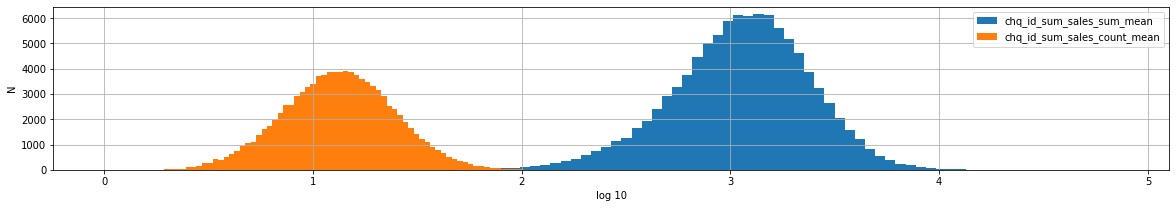

In [916]:
df_client['chq_id_sum_sales_sum_mean'].apply(lambda x: np.log10(1+x)).hist(figsize = (20, 3), 
                                                                            bins = 100, 
                                                                            label = 'chq_id_sum_sales_sum_mean')
plt.xlabel("log 10")
plt.ylabel("N")



#Среднее количество товаров в чеке на клиента, усредненные по клиентам
df_client['chq_id_sum_sales_count_mean'].apply(lambda x: np.log10(1+x)).hist(figsize = (20, 3), 
                                                                             bins = 100,
                                                                             label = 'chq_id_sum_sales_count_mean')


plt.legend()
plt.show()


In [311]:
t_data_start = df_client['t_min'].max()
t_data_start

Timestamp('2017-01-03 00:00:00')

> В выбороке есть только клиенты которые присоедениелись к программе лояльности 2017-01-03
  За 9 месяцев до финальной даты

In [50]:
df_client_raw = pd.read_csv('clients.csv')
print('df_client_raw.shape', df_client_raw.shape)
df_client_raw.head()

df_client_raw.shape (99995, 4)


client_id gender    city  birthyear
0  1a47d62dddacc03fe90c15652f7ae1a4      M   Other     1990.0
1  9cb909f701d25d548e953bff81192b56      F   Other     1969.0
2  d5da0f5b841b4f83383202807995027a      M   Other     1976.0
3  13ed7f16810b17b8cee6de834ac79a48      F  Moscow     1966.0
4  215fe3ea7d5bf0415e5504e2a7f33551      F   Other     1988.0

In [51]:
# Сколько уникальных элементов, что за тип
for key in df_client_raw.keys():
    print(f"{key} {' '*(20-len(key))}  {df_client_raw[key].nunique()} \t {df_client_raw[key].dtype} \t {df_client_raw[key].isna().sum()}")

client_id              99995 	 object 	 0
gender                 2 	 object 	 355
city                   3 	 object 	 0
birthyear              107 	 float64 	 1776


In [54]:
df_client['client_id'] = df_client.index.tolist()

#### Странно, но куда-то пропали 5 пользователей
(это очень мало относительно 10e4, не будем никак это учитывать)

In [55]:
df_client[~df_client['client_id'].isin(df_client_raw['client_id'].unique())]

t_min      t_max  \
client_id                                                
3ff5567abe9de12b87180220deec0311 2016-10-11 2017-09-01   
6d6857d997aea7ddee6107734bf1acfd 2016-10-04 2017-09-22   
94bf299e419de3e1d359e67d8868dc43 2016-11-23 2017-03-21   
d6e77dc47ead0049e5be7f6f4330cee2 2016-10-14 2017-08-23   
f284fc3143decf0ef4f93d7e75e5d6d0 2016-10-15 2017-09-26   

                                                                            _t_list  \
client_id                                                                             
3ff5567abe9de12b87180220deec0311  [2016-10-11T00:00:00.000000000, 2016-10-12T00:...   
6d6857d997aea7ddee6107734bf1acfd  [2016-10-04T00:00:00.000000000, 2016-10-26T00:...   
94bf299e419de3e1d359e67d8868dc43  [2016-11-23T00:00:00.000000000, 2016-11-28T00:...   
d6e77dc47ead0049e5be7f6f4330cee2  [2016-10-14T00:00:00.000000000, 2016-10-31T00:...   
f284fc3143decf0ef4f93d7e75e5d6d0  [2016-10-15T00:00:00.000000000, 2016-10-16T00:...   

                                  items_N  items_sales_sum_sum  \
client_id                                                        
3ff5567abe9de12b87180220deec0311       20              20427.0   
6d6857d997aea7ddee6107734bf1acfd       25              83003.0   
94bf299e419de3e1d359e67d8868dc43       10              10861.0   
d6e77dc47ead0049e5be7f6f4330cee2       10              18716.0   
f284fc3143decf0ef4f93d7e75e5d6d0       40              40030.0   

                                  items_sales_count_sum  items_N_negative  \
client_id                                                                   
3ff5567abe9de12b87180220deec0311                239.732                 0   
6d6857d997aea7ddee6107734bf1acfd                997.465                 0   
94bf299e419de3e1d359e67d8868dc43                144.130                 0   
d6e77dc47ead0049e5be7f6f4330cee2                160.482                 0   
f284fc3143decf0ef4f93d7e75e5d6d0                486.471                 0   

                                  items_sales_sum_sum_negative  \
client_id                                                        
3ff5567abe9de12b87180220deec0311                           0.0   
6d6857d997aea7ddee6107734bf1acfd                           0.0   
94bf299e419de3e1d359e67d8868dc43                           0.0   
d6e77dc47ead0049e5be7f6f4330cee2                           0.0   
f284fc3143decf0ef4f93d7e75e5d6d0                           0.0   

                                  items_sales_count_sum_negative  \
client_id                                                          
3ff5567abe9de12b87180220deec0311                             0.0   
6d6857d997aea7ddee6107734bf1acfd                             0.0   
94bf299e419de3e1d359e67d8868dc43                             0.0   
d6e77dc47ead0049e5be7f6f4330cee2                             0.0   
f284fc3143decf0ef4f93d7e75e5d6d0                             0.0   

                                  item_price_mean  ...  delta_bin_224_(448,)  \
client_id                                          ...                         
3ff5567abe9de12b87180220deec0311        16.725905  ...                   0.0   
6d6857d997aea7ddee6107734bf1acfd        61.309044  ...                   0.0   
94bf299e419de3e1d359e67d8868dc43        16.244503  ...                   0.0   
d6e77dc47ead0049e5be7f6f4330cee2        20.566309  ...                   0.0   
f284fc3143decf0ef4f93d7e75e5d6d0        18.958291  ...                   0.0   

                                                       plant_key_0  \
client_id                                                            
3ff5567abe9de12b87180220deec0311  5968996e0aca329cf3218086223f8308   
6d6857d997aea7ddee6107734bf1acfd  3d842a955f86c5982f18ed6fea9fa1a9   
94bf299e419de3e1d359e67d8868dc43  a9b2b0ce7799c4de9c7a3aed9ebeddeb   
d6e77dc47ead0049e5be7f6f4330cee2  a4e23b2609285cfd99de6d9832f21df1   
f284fc3143decf0ef4f93d7e75e5d6d0  857778a20b9a41d4ca0d687a36e4bfa8   

                          

#### Обьединим таблицы

In [56]:
df_client = df_client.join(df_client_raw.set_index("client_id"))

### Посмотрим на частоту походов клиетов в магазин

In [58]:
#рисует пользовательскую траекторию для n клиентов

def _print_user_times(N = 20, fn_out = None):
    user_sample = df_client['client_id'].sample(N, random_state = 42).to_numpy()

    o = df_client.loc[df_client['client_id'].isin(user_sample)]#, "_t_list"]
    y_ticks = []
    plt.figure(figsize = (20, 10))
    plt.title('User datetimes', fontsize = 22)
    plt.xlabel('time',    fontsize = 16)
    plt.ylabel('user_id', fontsize = 16)
    
    for c, (cliend_id, data) in enumerate(o.sort_values('t_max').iterrows()):
        x_list = data['_t_list']#.to_numpy()
        y_list = [c+1] * len(x_list)


        plt.scatter(x_list, 
                    y_list, 
                    s = 10,
                    marker = 'o')

        y_ticks.append(data['client_id'])

    plt.yticks(list(range(1, 1+len(y_ticks))), y_ticks)
    plt.plot([t_data_start, t_data_start], 
             [0, N+1], 
             label = f't_start = {t_data_start}',
             color = 'red', 
             linestyle = '--', 
             linewidth = 5,
             alpha = 0.2)

    plt.ylim(0, N+1)
    
    plt.legend(loc = "lower right", fontsize = 18)
    plt.grid()
    
    if fn_out is not None:
        plt.savefig(fn_out)
    
    plt.show()

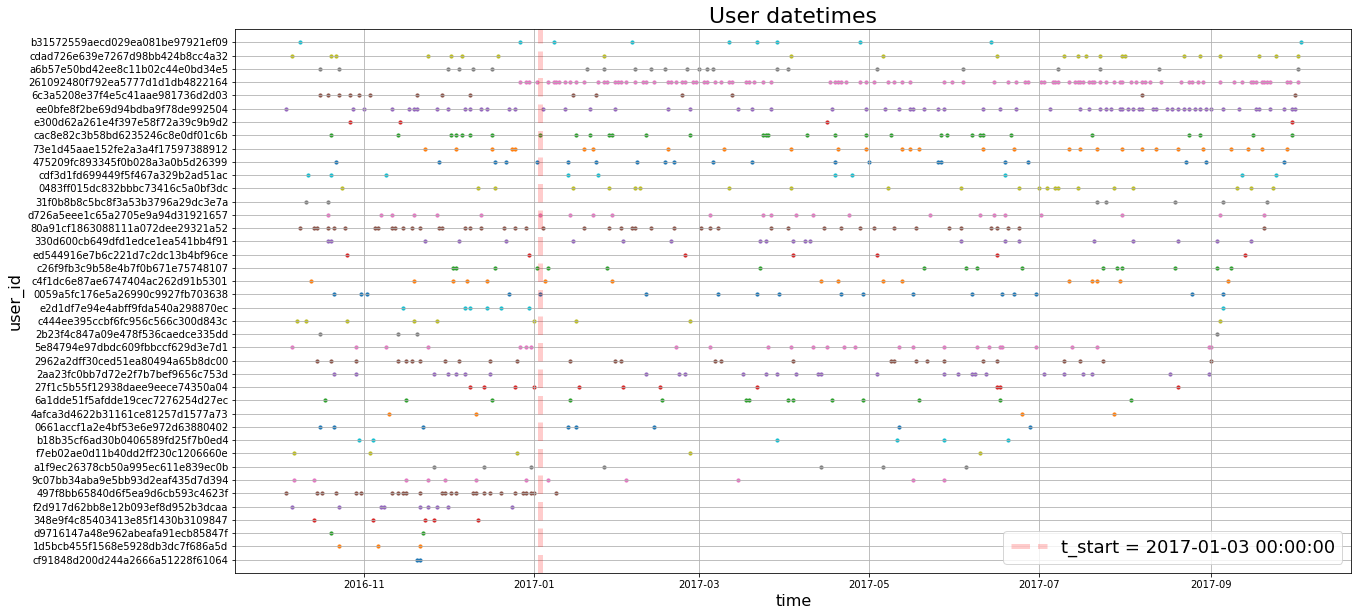

In [59]:
_print_user_times(40, fn_out = "results/users_datetime_40")

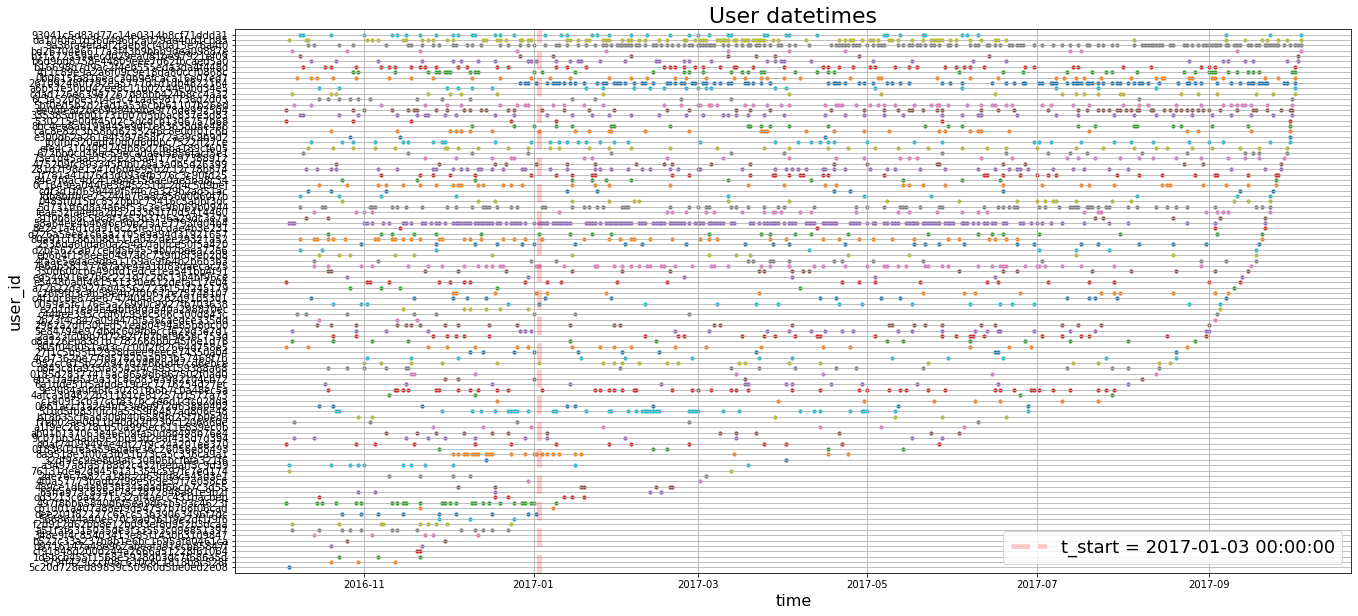

In [60]:
_print_user_times(100, fn_out = "results/users_datetime_100")

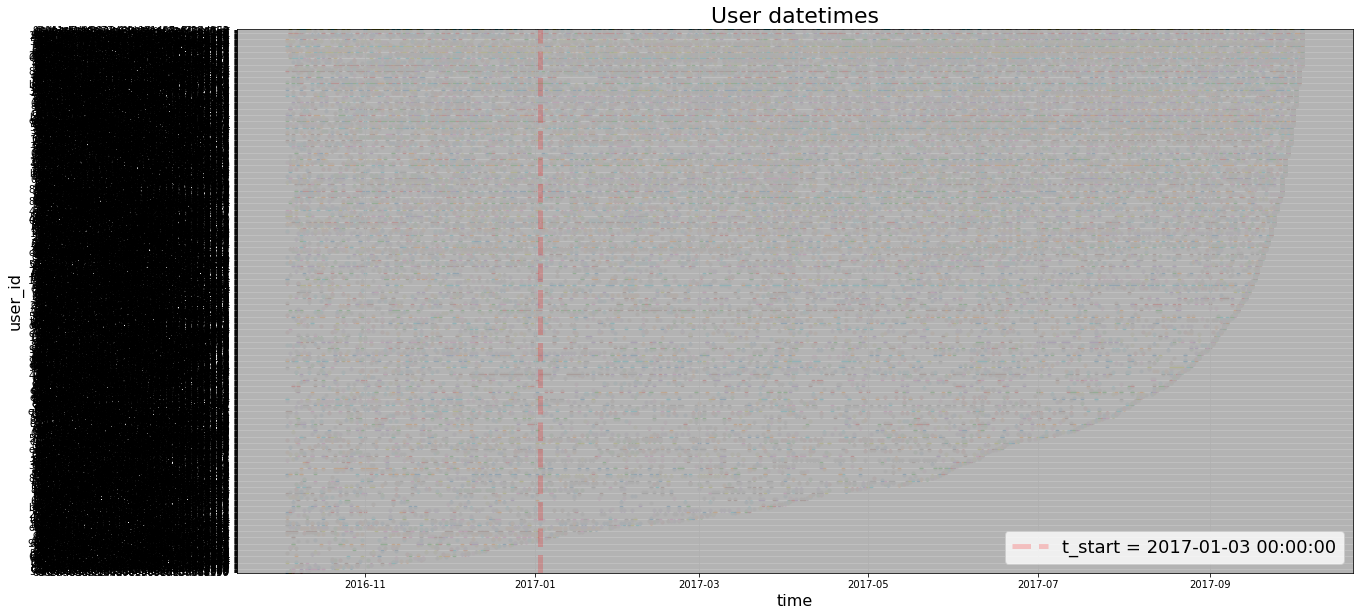

In [61]:
_print_user_times(1000, fn_out = "results/users_datetime_1000")

# Разработка методологии

##### Определения
Есть два вида клиентов: оставшися и ушедшие(churn).

Берутся две отсечки по времени (t1  и t2, t1<t2), рассматривается те клиенты, которые имеют хотя бы одну транзакцию после времени t1. 
Клиент, имевший хотя бы одну транзакцию после момента  времени t2
называется оставшимся, в ином случае клиент называется ушедшим.

##### Как будем выделять t1,t2 ?

Для определения резонных значений переменных t1 и t2 построим зависимость доли ушдедших клиентов от всех (от тех, которых мы учитываем для этой пары времен). На рис. Показан график зависимости, из которого заключим, что интервал в два месяца является оптимальным для определения оттока. 

##### Схеа валидации
Baseline модель будем строить по методу логистической регрессии. 
В качестве валидации разделим выборку в соотношении 
В качестве метрик качества построенной моднлт возьмем

#### Как валидируем модель (какая схема валидации, разделения пользователей) 
Также существует альтернативная версия валидации со временем: вместо разделения выборке на train и test решим задачу для двух разных пар времен t1 и t2. Исходя из предположения об относительном постоянстве паттернов данных, валидируем модель сравнением с выборкой данных, смещенных в прошлое на небольшой интервал. Этот подход может позволить обучить итоговую модель на всем корпусе данных.

Для оценки финального результата используются метрики ROC-AUC и precision-recall curve. Последняя из них нам актуальна, так как лучше интерпретируется с позиций бизнеса.


###  Как часто в среднем ходят в Ленту?


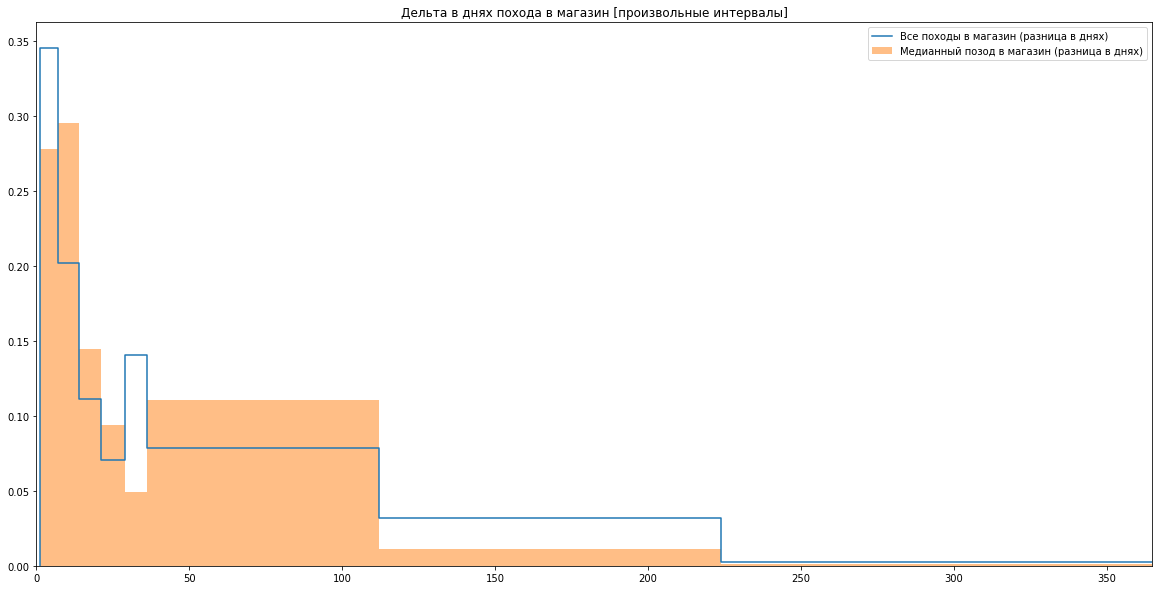

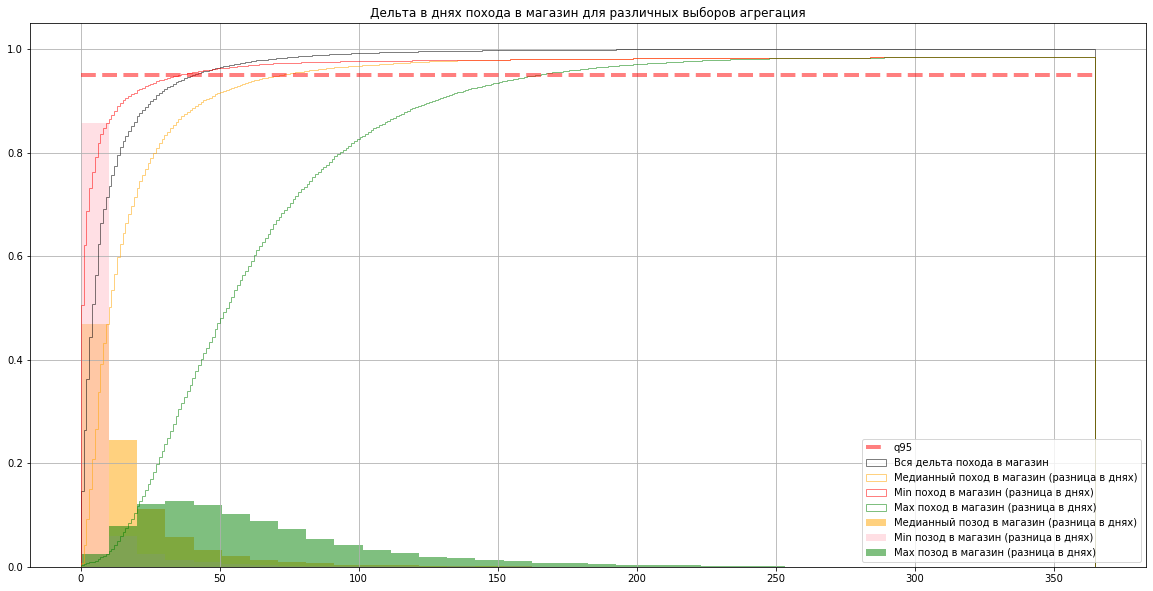

In [306]:
N = len(df_client)#.keys()
o = (df_client[['delta_bin_0_(1,)', 'delta_bin_1_(7,)', 'delta_bin_7_(14,)',
                'delta_bin_14_(21,)', 'delta_bin_21_(28,)', 'delta_bin_28_(56,)',
                'delta_bin_56_(112,)', 'delta_bin_112_(224,)', 'delta_bin_224_(448,)']].sum(axis = 0)/N)

x_list = [1,7,14,21,29,36,112,224, 448]
# print(len(o), len(x_list))
plt.figure(figsize = (20, 10))
plt.title('Дельта в днях похода в магазин [произвольные интервалы]')

plt.step(x_list, o.to_numpy(), label = 'Все походы в магазин (разница в днях)')
plt.hist(df_client['delta_median'],
         weights = np.ones(len(df_client))/len(df_client), 
         alpha = 0.5, bins = [0]+x_list,
         label = 'Медианный позод в магазин (разница в днях)')

plt.legend()
plt.xlim(0, 365)
plt.show()

plt.figure(figsize = (20, 10))

plt.title('Дельта в днях похода в магазин для различных выборов агрегация')
bins = np.linspace(0, 365, 365)

all_t_list = []
for i in df_client['_t_list'].apply(np.diff).to_numpy():
    all_t_list.extend(i)
    
all_t_list = diff_to_days(all_t_list)

plt.hist(all_t_list,
         weights = np.ones(len(all_t_list))/len(all_t_list), 
         alpha = 0.5, 
         color = 'black',histtype='step',
         bins = bins, cumulative=1,
         label = 'Вся дельта похода в магазин')

plt.hist(df_client['delta_median'],
         weights = np.ones(len(df_client))/len(df_client), 
         alpha = 0.5, 
         color = 'orange',histtype='step',
         bins = bins, cumulative=1,
         label = 'Медианный поход в магазин (разница в днях)')

plt.hist(df_client['delta_min'],
         weights = np.ones(len(df_client))/len(df_client), 
         alpha = 0.5, 
         color = 'red',histtype='step',
         bins = bins, cumulative=1,
         label = 'Min поход в магазин (разница в днях)')

plt.hist(df_client['delta_max'],
         weights = np.ones(len(df_client))/len(df_client), 
         alpha = 0.5, 
         color = 'green',histtype='step',
         bins = bins, cumulative=1,
         label = 'Max поход в магазин (разница в днях)')

bins = np.linspace(0, 365, 37)

plt.hist(df_client['delta_median'],
         weights = np.ones(len(df_client))/len(df_client), 
         alpha = 0.5, 
         color = 'orange',
         bins = bins, 
         label = 'Медианный позод в магазин (разница в днях)')

plt.hist(df_client['delta_min'],
         weights = np.ones(len(df_client))/len(df_client), 
         alpha = 0.5, 
         color = 'pink',
         bins = bins, 
         label = 'Min позод в магазин (разница в днях)')

plt.hist(df_client['delta_max'],
         weights = np.ones(len(df_client))/len(df_client), 
         alpha = 0.5, 
         color = 'green',
         bins = bins, 
         label = 'Max позод в магазин (разница в днях)')

plt.plot([0, 365], [0.95, 0.95],
         label = 'q95',
         linewidth = 4,
         linestyle = '--', 
         color = 'red', alpha = 0.5)
plt.grid()
plt.legend()
plt.show()

##### Из этого можно сделать вывод, что оптимальным значение t2-t1 должен лежать в диапазоне от 60 до 200 дней
##### Чтобы ошибка нашеq разметки была порядка 5%


Для простоты положим t1-t2 = 60 дней (два месяца)

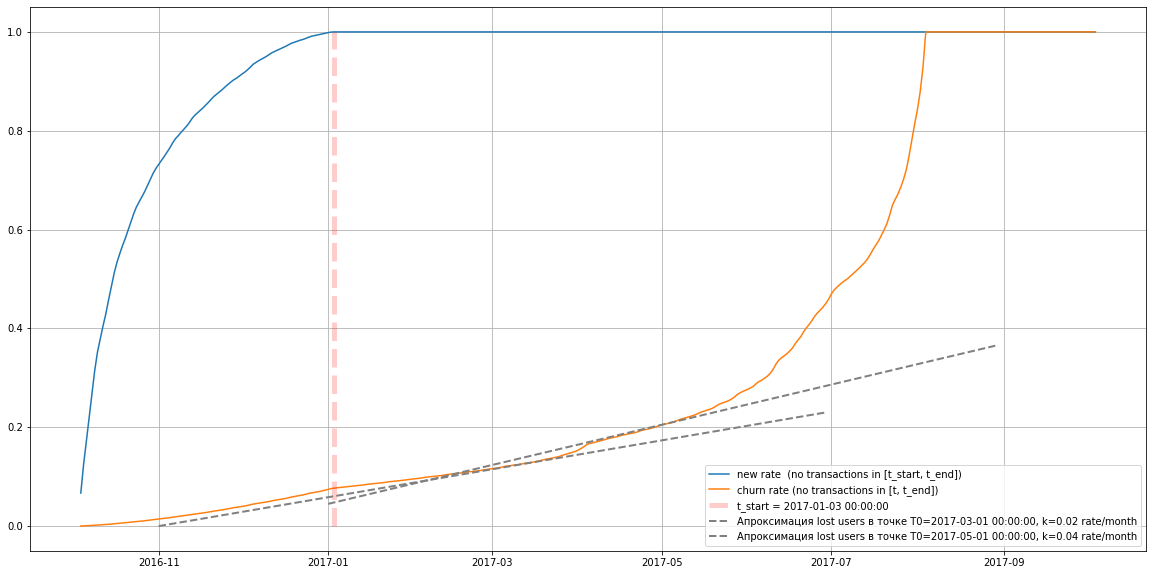

In [353]:
new_users   = []
lost_users = []
t_list = []
for t in list(sorted(df['chq_date'].drop_duplicates())):
    new_users.append((df_client['t_min']<=t).mean())
    lost_users.append((df_client['t_max']<=t).mean())
    t_list.append(t)
    
plt.figure(figsize = (20, 10))
plt.plot(pd.to_datetime(t_list), 
         new_users,  label = 'new rate  (no transactions in [t_start, t_end])')

plt.plot(pd.to_datetime(t_list), 
         lost_users, label = 'churn rate (no transactions in [t, t_end])')

plt.plot([t_data_start, t_data_start], 
         [0, 1], 
         label = f't_start = {t_data_start}',
         color = 'red', 
         linestyle = '--', 
         linewidth = 5,
         alpha = 0.2)

delta = 4
T0 = pd.to_datetime("2017-03")
k = 0.02
plt.plot([T0-timedelta(30*delta), T0+timedelta(30*delta)], 
         [0.08-delta*k, 0.15+delta*k],
         linestyle = '--',
         color = 'grey',
         linewidth = 2,
         label = f"Апроксимация lost users в точке T0={T0}, k={k} rate/month")

delta = 4
T0 = pd.to_datetime("2017-05")
k = 0.04
plt.plot([T0-timedelta(30*delta), T0+timedelta(30*delta)], 
         [0.205-delta*k, 0.205+delta*k],
         linestyle = '--',
         color = 'grey',
         linewidth = 2,
         label = f"Апроксимация lost users в точке T0={T0}, k={k} rate/month")

plt.legend()
plt.grid()
plt.show()

    new_users
    По накклону серидины оранжевой кривой можно судить онастоящем уходе пользователей
    Это примерно 2% в месяц (2000 пользователей в месяц)
    Через месяц это уже 4% в месяц (4000 пользователей в месяц)

#### Необходимо выбрать корректные отсечки для t1, t2

> Построим несколько графиков, может быть что-то станет яснее

In [ ]:
%%time
# Запускается долго
# [FILL TEXT], добавить картинку с ошибками

N_users     = {}
Churn_users = {}
# N_error     = {}

for t1 in tqdm.tqdm(list(sorted(df['chq_date'].unique())), 
                    total = df['chq_date'].nunique()):
    #print(t1)
    N_users[t1] = {}
    Churn_users[t1] = {}
    #N_error[t1] = {}
    
    for t2 in list(sorted(df['chq_date'].unique())):
        if t1>t2:
            continue
        
        #users_in_data = df_client[df_client['t_min']>t1, 'client_id']
        
        N_users[t1][t2]     = (df_client['t_max']>t1).sum()
        Churn_users[t1][t2] = (df_client[df_client['t_max']>t1]['t_max']<t2).sum()
        
print('Finish')

 28%|██▊       | 101/366 [18:14<38:07,  8.63s/it] 

In [67]:
df_client['_t_list2'] = df_client['_t_list'].apply(lambda x:np.array(x))
#.loc['0000d48a8891cd462fdf01ea861ec53e']

In [74]:
%%time
# Запускается долго
# [FILL TEXT], добавить картинку с ошибками

# N_users     = {}
# Churn_users = {}
N_error     = {}

fast_error_numpy = df_client['_t_list2'].to_numpy()
 

for t1 in tqdm.tqdm(list(sorted(df['chq_date'].unique()))[::30], total = df['chq_date'].nunique()/30):
    #print(t1)
    #N_users[t1] = {}
    #Churn_users[t1] = {}
    N_error[t1] = {}
    
    for t2 in list(sorted(df['chq_date'].unique()[::30])):
        if t1>t2:
            continue
        
        #users_in_data = df_client[df_client['t_min']>t1, 'client_id']
        
        #N_users[t1][t2]     = (df_client['t_max']>t1).sum()
        #Churn_users[t1][t2] = (df_client[df_client['t_max']>t1]['t_max']<t2).sum()
        
        #temp = df_client['_t_list']
        N_error[t1][t2] = np.sum([((i<t1)  | (i>t2)).all() and (np.max(i)>t2) for i in fast_error_numpy])
        #      ((df_client['t_max']>t1) & (df_client['_t_list'].apply(lambda lst: any([(t1<x) and (x<t2) 
        #                                                                                                   for x in lst])
        #                                                                                 ))).sum()
print('Finish')

  0%|          | 0/52.285714285714285 [00:12<?, ?it/s]


KeyboardInterrupt: 

#### Посмотрим на пользователей в выборке

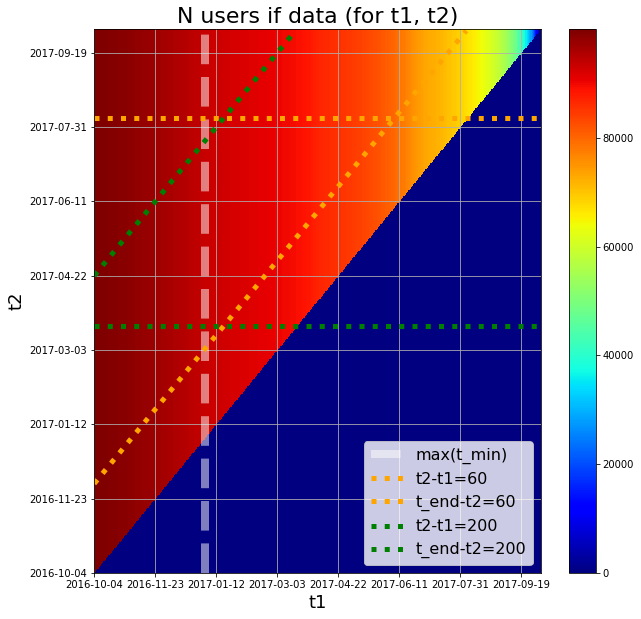

In [75]:
plt.figure(figsize = (10,10))
plt.title("N users if data (for t1, t2)", fontsize = 22)
plt.xlabel("t1", fontsize = 18)
plt.ylabel("t2", fontsize = 18)

t_list = list(sorted(df['chq_date'].drop_duplicates()))
M      = np.zeros((len(t_list), len(t_list)))
for c1, (k1, o1) in enumerate(N_users.items()):
    i1 = t_list.index(k1)
    for c2, (k2, v) in enumerate(o1.items()):
        i2 = t_list.index(k2)        
        M[i2, i1] = v
plt.pcolormesh(M, cmap=plt.cm.jet)
plt.xlabel
plt.colorbar()
plt.grid()
plt.xticks( range(len(t_list))[::50], [str(i)[:10] for i in t_list[::50]], fontsize = 10)
plt.yticks( range(len(t_list))[::50], [str(i)[:10] for i in t_list[::50]], fontsize = 10)

t_index_start = t_list.index(t_data_start)
plt.plot([t_index_start, t_index_start],
         [0, len(t_list)],
         '--', 
         label = 'max(t_min)', 
         linewidth = 8,
         alpha = 0.5,
         color = 'white')

for  clr, deltat1t2 in [['orange', 60], 
                        ['green', 200]]:
    t1_list = list(range(0, len(t_list)-deltat1t2))
    t2_list = [t+deltat1t2 for t in t1_list]
    plt.plot(t1_list, t2_list, 
             label = f't2-t1={deltat1t2}', 
             linestyle = ':', 
             linewidth = 5,
             #alpha = 0.6, 
             color = clr)
    
    plt.plot([0, len(t_list)],
            [len(t_list)-deltat1t2, len(t_list)-deltat1t2],
             label = f't_end-t2={deltat1t2}', 
             linestyle = ':', 
             linewidth = 5,
             #alpha = 0.6, 
             color = clr)
    


    
plt.legend(fontsize = (16), loc = 'lower right')
plt.show()

> Видно, что количество пользователей в выборке для обучения зависит только от t1

In [575]:
all([len(set(i.values()))==1 for i in N_users.values()])

NameError: name 'N_users' is not defined

In [77]:
list(list(N_users.items())[0][1].items())[0],\
list(list(N_users.items())[2][1].items())[0]

((numpy.datetime64('2016-10-04T00:00:00.000000000'), 99982),
 (numpy.datetime64('2016-10-06T00:00:00.000000000'), 99944))

> Скорее всего В интервале от 0 до max(t_min) Падает количество N_users в основном за счет пользователей только с одной покупкой
(купили карту и сразу ее потеряли)

In [ ]:
#Можно заметить, что есть пользователи только с одной транзакцией
df_client.loc['8f86d689f835936fb38187f1309719c5'].head()

#### Посмотрим на churn users

In [ ]:
plt.figure(figsize = (10,10))
plt.title("N churn users (for t1, t2)", fontsize = 22)
plt.xlabel("t1", fontsize = 18)
plt.ylabel("t2", fontsize = 18)

t_list = list(sorted(df['chq_date'].drop_duplicates()))
M      = np.zeros((len(t_list), len(t_list)))
for c1, (k1, o1) in enumerate(Churn_users.items()):
    i1 = t_list.index(k1)
    for c2, (k2, v) in enumerate(o1.items()):
        i2 = t_list.index(k2)        
        M[i2, i1] = v
plt.pcolormesh(M, cmap=plt.cm.jet)# cmap=cmap, rasterized=True, vmin=-4, vmax=4)
plt.xlabel
plt.colorbar()
plt.grid()
plt.xticks( range(len(t_list))[::50], [str(i)[:10] for i in t_list[::50]], fontsize = 10)
plt.yticks( range(len(t_list))[::50], [str(i)[:10] for i in t_list[::50]], fontsize = 10)

t_index_start = t_list.index(t_data_start)
plt.plot([t_index_start, t_index_start],
         [0, len(t_list)],
         '--', 
         label = 'max(t_min)', 
         linewidth = 8,
         alpha = 0.5,
         color = 'white')

for  clr, deltat1t2 in [['orange', 60], 
                        ['green', 200]]:
    t1_list = list(range(0, len(t_list)-deltat1t2))
    t2_list = [t+deltat1t2 for t in t1_list]
    plt.plot(t1_list, t2_list, 
             label = f't2-t1={deltat1t2}', 
             linestyle = ':', 
             linewidth = 5,
             #alpha = 0.6, 
             color = clr)
    
    plt.plot([0, len(t_list)],
            [len(t_list)-deltat1t2, len(t_list)-deltat1t2],
             label = f't_end-t2={deltat1t2}', 
             linestyle = ':', 
             linewidth = 5,
             #alpha = 0.6, 
             color = clr)
    


plt.legend(fontsize = (16), loc = 'lower right')
plt.show()

> В абсолютной величине количество пользователей которые считаются churn зввисит и от t1 и от t2

In [ ]:
plt.figure(figsize = (10,10))
plt.title("Churn rate (for t1, t2)", fontsize = 22)
plt.xlabel("t1", fontsize = 18)
plt.ylabel("t2", fontsize = 18)

t_list = list(sorted(df['chq_date'].drop_duplicates()))
M      = np.zeros((len(t_list), len(t_list)))
dct = {k1:{k2:v2/N_users[k1][k2] for k2, v2 in o.items()} 
       for k1,o in Churn_users.items()}

for c1, (k1, o1) in enumerate(dct.items()):
    i1 = t_list.index(k1)
    for c2, (k2, v) in enumerate(o1.items()):
        i2 = t_list.index(k2)        
        M[i2, i1] = v
        
plt.pcolormesh(M, cmap=plt.cm.jet)#, rasterized=True, vmin=-4, vmax=4)
plt.xlabel
plt.colorbar()
plt.grid()
plt.xticks( range(len(t_list))[::50], [str(i)[:10] for i in t_list[::50]], fontsize = 10)
plt.yticks( range(len(t_list))[::50], [str(i)[:10] for i in t_list[::50]], fontsize = 10)

t_index_start = t_list.index(t_data_start)
plt.plot([t_index_start, t_index_start],
         [0, len(t_list)],
         '--', 
         label = 'max(t_min)', 
         linewidth = 8,
         alpha = 0.5,
         color = 'white')

# Нарисуем график t2-t1 = 60, t2=t1+60
for  clr, deltat1t2 in [['orange', 60], 
                        ['green', 200]]:
    t1_list = list(range(0, len(t_list)-deltat1t2))
    t2_list = [t+deltat1t2 for t in t1_list]
    plt.plot(t1_list, t2_list, 
             label = f't2-t1={deltat1t2}', 
             linestyle = ':', 
             linewidth = 5,
             #alpha = 0.6, 
             color = clr)
    
    plt.plot([0, len(t_list)],
            [len(t_list)-deltat1t2, len(t_list)-deltat1t2],
             label = f't_end-t2={deltat1t2}', 
             linestyle = ':', 
             linewidth = 5,
             #alpha = 0.6, 
             color = clr)
    

plt.legend(fontsize = (16), loc = 'lower right')
plt.show()

In [ ]:
df['chq_date'].max()

Подъитожим:

        - Выбирая t1-t2 большим(например 150 дней, 200 дней не везают), мы получаем
        - Cильный дисбаланс классов и маленький размер выборки с churn
          
          На самом деле в задаче определения churn нас не столько интересуют уйдет пользователь или нет, 
          как ранжирующая способность определяющая вероятность - уйдет пользоватлеь или нет.
          Так как скорее всего результаты системы определения churn могут быть использованы:
            Для оптимизации call центра, уведомлений и других спослобов взаимодействия с клиентов
          Но от дисбаланса классов едет и качество модели и дисперсии многих метрик.
          Поэтому дисбаланс классов, это действительно важная проблема
            
        - В нашей разметке мы умешаяем количество FN (разметка что не churn, а подьзователь начал churn)
            
    - Выбирая t2 близко к t1
        - Модель учится на более свежих данных
        
        - Мы увеличиваем долю класса churn
          (Ведь на Самом деле, нас интересует повысить активность клиентов, а не определить churn)
        
        - В разметке уменьшаяем ошибки типо FP (разметка что churn, а на самом деле не churn) 

Можно  выбирать отсечки автоматически для каждого клиента, но это сильное усложнение задачи.
Из картинки 4 выше, если в среднем пользователь ходит в магазин раз в неделю, раз в год бывает что он не ходит в магазин два месяца.

Взвешивая все за и против, выберем посередине:
    
    - Нормальный баланс churn
    - чуть большую ошибку в целом (но все-де менее 5%) (больше ошибку разметки FP, )
    - уменьшаем ошибки FN
    - Из всего сказанного выше
    - Мы скорее всего получим чуть большую ранжирующую способность алгоритма
    - Три месяца это нормальный срок для предсказания (в банке просрочка по кредитам считается 30-90 дней)
    
    t_end          = 2017-10-04 (Конец выборки)
    t2             = 2017-07-06
    t1 = t_start   = 2016-10-04 (Начало выборки)

In [ ]:
### Создание модели и валидация

Окно для признаков стоит зафиксировать (потому-что если данные будут копится некоторые признаки поедут)
Либо все признаки должны не закисить от количества данных (нет функций сумм, есть функции mean)
Принципиально сздесь можно использовать два типа моделей

# Начнем моделировать

In [361]:
# Количество фродовых дней - 90
DAYS_CHURN = 90

In [308]:
# Мы считаем что churn, эти пользователи у которых нет транзакций в это время
t_end = df['chq_date'].max()
print(t_end)
t2 = t_end - timedelta(days = DAYS_CHURN)
print(t2)

2017-10-04 00:00:00
2017-07-06 00:00:00


#### По нашей методологии, какая доля churn_rate действительная ?

In [309]:
all_users_list       = df['client_id'].unique()
not_churn_users_list = df.loc[df['chq_date']>t2, 'client_id'].unique()
churn_users          = list(set(all_users_list)-set(not_churn_users_list)) 

print('Churn rate is %2.4f'%(len(churn_users)/len(all_users_list)))

Churn rate is 0.2716


In [354]:
df.keys()

Index(['chq_id', 'plant', 'chq_date', 'chq_position', 'client_id', 'material',
       'sales_count', 'sales_sum', 'is_promo', 'chq_id_sum_sales_count',
       'chq_id_len', 'chq_id_sum_sales_sum', 'chq_date(month)',
       'material__is_private_label', 'material__is_alco', 'material__is_food',
       'plant__is_SM', 'plant__is_city_St. Petersburg', 'plant__is_city_Other',
       'plant__is_city_Moscow', 'chq_id_material__is_private_label',
       'chq_id_material__is_alco', 'chq_id_material__is_food'],
      dtype='object')

In [355]:
%%time

def diff_to_days(x):
    return x / np.timedelta64(1, 's') / 60 / 60 / 24

def _get_features(data, t_start, t_end):
    data_no_duplicates = data.drop_duplicates("chq_id")
    data_negative      = data[data['sales_sum']<0]
    
    t_list = list(sorted(data_no_duplicates['chq_date'].unique()))
    deltas = diff_to_days(np.diff(t_list)) #интервалы между датами транзакций
    bins = [0, 1, 7, 14, 21, 28, 56, 112, 224, 448]
    res = {
           't_min'  : data['chq_date'].min(),          # Даты (первая, последняя и весь список)
           't_max'  : data['chq_date'].max(),  
           '_t_list' : t_list,
        
           'items_N'               : data['chq_id'].nunique(),              # Количество пробитых товаров
           'items_sales_sum_sum'   : data['sales_sum'].sum(),     # Сколько потратил
           'items_sales_count_sum' : data['sales_count'].sum(), # Сколько покупок сделал

           'items_N_negative' : data_negative['chq_id'].nunique(),              # Количество пробитых товаров
           'items_sales_sum_sum_negative':data_negative['sales_sum'].sum(),     # Сколько потратил
           'items_sales_count_sum_negative':data_negative['sales_count'].sum(), # Сколько покупок сделал
           
           "item_price_mean" : data['chq_id_sum_sales_count'].mean(), # Средняя цена товара
           "item_price_max"  : data['chq_id_len'].max(),              # Максимальная цена товара
           "item_price_min"  : data['chq_id_sum_sales_sum'].min(),    # Минимальная цена товара
           
        
           'chq_id_sum_sales_count_mean':data_no_duplicates['chq_id_sum_sales_count'].mean(),   # Средний количество покупок
           'chq_id_len_mean':data_no_duplicates['chq_id_len'].mean(),                           # Средее количнтво товаров
           'chq_id_sum_sales_sum_mean':data_no_duplicates['chq_id_sum_sales_sum'].mean(),       # Средняя цена товаров
                   
           'chq_id_sum_sales_count_min':data_no_duplicates['chq_id_sum_sales_count'].min(),  # То-же самое для минимума
           'chq_id_len_min':data_no_duplicates['chq_id_len'].min(),
           'chq_id_sum_sales_sum_min':data_no_duplicates['chq_id_sum_sales_sum'].min(),
            
           
           'chq_id_sum_sales_count_max':data_no_duplicates['chq_id_sum_sales_count'].max(), # То-же самое для максимума
           'chq_id_len_max':data_no_duplicates['chq_id_len'].max(),
           'chq_id_sum_sales_sum_max':data_no_duplicates['chq_id_sum_sales_sum'].max(),
        
           'promo_rate_count': (data['is_promo']==1).mean(),    # Доля промо
           'promo_rate_sales_sum': (data.loc[(data['is_promo']==1), 'sales_sum'].sum()+1)/(data['sales_sum'].sum()+1),
           'promo_rate_sales_count': (data.loc[(data['is_promo']==1), 'sales_count'].sum()+1)/(data['sales_count'].sum()+1),
        
            "delta_median" : np.median(deltas) if len(deltas)>0 else np.nan, # 
            "delta_min"    : np.min(deltas) if len(deltas)>0 else np.nan,
            "delta_max"    : np.max(deltas) if len(deltas)>0 else np.nan,
            "delta_std"    : np.std(deltas) if len(deltas)>0 else np.nan,
            "delta_moda"   : np.argmax(np.bincount(deltas.astype(int))) if len(deltas)>0 else np.nan,
          }
    
    # Признаки сколько активности пользователя по дням
    res['days_from_start'] = (res['t_min']-t_start).days
    res['days_until_end']  = (t_end-res['t_max']).days
    res['days_max']        = (res['t_max']-res['t_min']).days
    
    # Последний поход в магазин
    res['deltas_-1'] = deltas[-1] if len(deltas)>0 else np.nan
    res['deltas_-2'] = deltas[-2] if len(deltas)>1 else np.nan
    res['deltas_-1_frac_-2'] = deltas[-2]/deltas[-1]if len(deltas)>1 else np.nan
    
    # Признаки про магазин
    for key in ['plant__is_SM', 'plant__is_city_St. Petersburg', 'plant__is_city_Other', 'plant__is_city_Moscow']:
        res[key+"_mean"] = data_no_duplicates[key].mean()
                
    # Признаки про товар
    for key in ['chq_id_material__is_private_label', 'chq_id_material__is_alco', 'chq_id_material__is_food']:
        res[key+"_mean"] = data_no_duplicates[key].mean()
                
    # Средняя цена покупки
    res['chq_id__average_transaction'] = res['chq_id_sum_sales_sum_mean'] / res['chq_id_sum_sales_count_mean']

    # Позитивные транзакции
    res['items_N_positive']               = res['items_N']-res['items_N_negative']
    res['items_sales_sum_sum_positive']   = res['items_sales_sum_sum']-res['items_sales_sum_sum_negative']
    res['items_sales_count_sum_positive'] = res['items_sales_count_sum']-res['items_sales_count_sum_negative']
    
    
    # Отношение негативного к позитивному
    ##res['negative_pos_rate_len_positive'] = res['negative_pos_rate_len']  -res['negative_pos_rate_len_negative']  
    for l in range(1, len(bins)):
        res[f'delta_bin_{bins[l-1]}_{bins[l],}'] = np.mean([((bins[l-1]<=x) and (x<bins[l]))  for x in deltas])
    
    
    for c in range(2):
        res[f'plant_key_{c}'] = np.nan
        res[f'plant_val_{c}'] = np.nan 
        res[f'material_key_{c}'] = np.nan
        res[f'material_val_{c}'] = np.nan 
        
    res['plant_N']    = data['plant'].nunique()
    res['material_N'] = data_no_duplicates['material'].nunique()
    
    # Самые популярные города по количеству и из доля
    for c, (key, val) in enumerate(data_no_duplicates['plant'].value_counts(True).to_dict().items()):
        if c>=2:
            break

        res[f'plant_key_{c}'] = key
        res[f'plant_val_{c}'] = val     
    #два топовых магазина для юзера
        
    # Самые популярные товары по количеству и из доля    
    for c, (key, val) in enumerate(data['material'].value_counts(True).to_dict().items()):
        if c>=2:
            break
            
        res[f'material_key_{c}'] = key
        res[f'material_val_{c}'] = val  
    
    # Добавить join на metrials из таблицы 'materials.txt'
    # Добавить join на plant из таблицы пользователей если для каждого магазина взять максимальное количество пользователей с городом, это должно помоч

    return pd.Series(res)  

# _get_features(df[:100])

# test on 1 user
# user_sample = ["1a47d62dddacc03fe90c15652f7ae1a4"]#df['client_id'].sample(5000, random_state = 42).to_numpy()
# res = df[df['client_id'].isin(user_sample)].groupby('client_id').apply(lambda x:_get_features(x, 
#                                                                                              pd.to_datetime('2019.01.01'),
#                                                                                              pd.to_datetime('2019.01.01')))

# test on 5000 users
# user_sample = df['client_id'].sample(500, random_state = 42).to_numpy()
# res = df[df['client_id'].isin(user_sample)].groupby('client_id').apply(lambda x:_get_features(x, 
#                                                                                              pd.to_datetime('2019.01.01'),
#                                                                                              pd.to_datetime('2019.01.01')))
# _get_features(df[df['client_id'].isin(user_sample)], 
#               pd.to_datetime('2019.01.01'),
#               pd.to_datetime('2019.01.01')
#              )
# res = df[df['client_id'].isin(user_sample)].groupby('client_id').apply(lambda x:_get_features(x, 
#                                                                                              pd.to_datetime('2019.01.01'),
#                                                                                              pd.to_datetime('2019.01.01')))
# 

# res
# df_client = df.groupby('client_id').apply(_get_features)
# df_client['client_id'] = df_client.index
# print('Finish calculating')

# df_client.to_parquet("results/df_client_id.parquet")
# df_client

CPU times: user 51 µs, sys: 0 ns, total: 51 µs
Wall time: 63.4 µs


In [356]:
def to_data(df):
    t_start = df['chq_date'].min()
    t_end   = df['chq_date'].max()

    df_client = df.groupby('client_id').apply(lambda o:_get_features(o, t_start, t_end))
    
    df_client_raw = pd.read_csv('clients.csv')
    df_client = df_client.join(df_client_raw.set_index("client_id"))
    
    def foo(x):
        if not isinstance(x, str):
            return 0
        elif x == 'M':
            return 1
        elif x == 'F':
            return -1
        else :
            raise ValueError('Strange type for "gender"')
            
    df_client['is_male'] = df_client['gender'].apply(lambda x: foo(x))
    
    df_client['age'] = 2017 - df_client['birthyear']
    
    # Добавим признак странный год
    df_client['age_correct'] = ((df_client['age']<0) | (df_client['age']>80)).astype(int)

    df_client['is_na(all)'] = df_client.isna().sum(axis = 1)
    
    features = ["items_N", "items_N_negative", "item_price_max", "chq_id_len_min",
            "chq_id_len_max", "items_N_positive", "items_sales_sum_sum", "items_sales_count_sum", 
            "items_sales_sum_sum_negative", "items_sales_count_sum_negative", 
            "item_price_mean", "item_price_min", "chq_id_sum_sales_count_mean",
            "chq_id_len_mean", "chq_id_sum_sales_sum_mean", "chq_id_sum_sales_count_min",
            "chq_id_sum_sales_sum_min", "chq_id_sum_sales_count_max", "chq_id_sum_sales_sum_max", 
            "promo_rate_count", "promo_rate_sales_sum", "promo_rate_sales_count", "delta_median", 
            "delta_min", "delta_max", "delta_std", "delta_moda", "items_sales_sum_sum_positive", 
            "items_sales_count_sum_positive", "delta_bin_0_(1,)", "delta_bin_1_(7,)", "delta_bin_7_(14,)",
            "delta_bin_14_(21,)", "delta_bin_21_(28,)", "delta_bin_28_(56,)", "delta_bin_56_(112,)",
            "delta_bin_112_(224,)", "delta_bin_224_(448,)", "plant_val_0", "material_val_0", "plant_val_1", 
            "material_val_1", "birthyear", "is_male", "age", "age_correct", "is_na(all)"]

    df_client['is_na(features)'] = df_client[features].isna().sum(axis = 1)

    return df_client

In [419]:
data['items_N_positive_frac'] = data['items_N_positive'] / data['items_N']
data['items_frac_sales_sum_sum_negative'] = data['items_sales_sum_sum_negative'] / data['items_sales_sum_sum']
data['items_frac_sales_count_sum_negative'] = data['items_sales_count_sum_negative'] / data['items_sales_count_sum']


In [420]:
data.to_parquet('results/data_3month_old_features.parquet')

In [360]:
%%time
data = to_data(df[df['chq_date']<t2])#.groupby('client_id').apply(_get_features)

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 27min 9s, sys: 16.9 s, total: 27min 25s
Wall time: 27min 22s


In [374]:
data['client_id'] = data.index.tolist()
data['y'] = data['client_id'].isin(churn_users).astype(int)

### Краткая визуализация наших признаков

In [375]:
print(Counter([i.split('_')[0] for i in features]))

Counter({'delta': 14, 'items': 9, 'chq': 9, 'item': 3, 'promo': 3, 'is': 3, 'plant': 2, 'material': 2, 'age': 2, 'birthyear': 1})


In [376]:
data.dtypes.astype(str).unique()

array(['datetime64[ns]', 'object', 'int64', 'float64'], dtype=object)

In [377]:
_normal_dtypes = ['int64', 'float64', 'bool']
features_with_normal_types = data.dtypes.astype(str)
features_with_normal_types = features_with_normal_types[features_with_normal_types.isin(_normal_dtypes)].index
features_with_normal_types = list(sorted(features_with_normal_types))

features_with_normal_types.remove('y')

In [394]:
print(len(features_with_normal_types))

63


['plant_N', 'plant__is_SM_mean', 'plant__is_city_Moscow_mean', 'plant__is_city_Other_mean', 'plant__is_city_St. Petersburg_mean']


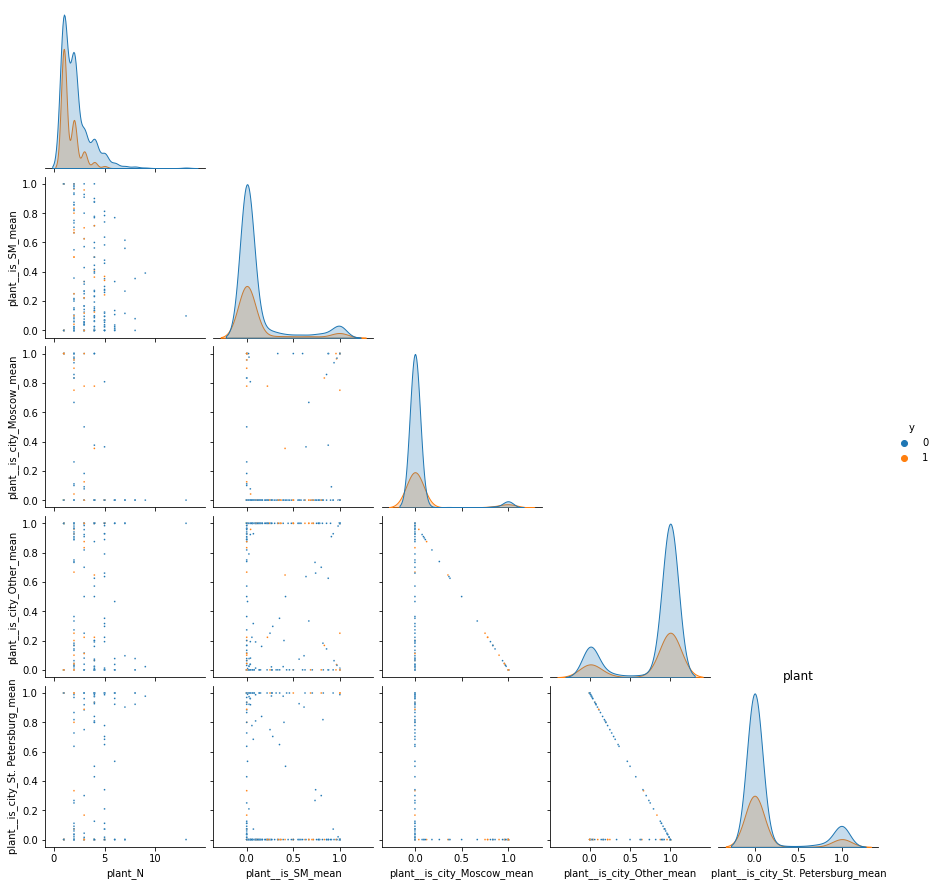

['delta_bin_0_(1,)', 'delta_bin_112_(224,)', 'delta_bin_14_(21,)', 'delta_bin_1_(7,)', 'delta_bin_21_(28,)']


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


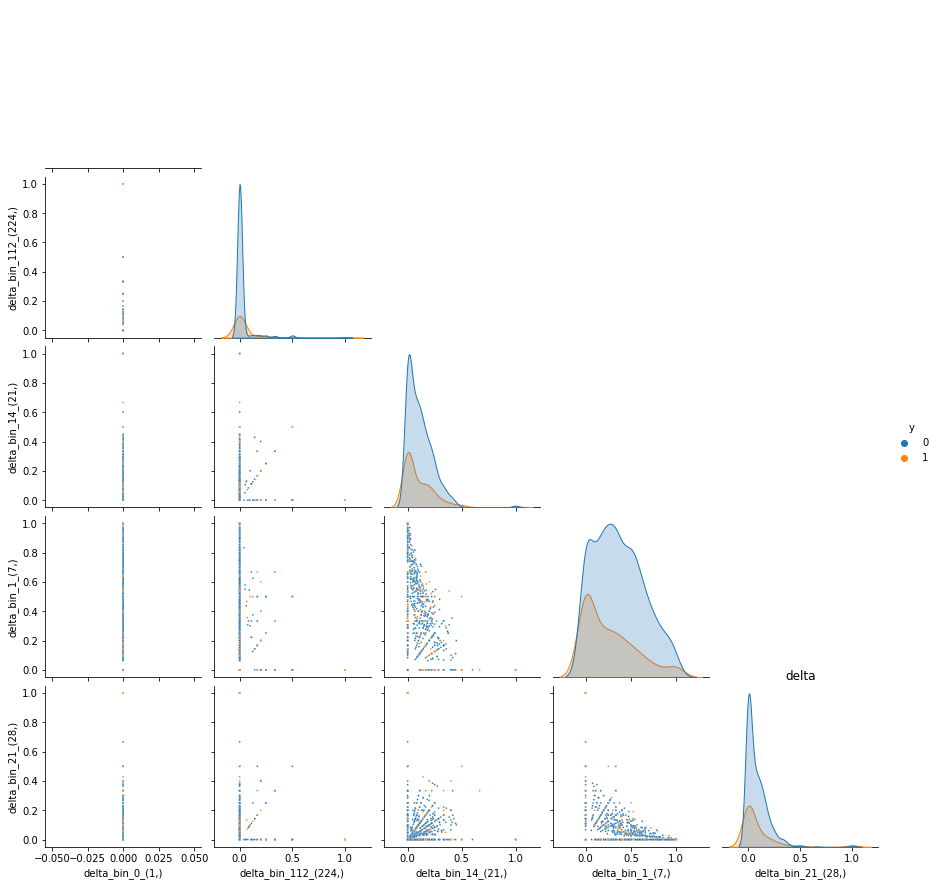

['item_price_max', 'item_price_mean', 'item_price_min', 'items_N', 'items_N_negative']


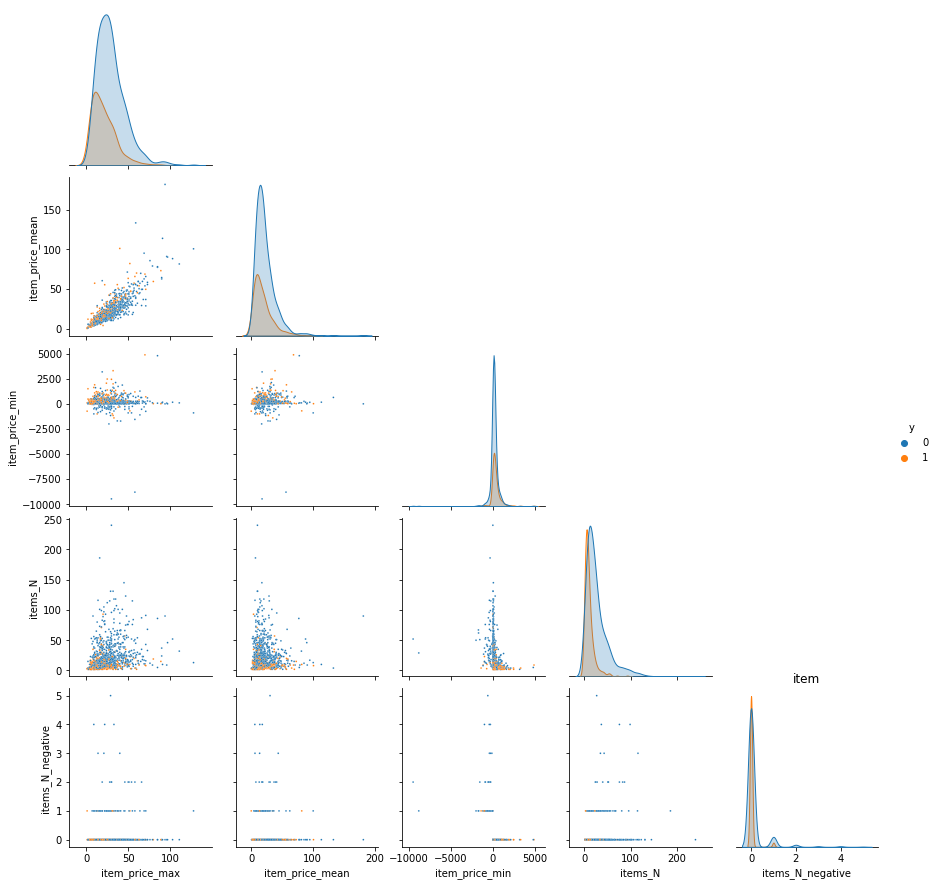

['promo_rate_count', 'promo_rate_sales_count', 'promo_rate_sales_sum']


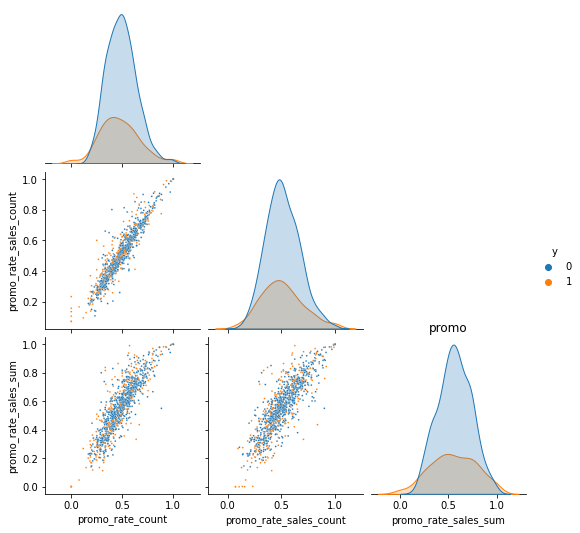

['chq_id__average_transaction', 'chq_id_len_max', 'chq_id_len_mean', 'chq_id_len_min', 'chq_id_material__is_alco_mean']


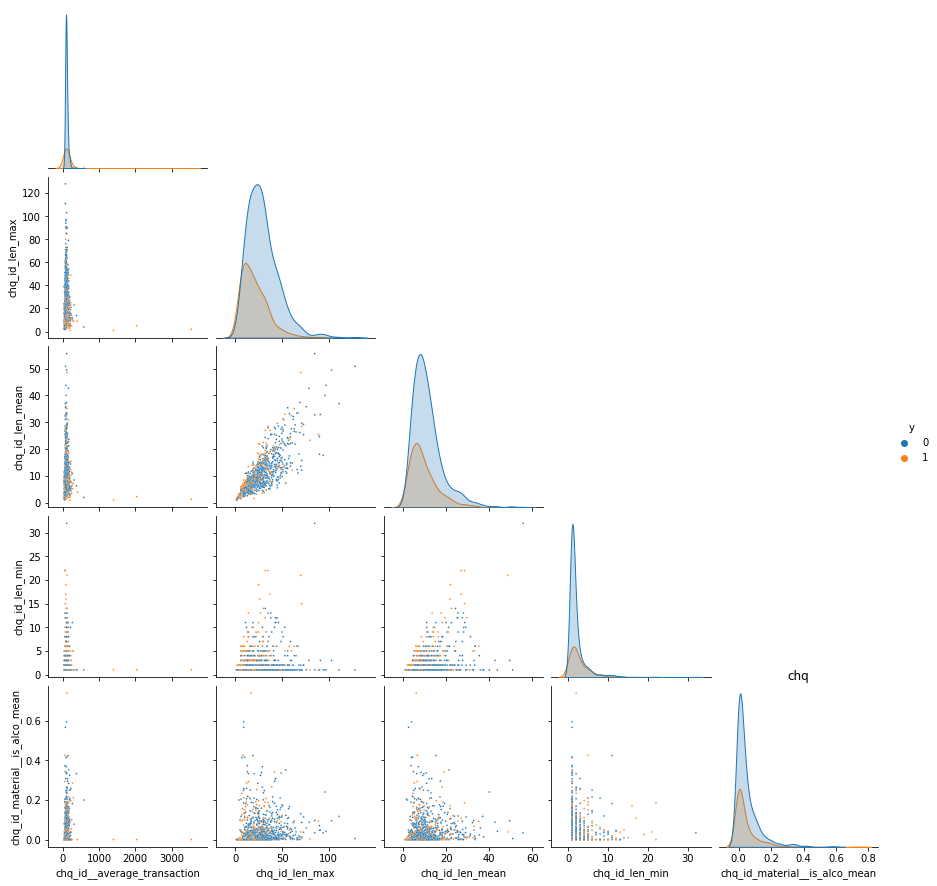

['items_N', 'items_N_negative', 'items_N_positive', 'items_sales_count_sum', 'items_sales_count_sum_negative']


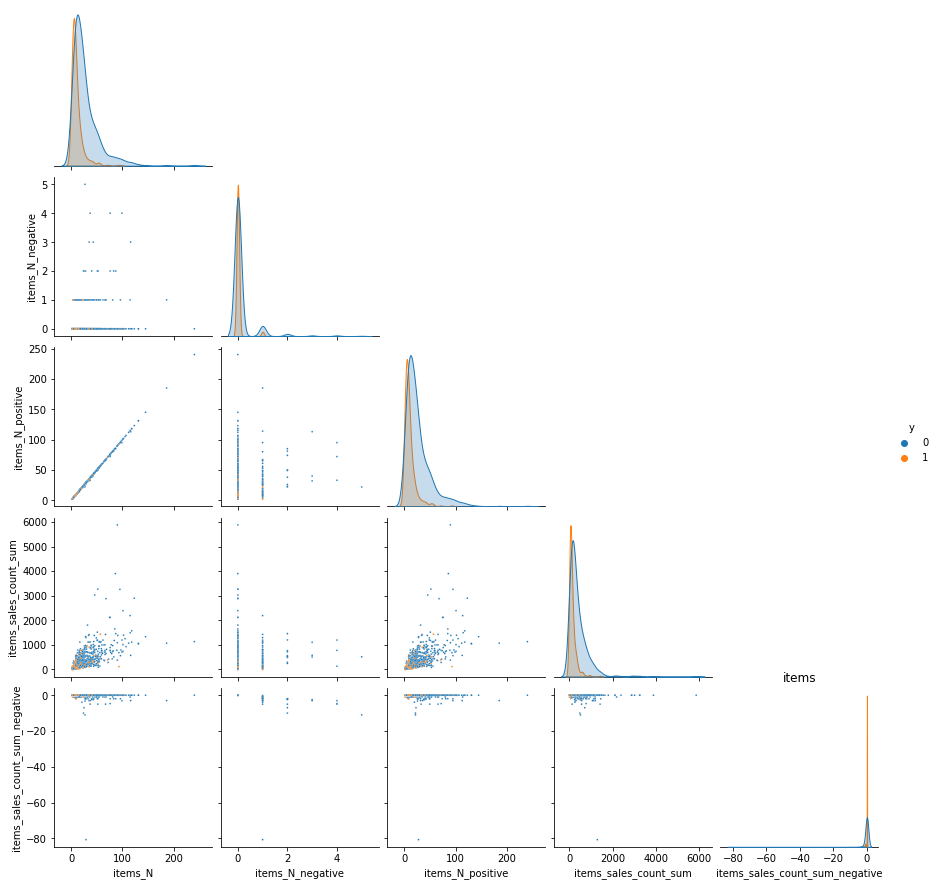

['material_N', 'material_val_0', 'material_val_1']


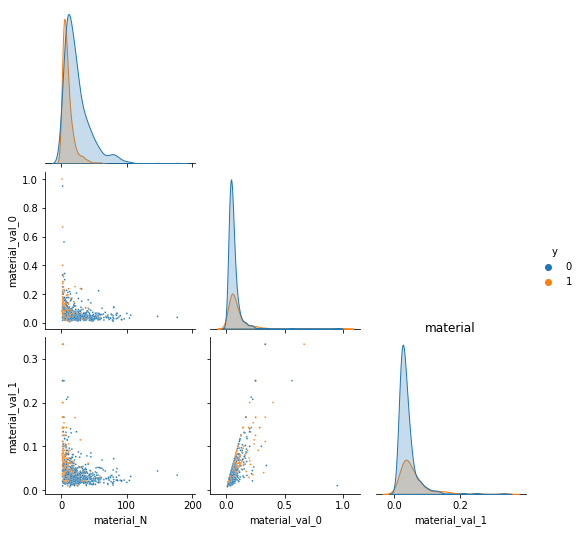

['is_male', 'is_na(all)', 'is_na(features)']


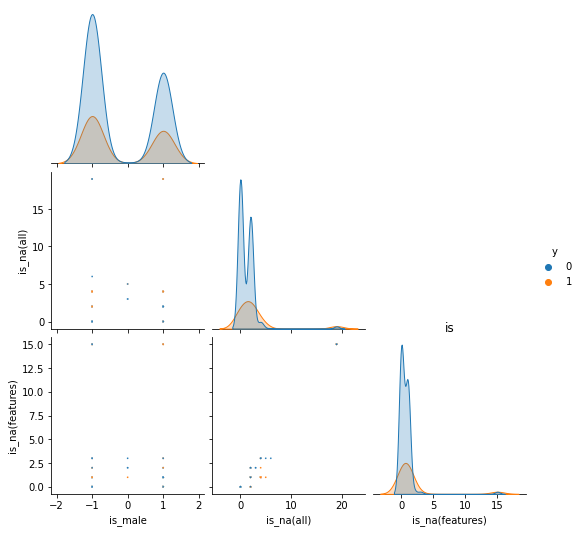

['y']


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [378]:
%%time
for pref in set([i.split('_')[0] for i in features_with_normal_types]):
    features_draw = [i for i in features_with_normal_types if i.startswith(pref)]
    print(features_draw)
    # features_draw = ["items_N", "items_sales_sum_sum", "items_sales_count_sum"]
    sns.pairplot(data[:1000][features_draw+['y']], 
                 corner=True, 
                 diag_kind="kde",
                 hue='y', plot_kws={"s": 3})
    plt.title(pref)
    plt.savefig(f'results/pairplot_{pref}.png')
    plt.show()

> Яснее не стало

In [390]:
data[features_with_normal_types].fillna(data[features_with_normal_types].mean()).corr().isna().sum().sort_values()

age                        1
deltas_-1_frac_-2          1
deltas_-2                  1
is_male                    1
is_na(all)                 1
                          ..
delta_max                  1
delta_median               1
promo_rate_sales_count     1
promo_rate_sales_sum       1
delta_bin_0_(1,)          64
Length: 64, dtype: int64

#### Матрика корреляций признаков (понадобится позже)

In [391]:
for key in ["delta_bin_0_(1,)"]:
    del data[key]
    features_with_normal_types.remove(key)

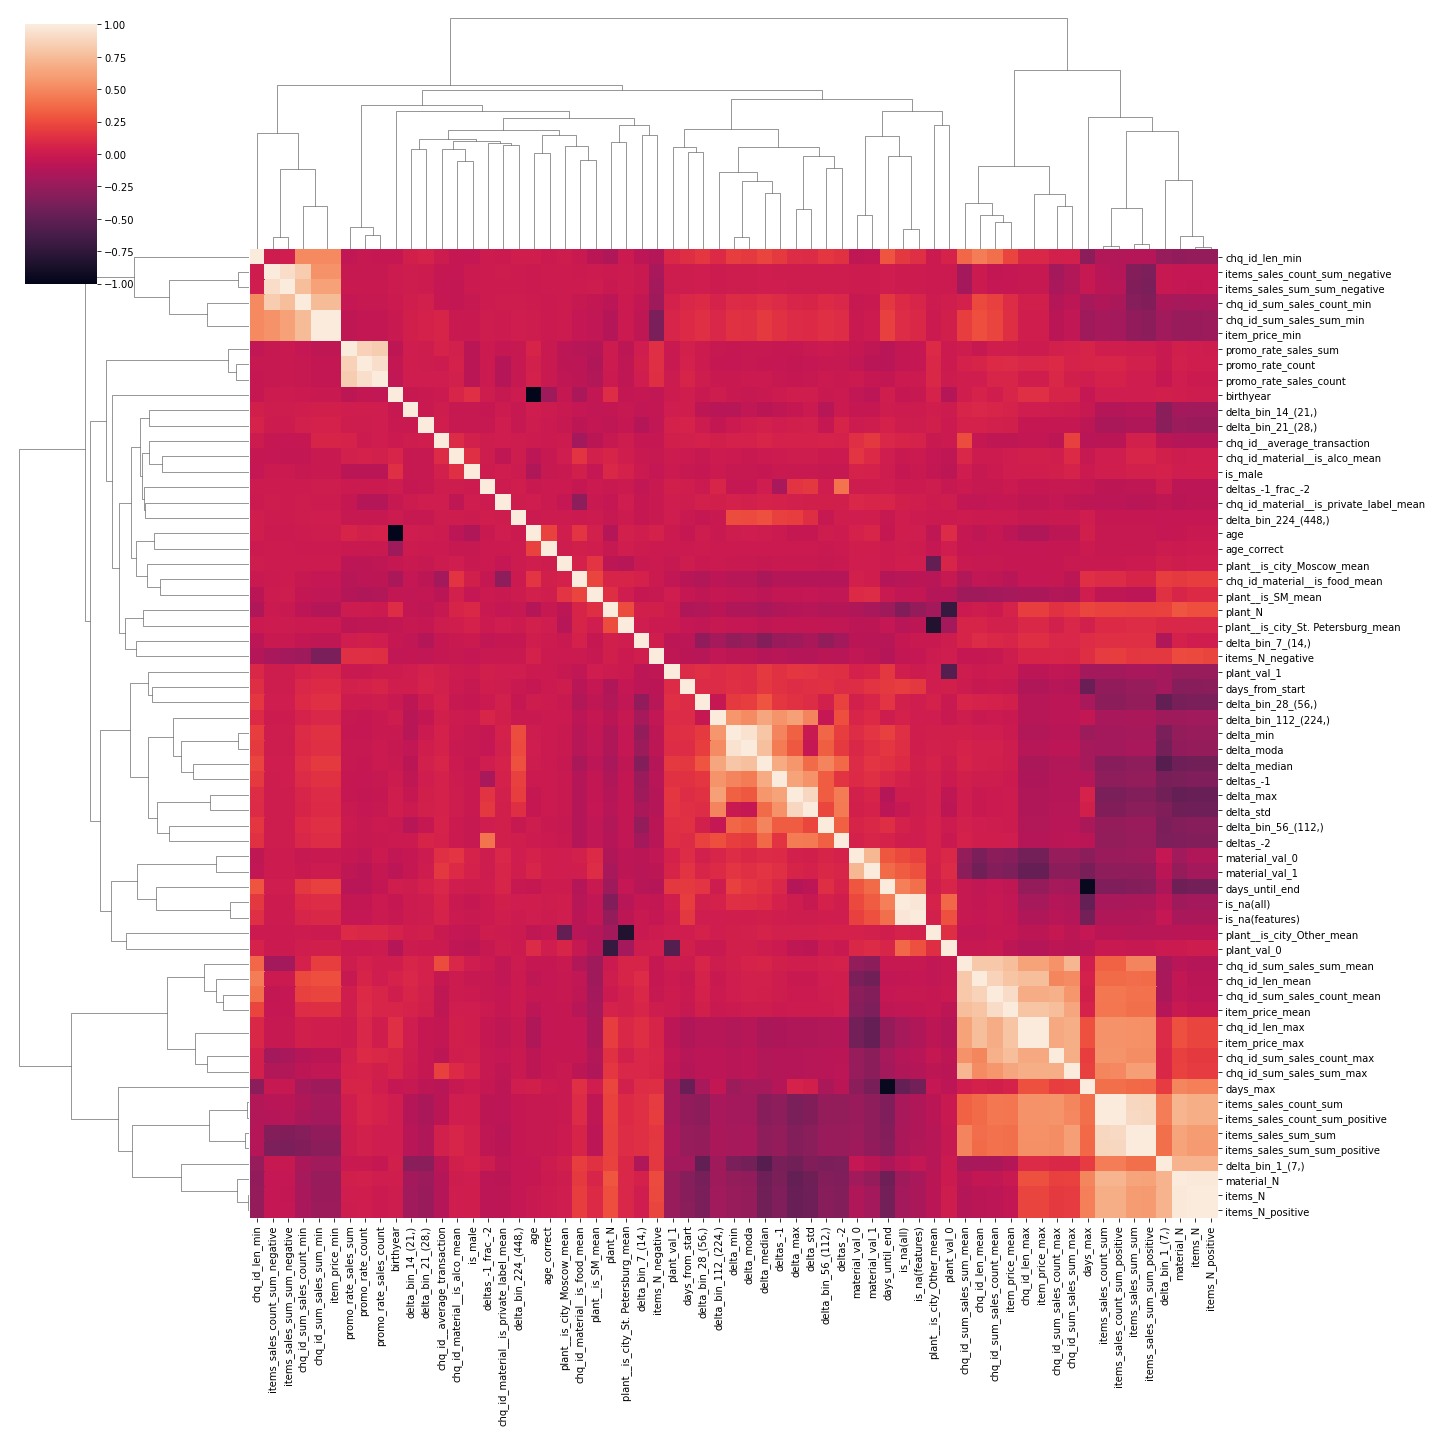

In [393]:
sns.clustermap(data[features_with_normal_types].fillna(data[features_with_normal_types].mean()).corr(), figsize = (20, 20))
plt.savefig('results/corr_matrix.png')
plt.show()

In [ ]:
data['']

> Будем смотреть на эту табличку во время feature selection

In [396]:
features = features_with_normal_types

#### Создадим обучающую и тестовую выборки

In [443]:
# stratify list creation
o = set(churn_users)
stratify_y = [int(i in o) for i in tqdm.tqdm(all_users_list)]

100%|██████████| 100000/100000 [00:00<00:00, 920613.08it/s]


In [448]:
data['client_id'] = data.index.tolist()
data['y'] = data['client_id'].isin(churn_users).astype(int)

train_users, test_users, _, _ = train_test_split(all_users_list, 
                                                 all_users_list,
                                                 stratify=stratify_y,
                                                 test_size = 0.3,
                                                 random_state = 42)

df_train = data.loc[train_users, features]
df_test  = data.loc[test_users,  features]

y_train = data.loc[train_users, 'y']
y_test  = data.loc[test_users,  'y']

X_train = df_train.fillna(df_train.mean())
X_test  = df_test.fillna(df_test.mean())

# X_train = df_train.fillna(df_train.mean())

In [449]:
print("y_train.mean()", y_train.mean())
print("y_test.mean()", y_test.mean())

y_train.mean() 0.2715714285714286
y_test.mean() 0.2715666666666667


In [450]:
def validate(p_test, p_train, y_test, y_train, feature_importance):
    print('train')
    print('roc_auc %2.3f'%roc_auc_score(y_train, p_train))
    print(classification_report(y_train, p_train>0.5))

    print('test')
    print('roc_auc %2.3f'%roc_auc_score(y_test, p_test))
    print(classification_report(y_test, p_test>0.5))



    plt.figure(figsize = (20, 10))
    plt.title('precision-recall')
    precision, recall, thresholds = precision_recall_curve(y_test, p_test)
    plt.step(recall, precision, label = 'test', where='post')

    precision, recall, thresholds = precision_recall_curve(y_train, p_train)
    plt.step(recall, precision, label = 'train', where='post')

    plt.legend()
    plt.xlabel('Recall', fontsize = 16)
    plt.ylabel('Precision', fontsize = 16)
    plt.grid()
    plt.legend(fontsize = 22)
    plt.show()

    plt.figure(figsize = (20, 10))
    n = len(feature_importance)
    plt.title("Feature importances")
    plt.barh(range(n), 
             list(feature_importance.values()),
             color="r",
             align="center")
    # If you want to define your own labels,
    # change indices to a list of labels on the following line.
    plt.yticks(range(n), list(feature_importance.keys()))
    plt.ylim([-1, n])
    plt.grid()
    plt.show()

##### global

In [451]:
global_res = {}

#### logistic regression (l2)

train
roc_auc 0.835
              precision    recall  f1-score   support

           0       0.82      0.91      0.87     50990
           1       0.67      0.48      0.56     19010

    accuracy                           0.79     70000
   macro avg       0.75      0.69      0.71     70000
weighted avg       0.78      0.79      0.78     70000

test
roc_auc 0.837
              precision    recall  f1-score   support

           0       0.82      0.91      0.87     21853
           1       0.67      0.48      0.56      8147

    accuracy                           0.79     30000
   macro avg       0.75      0.69      0.71     30000
weighted avg       0.78      0.79      0.78     30000



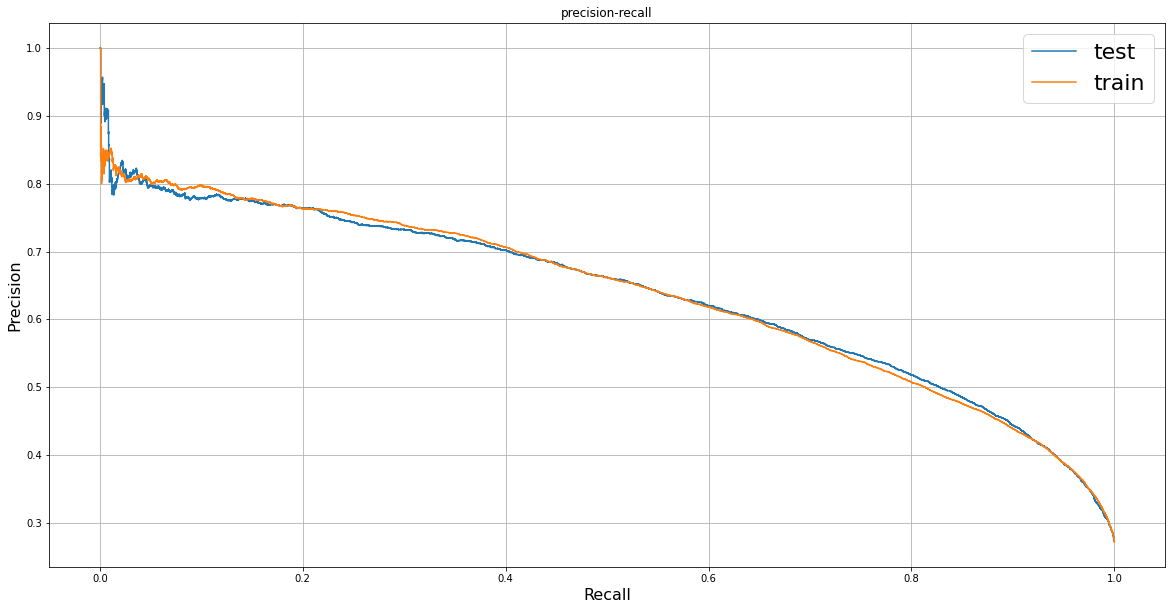

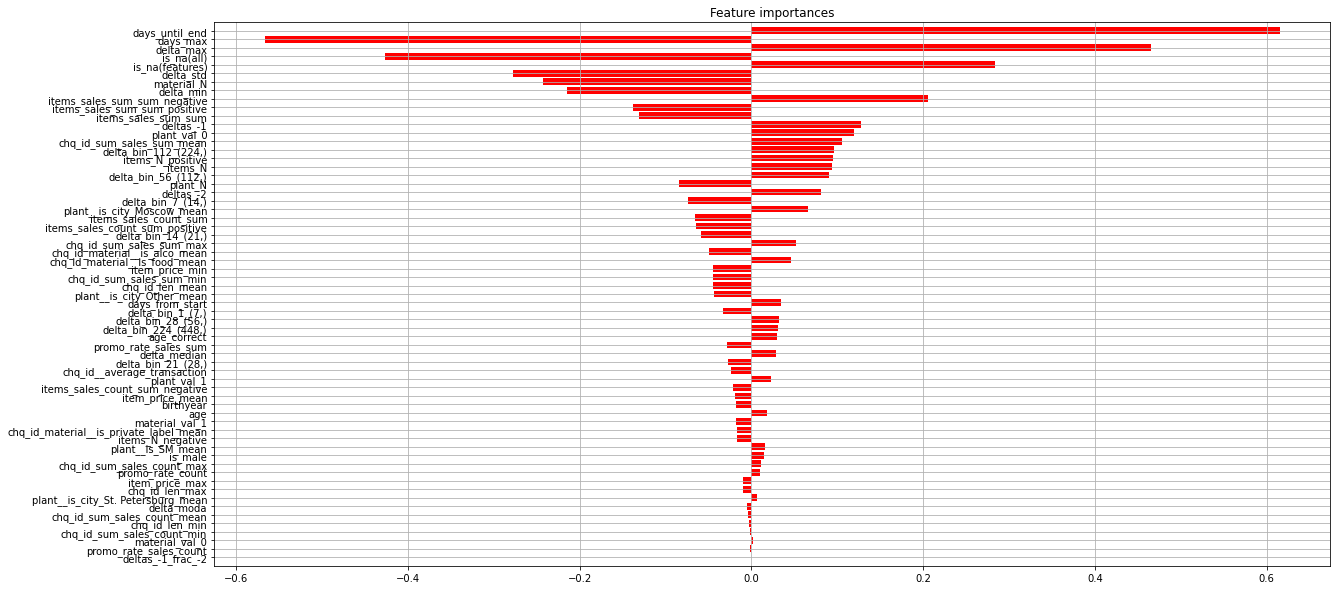

In [452]:
name = 'LR(l2)'
model = make_pipeline(StandardScaler(),
                      LogisticRegression(penalty='l2'))

model.fit(X_train.to_numpy(), y_train)


p_train = model.predict_proba(X_train)[:, 1]
p_test  = model.predict_proba(X_test)[:, 1]

feature_importance = {k:v for k,v in sorted(zip(features, model.steps[1][1].coef_[0]), key = lambda x:abs(x[1]))}
global_res[name] = {'p_test':p_test,
                     'p_train':p_train,
                     'y_test':y_test,
                     'y_train':y_train,
                     'feature_importance':feature_importance
                    }

validate(p_test, p_train, y_test, y_train, feature_importance)

##### ligistic regression (l1)

train
roc_auc 0.836
              precision    recall  f1-score   support

           0       0.82      0.91      0.87     50990
           1       0.67      0.47      0.55     19010

    accuracy                           0.79     70000
   macro avg       0.75      0.69      0.71     70000
weighted avg       0.78      0.79      0.78     70000

test
roc_auc 0.838
              precision    recall  f1-score   support

           0       0.82      0.91      0.87     21853
           1       0.67      0.47      0.55      8147

    accuracy                           0.79     30000
   macro avg       0.75      0.69      0.71     30000
weighted avg       0.78      0.79      0.78     30000



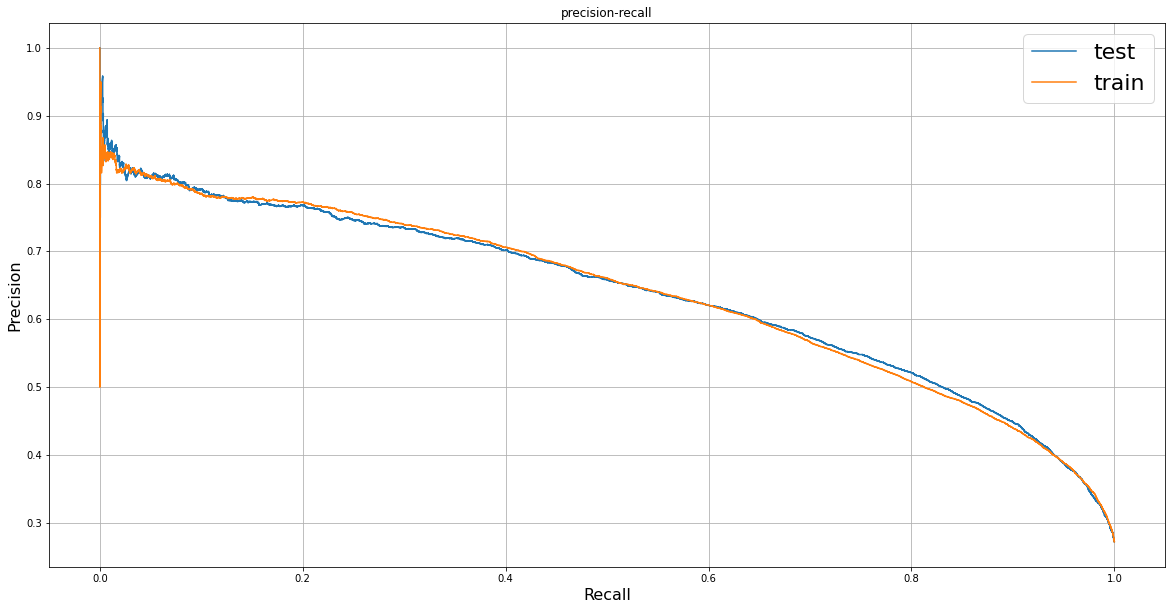

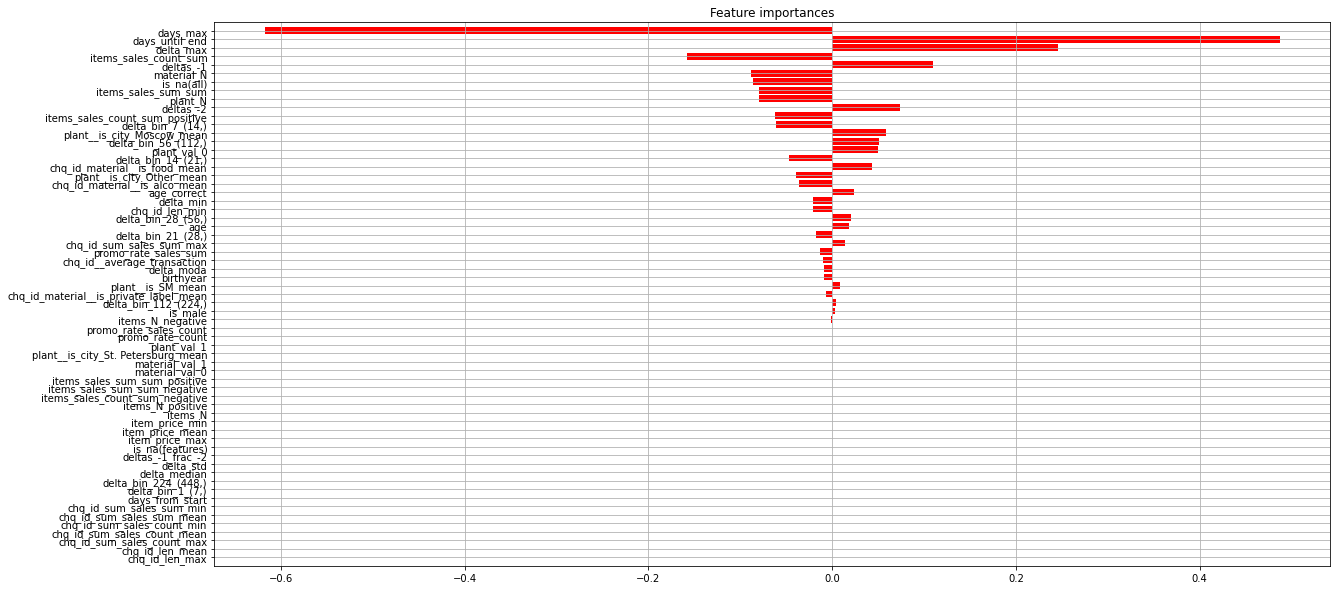

In [453]:
name = 'LR(l1, C=0.01)'
model = make_pipeline(StandardScaler(),
                      LogisticRegression(penalty='l1',
                                         C = 0.01,
                                         solver = 'liblinear'))

model.fit(X_train.to_numpy(), y_train)


p_train = model.predict_proba(X_train)[:, 1]
p_test  = model.predict_proba(X_test)[:, 1]


feature_importance = {k:v for k,v in sorted(zip(features, model.steps[1][1].coef_[0]), key = lambda x:abs(x[1]))}
global_res[name] = {'p_test':p_test,
                     'p_train':p_train,
                     'y_test':y_test,
                     'y_train':y_train,
                     'feature_importance':feature_importance
                    }

validate(p_test, p_train, y_test, y_train, feature_importance)

#### Logistic regression l1 (balanced)

train
roc_auc 0.836
              precision    recall  f1-score   support

           0       0.88      0.79      0.83     50990
           1       0.56      0.72      0.63     19010

    accuracy                           0.77     70000
   macro avg       0.72      0.75      0.73     70000
weighted avg       0.79      0.77      0.78     70000

test
roc_auc 0.838
              precision    recall  f1-score   support

           0       0.88      0.79      0.83     21853
           1       0.56      0.72      0.63      8147

    accuracy                           0.77     30000
   macro avg       0.72      0.76      0.73     30000
weighted avg       0.80      0.77      0.78     30000



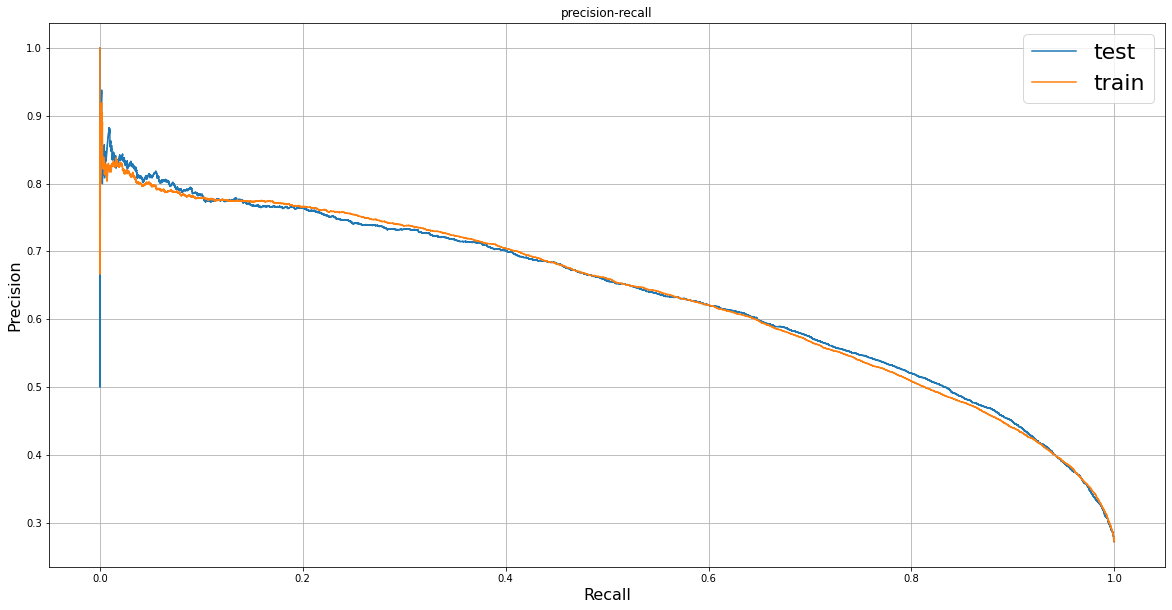

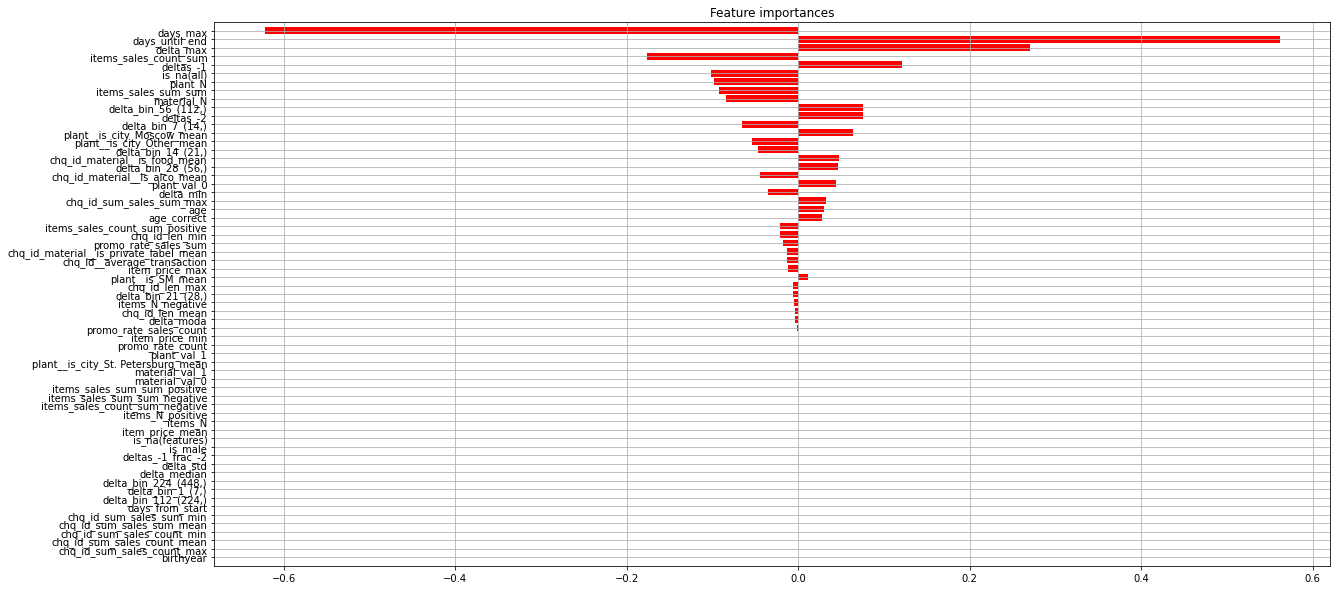

In [454]:
name = 'LR(l1, C=0.01, class_weight=balanced)'
model = make_pipeline(StandardScaler(),
                      LogisticRegression(penalty='l1',
                                         C = 0.01,
                                         class_weight = 'balanced',
                                         solver = 'liblinear'))

model.fit(X_train.to_numpy(), y_train)


p_train = model.predict_proba(X_train)[:, 1]
p_test  = model.predict_proba(X_test)[:, 1]


feature_importance = {k:v for k,v in sorted(zip(features, model.steps[1][1].coef_[0]), key = lambda x:abs(x[1]))}
global_res[name] = {'p_test':p_test,
                     'p_train':p_train,
                     'y_test':y_test,
                     'y_train':y_train,
                     'feature_importance':feature_importance
                    }

validate(p_test, p_train, y_test, y_train, feature_importance)

##### Desicion tree classifier

train
roc_auc 0.824
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     50990
           1       0.69      0.45      0.55     19010

    accuracy                           0.80     70000
   macro avg       0.75      0.69      0.71     70000
weighted avg       0.78      0.80      0.78     70000

test
roc_auc 0.824
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     21853
           1       0.68      0.45      0.54      8147

    accuracy                           0.79     30000
   macro avg       0.75      0.68      0.70     30000
weighted avg       0.78      0.79      0.78     30000



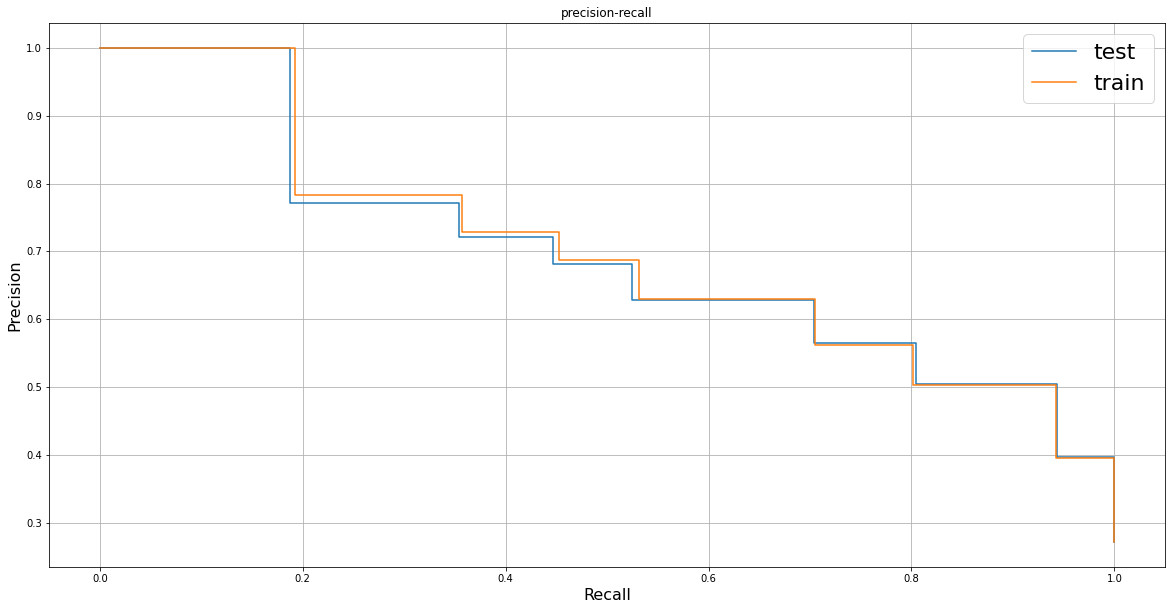

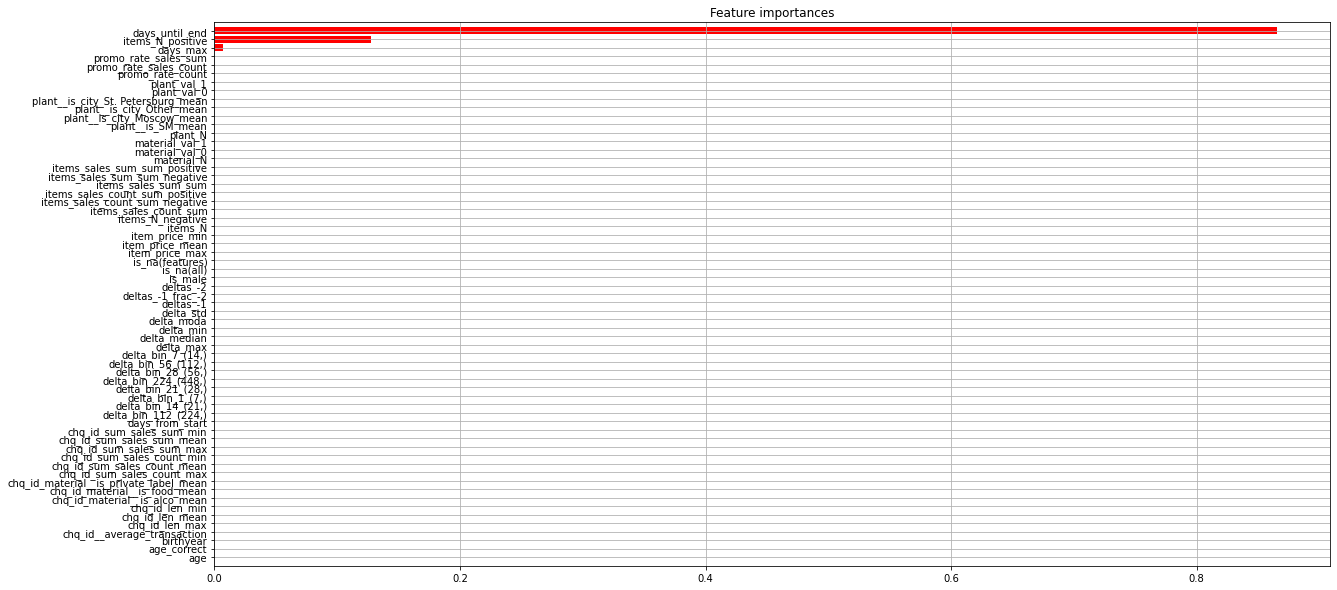

In [455]:
name = 'DecisionTree'
model = DecisionTreeClassifier(max_depth=3)

model.fit(X_train.to_numpy(), y_train)


p_train = model.predict_proba(X_train)[:, 1]
p_test  = model.predict_proba(X_test)[:, 1]

feature_importance = {k:v for k,v in sorted(zip(features, model.feature_importances_), key = lambda x:abs(x[1]))}

global_res[name] = {'p_test':p_test,
                     'p_train':p_train,
                     'y_test':y_test,
                     'y_train':y_train,
                     'feature_importance':feature_importance
                    }

validate(p_test, p_train, y_test, y_train, feature_importance)

# Визуализируем дерево

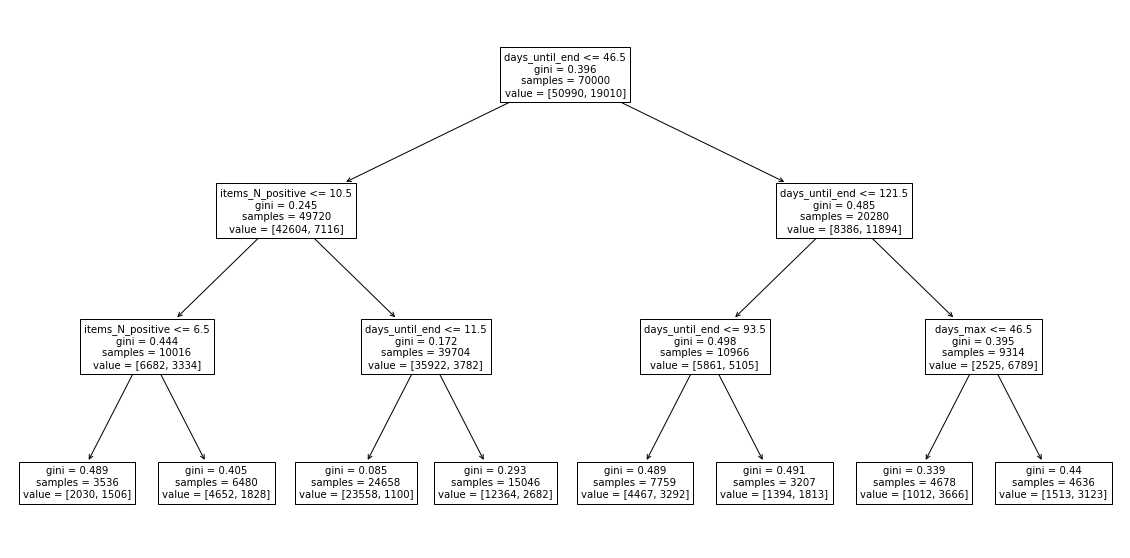

In [456]:
import graphviz 
from sklearn import tree
# dot_data = tree.export_graphviz(model, out_file='tree_depth3.dot', feature_names=features) 
plt.figure(figsize = (20, 10))
tree.plot_tree(model, feature_names = features)
plt.show()


> Видно, основной признак, это количество дней с последней покупки

#### Random Forest

train
roc_auc 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51002
           1       1.00      1.00      1.00     18998

    accuracy                           1.00     70000
   macro avg       1.00      1.00      1.00     70000
weighted avg       1.00      1.00      1.00     70000

test
roc_auc 0.842
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     21841
           1       0.67      0.50      0.57      8159

    accuracy                           0.80     30000
   macro avg       0.75      0.70      0.72     30000
weighted avg       0.79      0.80      0.79     30000



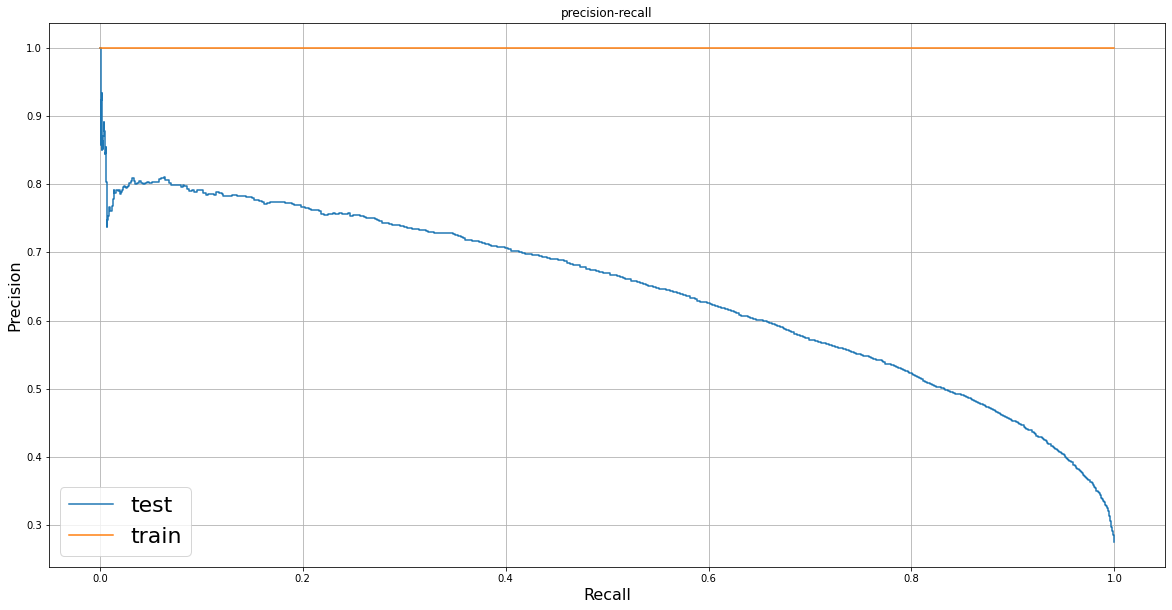

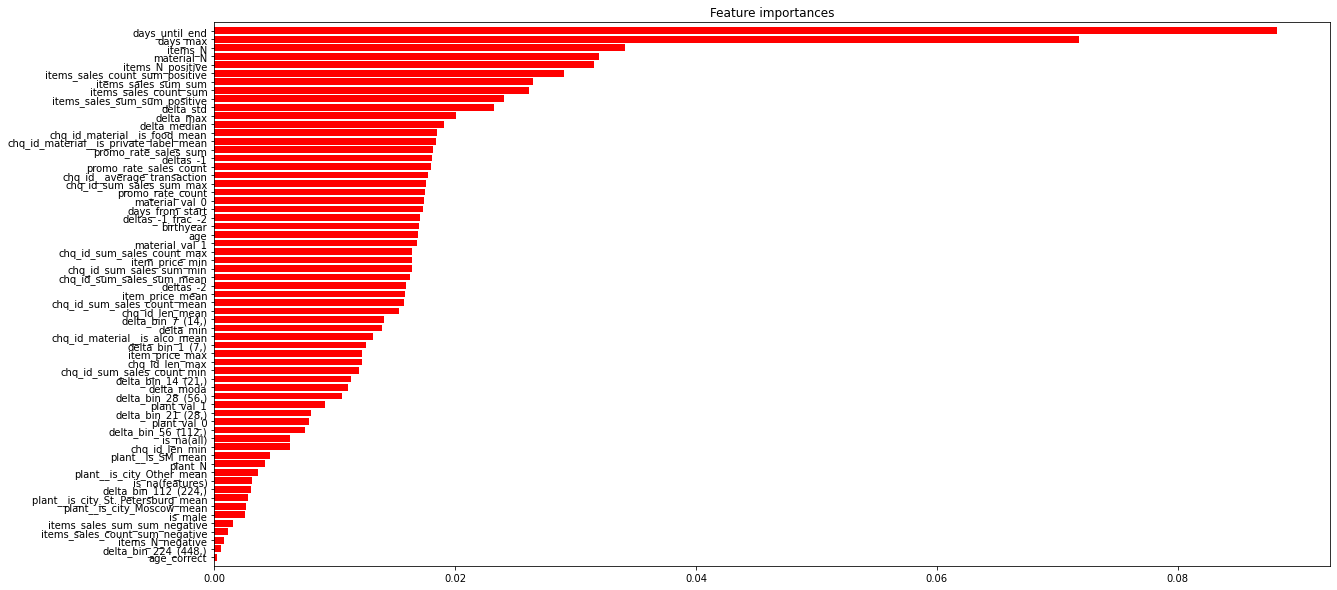

In [414]:
name = 'RF'
model = RandomForestClassifier(n_estimators=10, n_jobs = 10)

model.fit(X_train.to_numpy(), y_train)


p_train = model.predict_proba(X_train)[:, 1]
p_test  = model.predict_proba(X_test)[:, 1]

feature_importance = {k:v for k,v in sorted(zip(features, model.feature_importances_), key = lambda x:abs(x[1]))}
global_res[name] = {'p_test':p_test,
                     'p_train':p_train,
                     'y_test':y_test,
                     'y_train':y_train,
                     'feature_importance':feature_importance
                    }

validate(p_test, p_train, y_test, y_train, feature_importance)

##### Catboost classifier

Learning rate set to 0.246404
0:	test: 0.8198588	best: 0.8198588 (0)	total: 115ms	remaining: 11.4s
1:	test: 0.8318702	best: 0.8318702 (1)	total: 215ms	remaining: 10.5s
2:	test: 0.8382458	best: 0.8382458 (2)	total: 301ms	remaining: 9.73s
3:	test: 0.8390676	best: 0.8390676 (3)	total: 386ms	remaining: 9.27s
4:	test: 0.8398866	best: 0.8398866 (4)	total: 479ms	remaining: 9.11s
5:	test: 0.8417143	best: 0.8417143 (5)	total: 559ms	remaining: 8.76s
6:	test: 0.8427726	best: 0.8427726 (6)	total: 649ms	remaining: 8.62s
7:	test: 0.8442831	best: 0.8442831 (7)	total: 724ms	remaining: 8.33s
8:	test: 0.8448427	best: 0.8448427 (8)	total: 807ms	remaining: 8.16s
9:	test: 0.8450842	best: 0.8450842 (9)	total: 887ms	remaining: 7.98s
10:	test: 0.8453930	best: 0.8453930 (10)	total: 962ms	remaining: 7.78s
11:	test: 0.8456219	best: 0.8456219 (11)	total: 1.03s	remaining: 7.54s
12:	test: 0.8460261	best: 0.8460261 (12)	total: 1.11s	remaining: 7.42s
13:	test: 0.8464329	best: 0.8464329 (13)	total: 1.18s	remaining: 7.

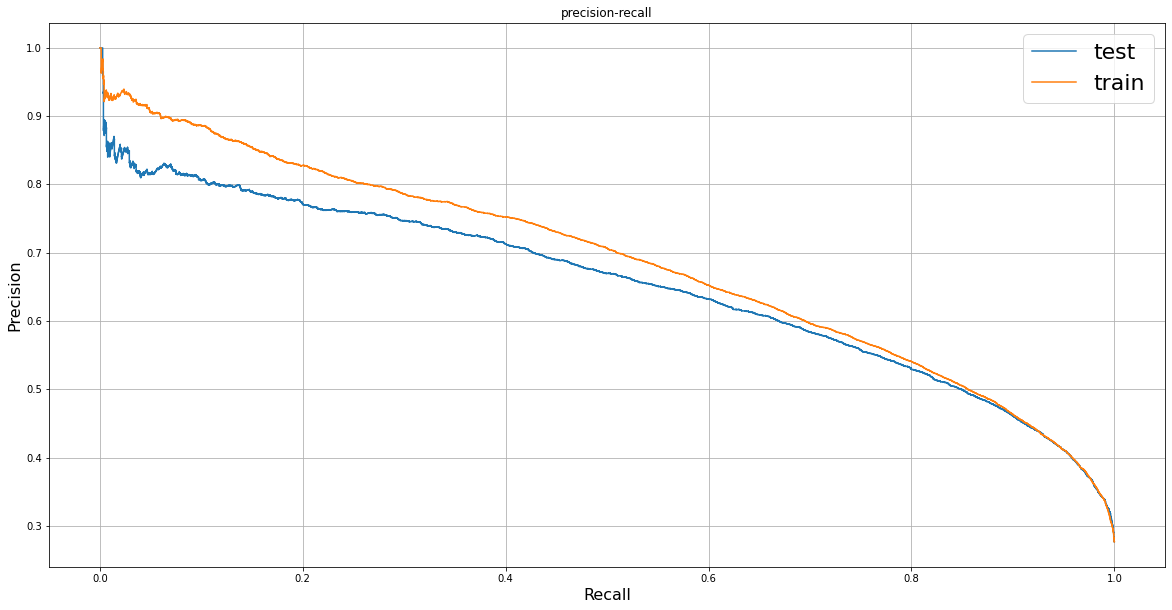

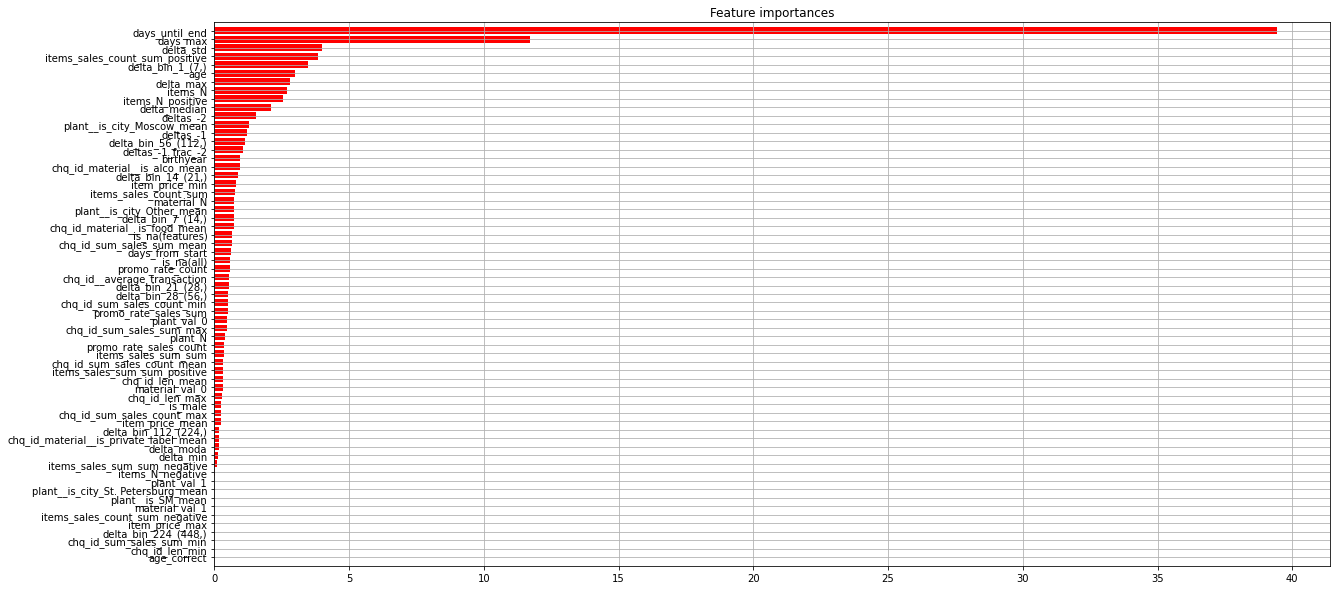

In [467]:
name = 'GB'

model = CatBoostClassifier(iterations=50)

model.fit(X_train.to_numpy(), 
          y_train)


p_train = model.predict_proba(X_train)[:, 1]
p_test  = model.predict_proba(X_test)[:, 1]

feature_importance = {k:v for k,v in sorted(zip(features, model.feature_importances_), key = lambda x:abs(x[1]))}
global_res[name] = {'p_test':p_test,
                     'p_train':p_train,
                     'y_test':y_test,
                     'y_train':y_train,
                     'feature_importance':feature_importance
                    }

validate(p_test, p_train, y_test, y_train, feature_importance)

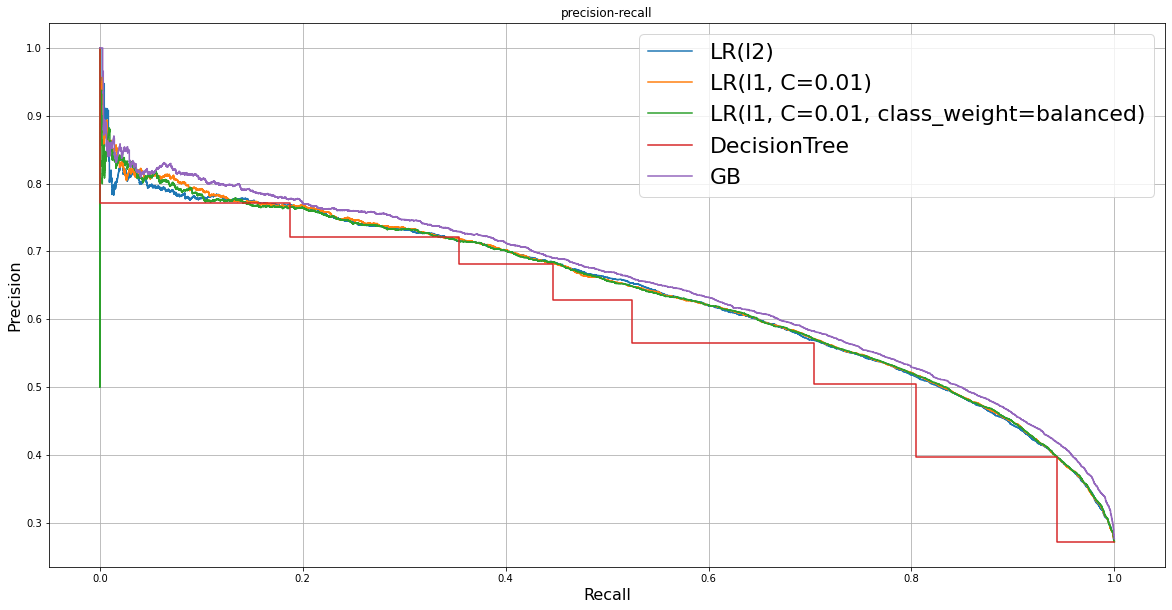

In [468]:
plt.figure(figsize = (20, 10))
plt.title('precision-recall')

for name, dct in global_res.items():
    precision, recall, thresholds = precision_recall_curve(dct['y_test'], 
                                                           dct['p_test'])
    plt.step(recall, precision, label = name, where='post')

plt.legend()
plt.xlabel('Recall', fontsize = 16)
plt.ylabel('Precision', fontsize = 16)
plt.grid()
plt.legend(fontsize = 22)
plt.show()

## Feature selection
Внимательно посмотрев на графики сверху
я выбрал следующие признаки

In [ ]:
data['plant__is_city_St. Petersburg_mean]

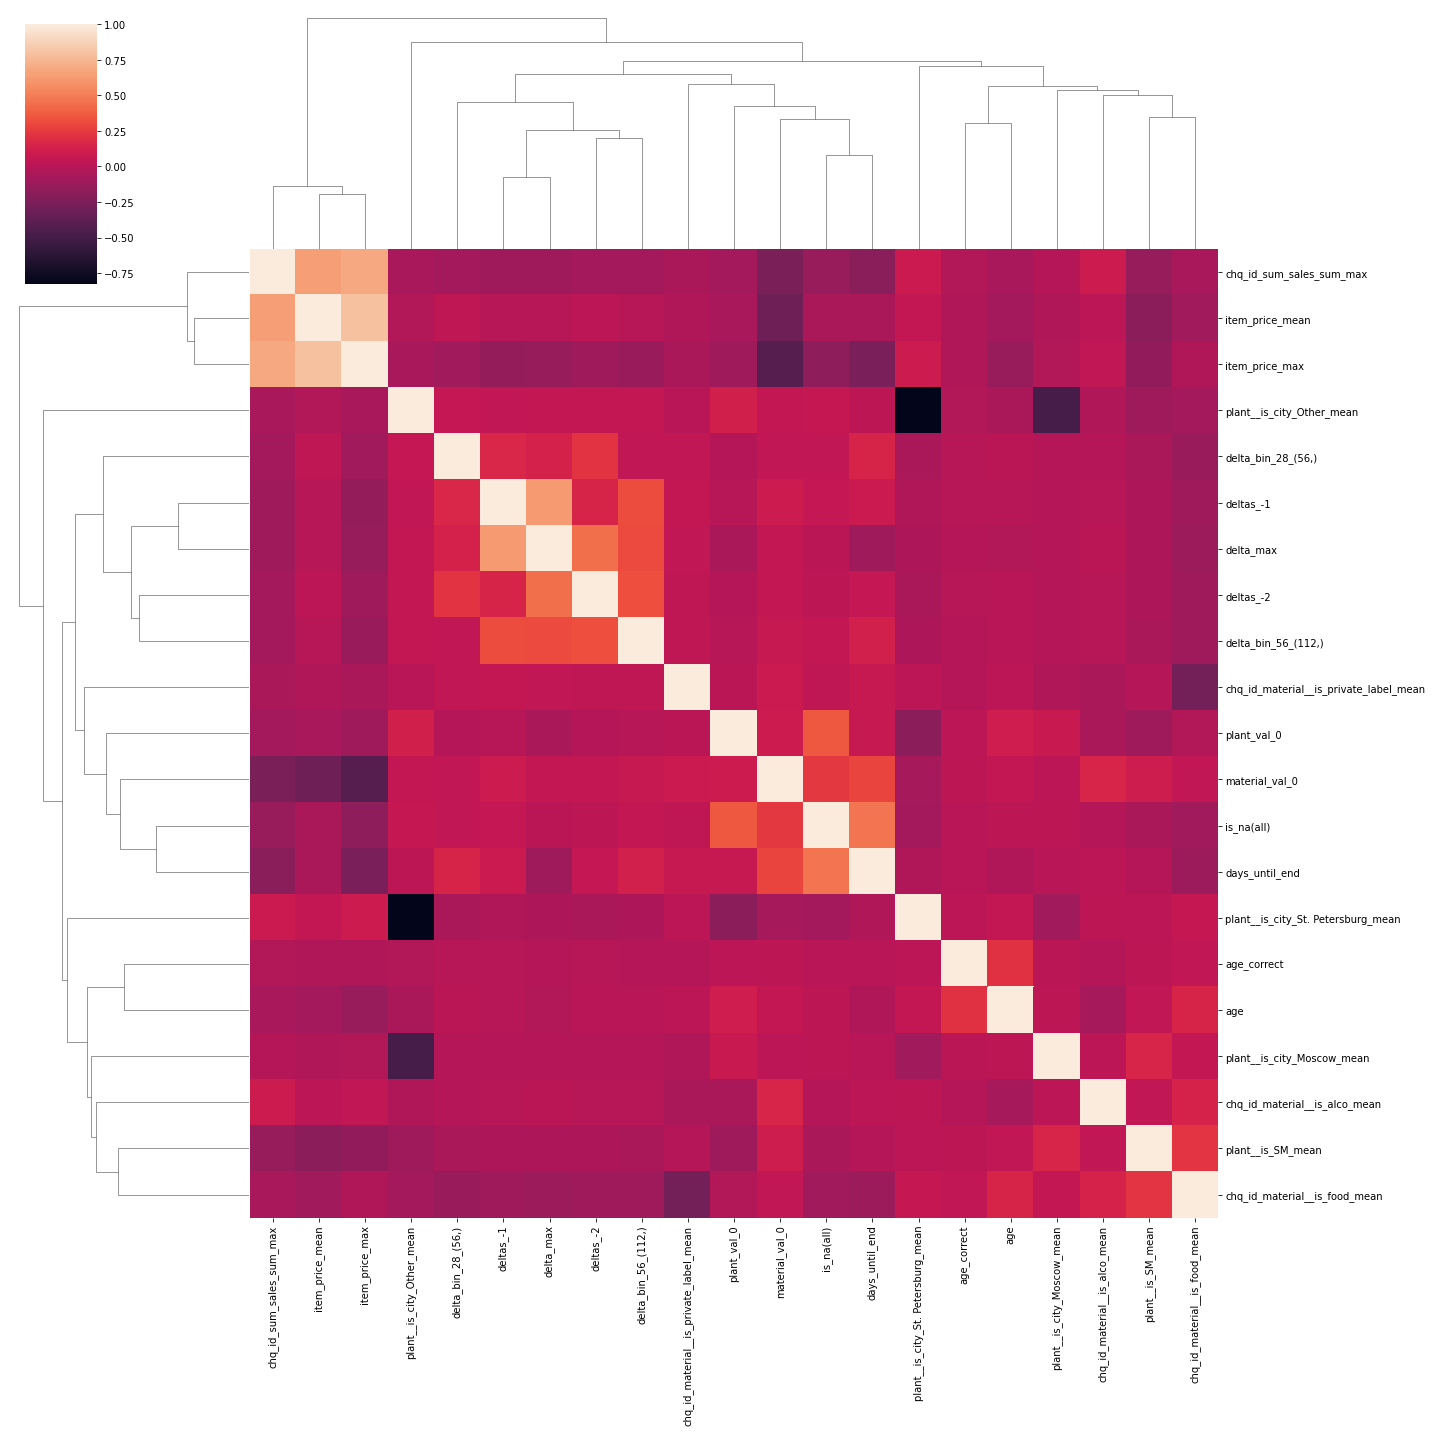

In [541]:
# data['chq_id_material'plant_val_0', 'item_price_mean', 'deltas_-1', 'items_N', 'delta_min', 'deltas_-2']#'chq_id_len_min'
features = ['plant__is_SM_mean',
            'is_na(all)',
            'plant__is_city_Moscow_mean',
            'plant__is_city_Other_mean',
            'plant__is_city_St. Petersburg_mean',
            'chq_id_material__is_food_mean',
            'chq_id_material__is_alco_mean',
            'chq_id_material__is_private_label_mean',
            'age_correct',
            'material_val_0',
            'age',
            'chq_id_sum_sales_sum_max',
            'plant_val_0',
            'delta_bin_28_(56,)',
            'item_price_mean',
            'item_price_max',
            'deltas_-2',
            'delta_bin_56_(112,)',
            'deltas_-1',
            'delta_max',
            'days_until_end'
            ]

sns.clustermap(data[features].fillna(data[features].mean()).corr(), figsize = (20, 20))
# plt.savefig('results/corr_matrix.png')
plt.show()

train
roc_auc 0.836
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     50990
           1       0.67      0.46      0.55     19010

    accuracy                           0.79     70000
   macro avg       0.75      0.69      0.71     70000
weighted avg       0.78      0.79      0.78     70000

test
roc_auc 0.837
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     21853
           1       0.67      0.46      0.55      8147

    accuracy                           0.79     30000
   macro avg       0.75      0.69      0.71     30000
weighted avg       0.78      0.79      0.78     30000



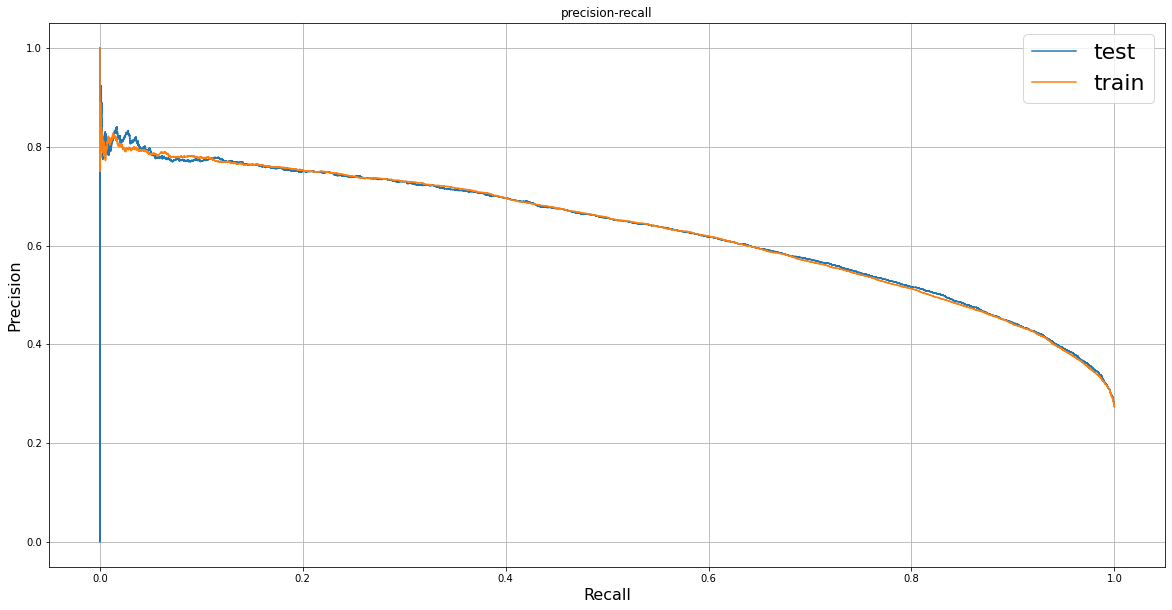

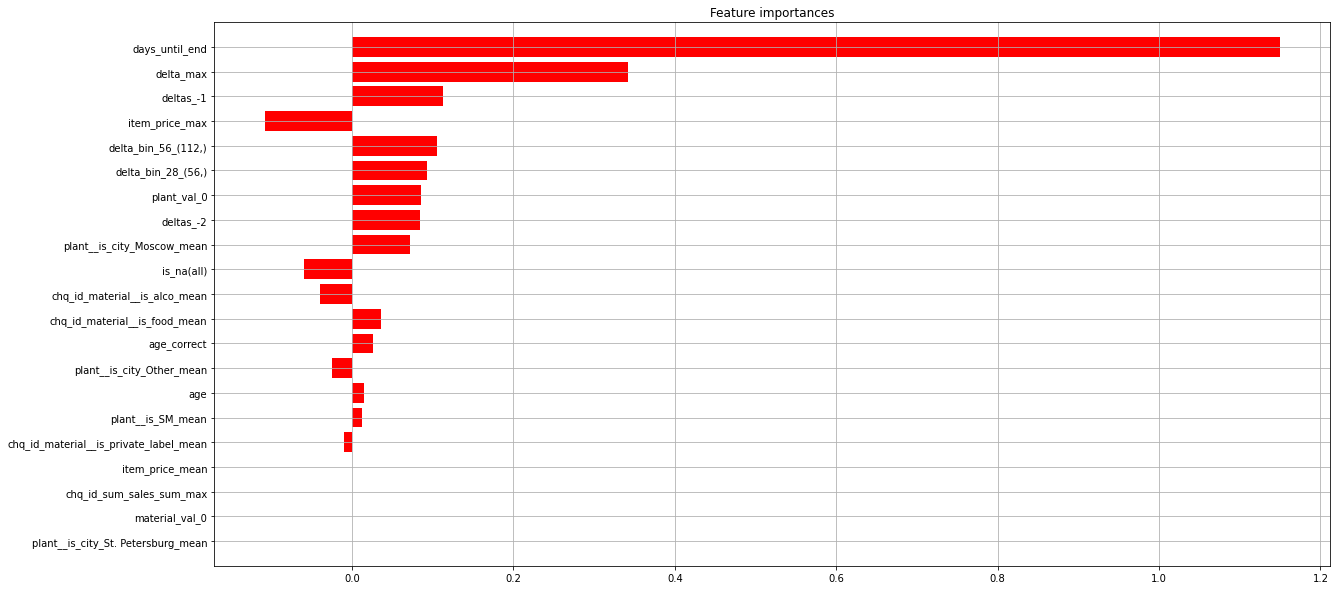

In [542]:
name = 'Feature_selected, LR(l1, C=0.01)'
model = make_pipeline(StandardScaler(),
                      LogisticRegression(penalty='l1',
                                         C = 0.01,
                                         solver = 'liblinear'))

model.fit(X_train[features].to_numpy(), y_train)


p_train = model.predict_proba(X_train[features])[:, 1]
p_test  = model.predict_proba(X_test[features])[:, 1]


feature_importance = {k:v for k,v in sorted(zip(features, model.steps[1][1].coef_[0]), key = lambda x:abs(x[1]))}
global_res[name] = {'p_test':p_test,
                     'p_train':p_train,
                     'y_test':y_test,
                     'y_train':y_train,
                     'feature_importance':feature_importance
                    }

validate(p_test, p_train, y_test, y_train, feature_importance)

Learning rate set to 0.5
0:	learn: 0.4953053	total: 118ms	remaining: 5.76s
1:	learn: 0.4481178	total: 226ms	remaining: 5.42s
2:	learn: 0.4346564	total: 344ms	remaining: 5.38s
3:	learn: 0.4286053	total: 454ms	remaining: 5.22s
4:	learn: 0.4253137	total: 560ms	remaining: 5.04s
5:	learn: 0.4239700	total: 662ms	remaining: 4.86s
6:	learn: 0.4229568	total: 763ms	remaining: 4.69s
7:	learn: 0.4214006	total: 867ms	remaining: 4.55s
8:	learn: 0.4209059	total: 972ms	remaining: 4.43s
9:	learn: 0.4203180	total: 1.07s	remaining: 4.27s
10:	learn: 0.4197728	total: 1.18s	remaining: 4.18s
11:	learn: 0.4193626	total: 1.27s	remaining: 4.02s
12:	learn: 0.4187743	total: 1.37s	remaining: 3.9s
13:	learn: 0.4180175	total: 1.48s	remaining: 3.82s
14:	learn: 0.4174716	total: 1.6s	remaining: 3.73s
15:	learn: 0.4165218	total: 1.7s	remaining: 3.61s
16:	learn: 0.4159540	total: 1.8s	remaining: 3.5s
17:	learn: 0.4156591	total: 1.91s	remaining: 3.4s
18:	learn: 0.4153187	total: 2.02s	remaining: 3.3s
19:	learn: 0.4148494	to

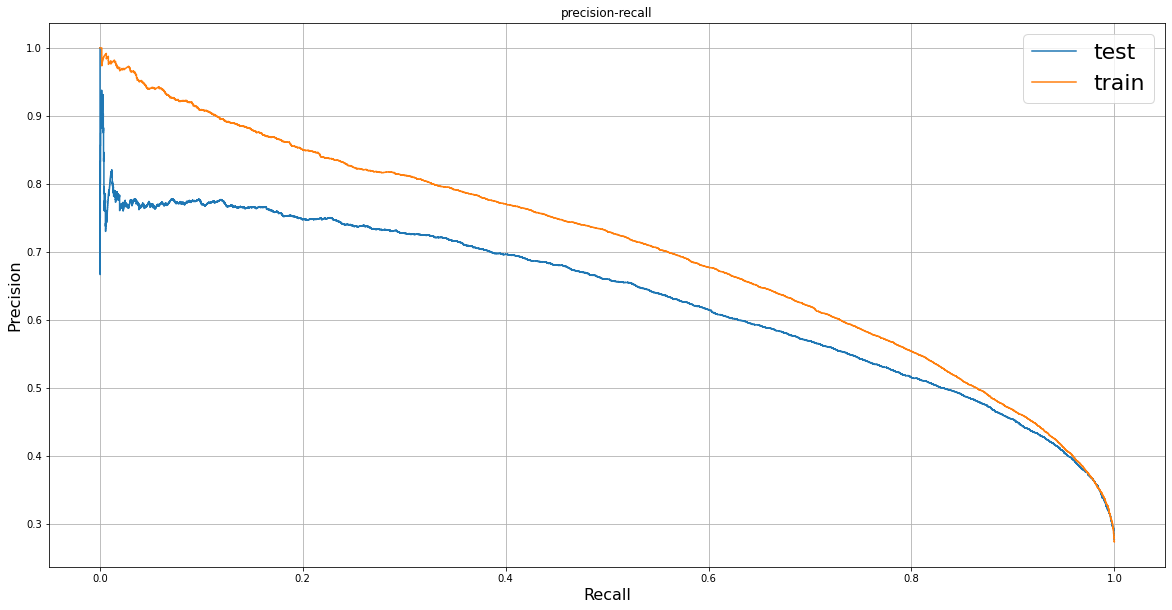

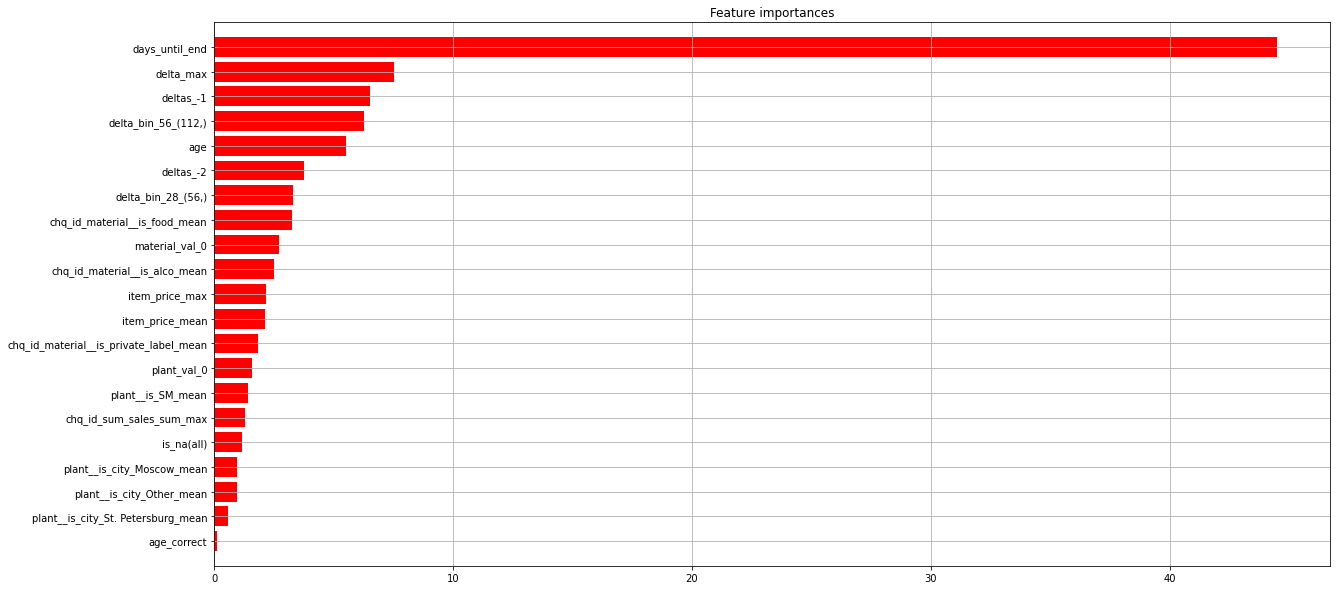

In [543]:
name = 'Feature_selected, GB'

model = CatBoostClassifier(iterations=50)#max_depth=5, n_estimators=100, class_weight='balanced')

model.fit(X_train[features].to_numpy(), 
          y_train)


p_train = model.predict_proba(X_train[features])[:, 1]
p_test  = model.predict_proba(X_test[features])[:, 1]

feature_importance = {k:v for k,v in sorted(zip(features, model.feature_importances_), key = lambda x:abs(x[1]))}
global_res[name] = {'p_test':p_test,
                     'p_train':p_train,
                     'y_test':y_test,
                     'y_train':y_train,
                     'feature_importance':feature_importance
                    }

validate(p_test, p_train, y_test, y_train, feature_importance)

train
roc_auc 0.823
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     50990
           1       0.70      0.40      0.51     19010

    accuracy                           0.79     70000
   macro avg       0.76      0.67      0.69     70000
weighted avg       0.78      0.79      0.77     70000

test
roc_auc 0.826
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     21853
           1       0.70      0.40      0.51      8147

    accuracy                           0.79     30000
   macro avg       0.75      0.67      0.69     30000
weighted avg       0.78      0.79      0.77     30000



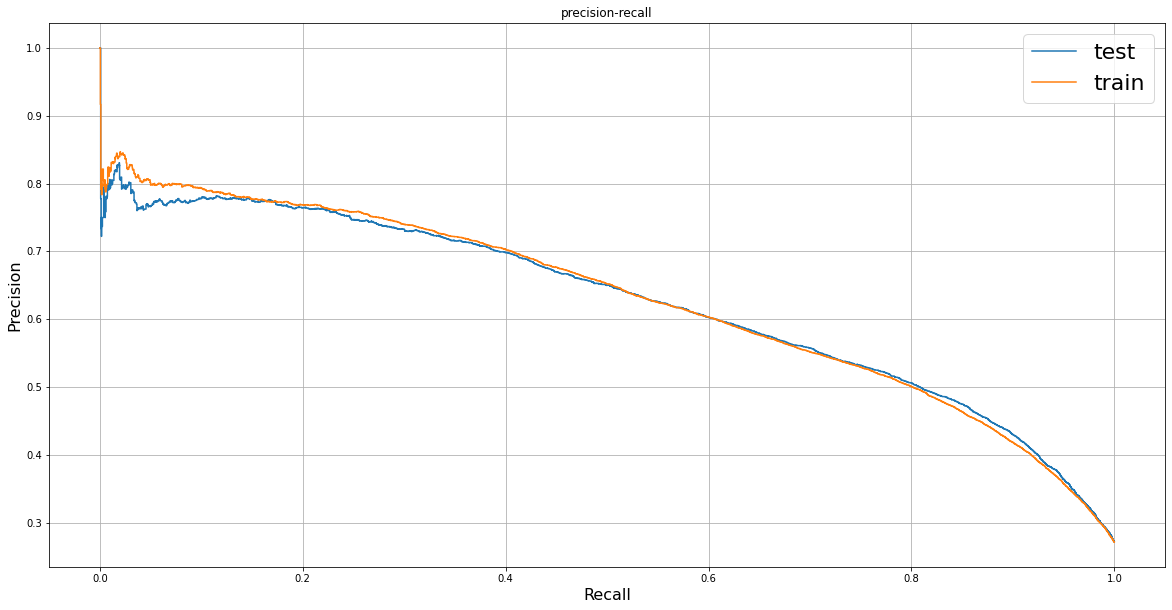

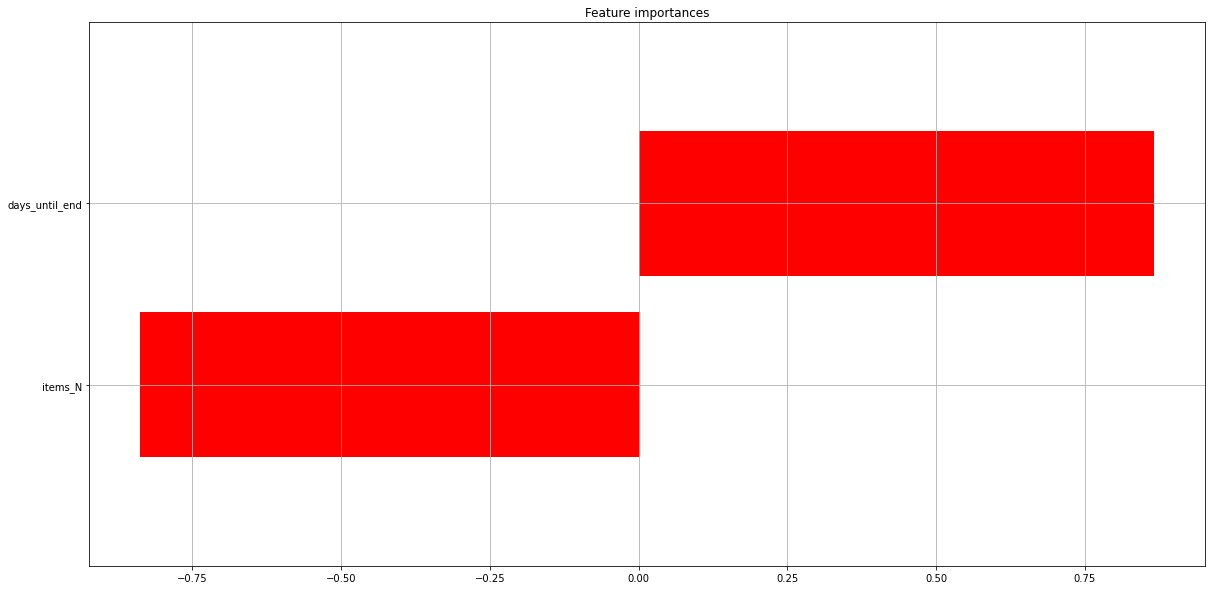

In [544]:
features = ['days_until_end', 'items_N']
name = '2 features LogReg'
model = make_pipeline(StandardScaler(),
                      LogisticRegression(penalty='l2'))

model.fit(X_train[features].to_numpy(), y_train)


p_train = model.predict_proba(X_train[features])[:, 1]
p_test  = model.predict_proba(X_test[features])[:, 1]


feature_importance = {k:v for k,v in sorted(zip(features, model.steps[1][1].coef_[0]), key = lambda x:abs(x[1]))}
global_res[name] = {'p_test':p_test,
                     'p_train':p_train,
                     'y_test':y_test,
                     'y_train':y_train,
                     'feature_importance':feature_importance
                    }

validate(p_test, p_train, y_test, y_train, feature_importance)

train
roc_auc 0.818
              precision    recall  f1-score   support

           0       0.80      0.94      0.87     50990
           1       0.72      0.38      0.50     19010

    accuracy                           0.79     70000
   macro avg       0.76      0.66      0.68     70000
weighted avg       0.78      0.79      0.77     70000

test
roc_auc 0.820
              precision    recall  f1-score   support

           0       0.80      0.94      0.87     21853
           1       0.71      0.37      0.49      8147

    accuracy                           0.79     30000
   macro avg       0.76      0.66      0.68     30000
weighted avg       0.78      0.79      0.76     30000



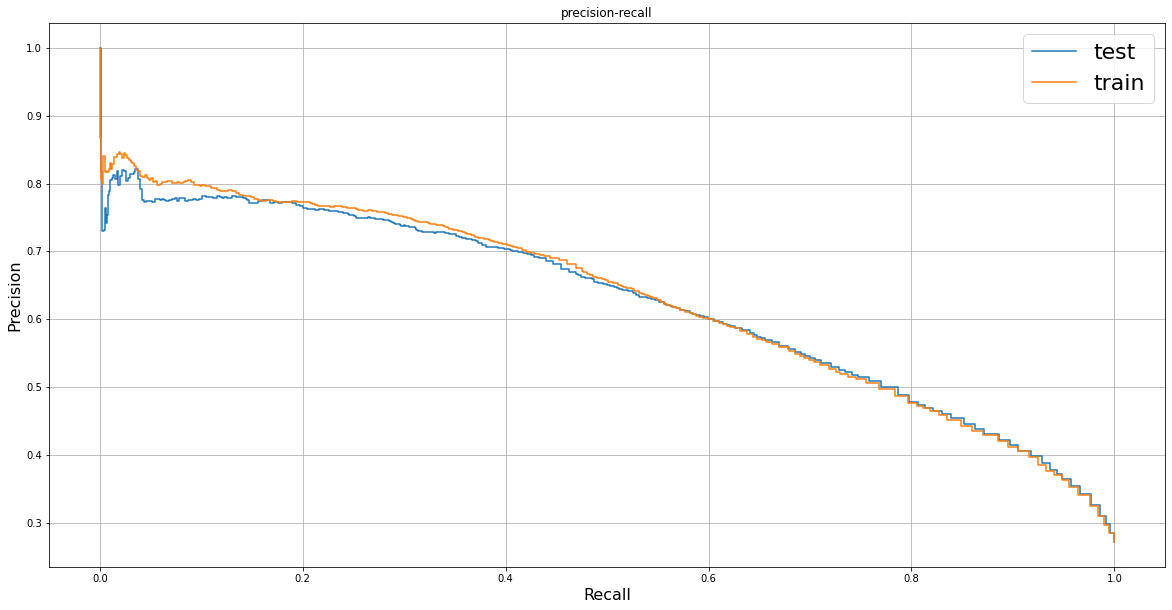

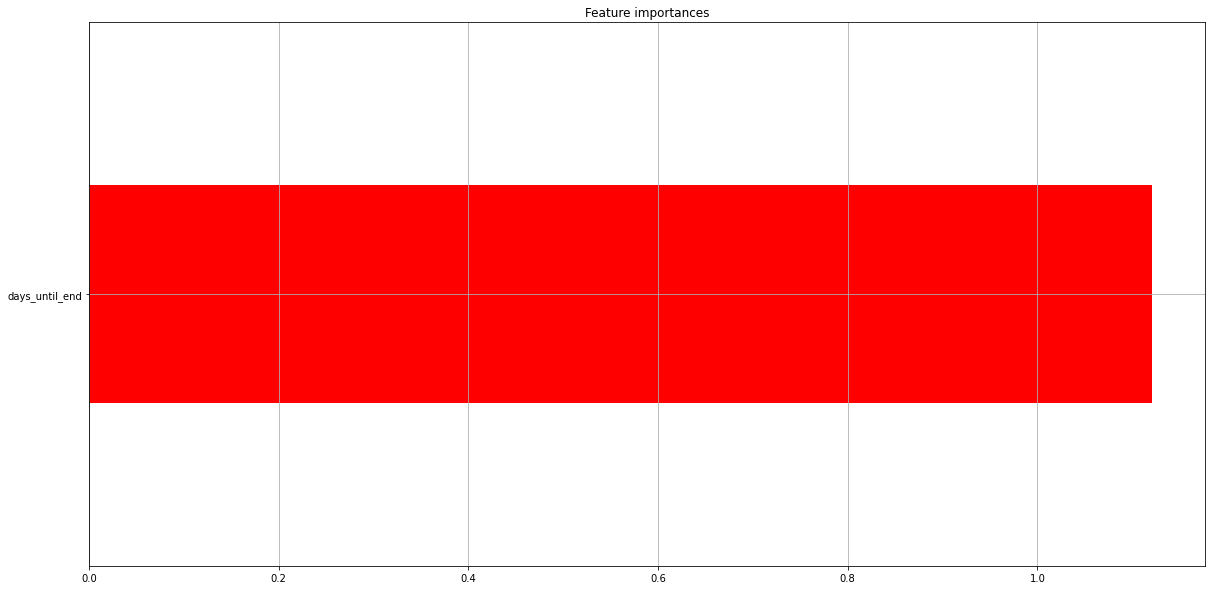

Живе Беларусь


In [574]:
features = ['days_until_end']
name = '2 features LogReg'
model = make_pipeline(StandardScaler(),
                      LogisticRegression(penalty='l2'))

model.fit(X_train[features].to_numpy(), y_train)


p_train = model.predict_proba(X_train[features])[:, 1]
p_test  = model.predict_proba(X_test[features])[:, 1]


feature_importance = {k:v for k,v in sorted(zip(features, model.steps[1][1].coef_[0]), key = lambda x:abs(x[1]))}
global_res[name] = {'p_test':p_test,
                     'p_train':p_train,
                     'y_test':y_test,
                     'y_train':y_train,
                     'feature_importance':feature_importance
                    }

validate(p_test, p_train, y_test, y_train, feature_importance)
print("Живе Беларусь")

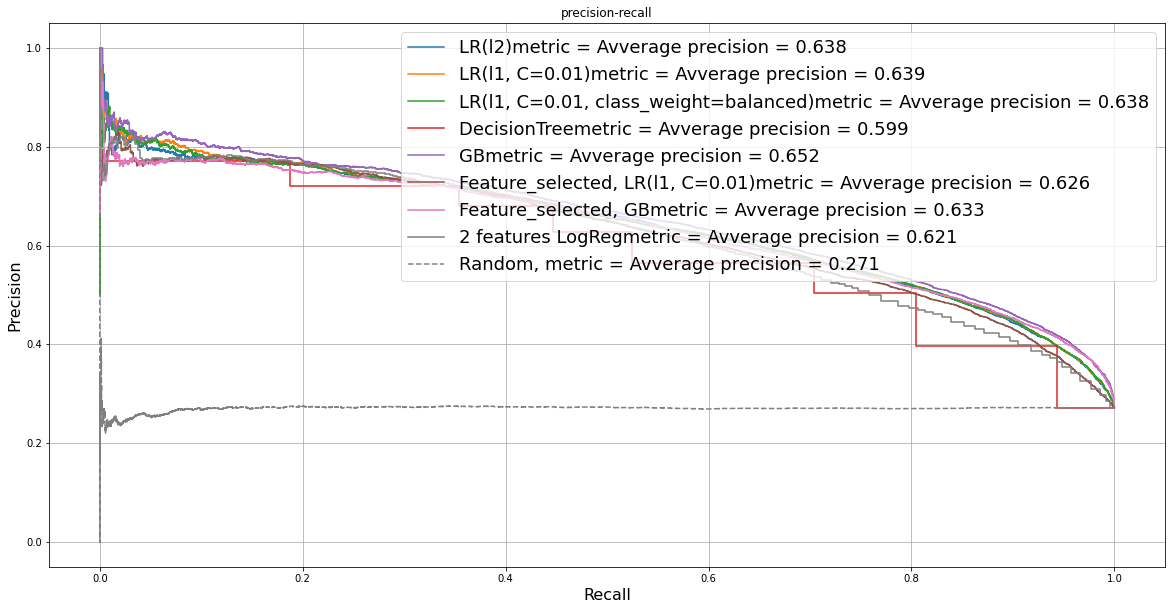

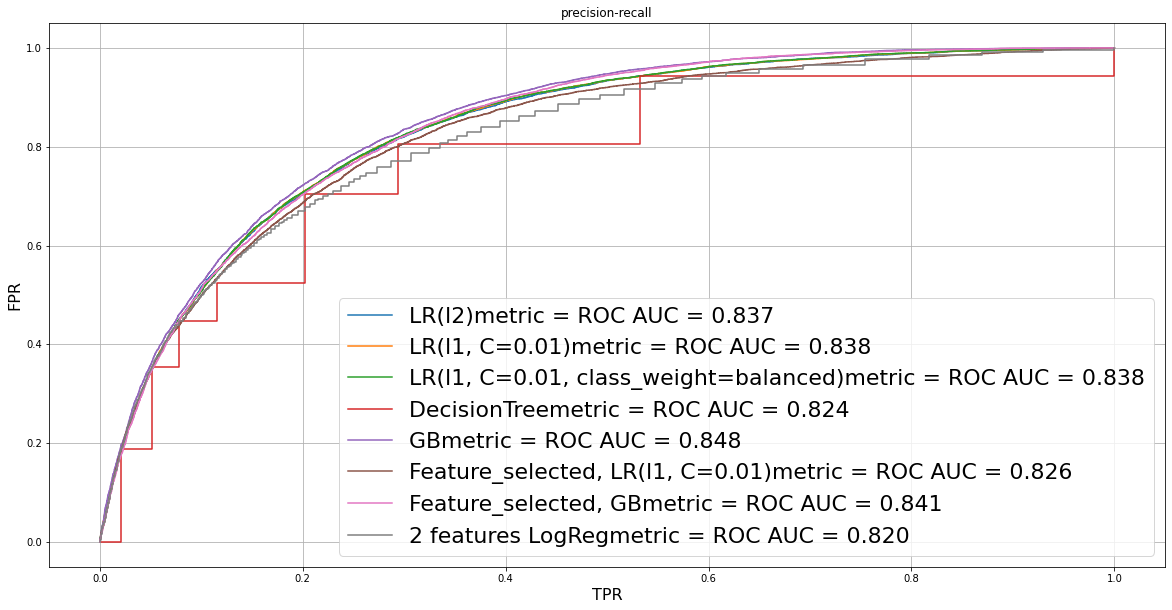

In [508]:
from sklearn.metrics import average_precision_score
plt.figure(figsize = (20, 10))
plt.title('precision-recall')

for name, dct in global_res.items():
    precision, recall, thresholds = precision_recall_curve(dct['y_test'], 
                                                           dct['p_test'])
    plt.step(recall, precision, 
             label = name+'metric = Avverage precision = %2.3f'%average_precision_score(dct['y_test'], 
                                                                             dct['p_test']), 
             where='post')

#Random
_y = global_res['LR(l1, C=0.01, class_weight=balanced)']['y_test']
_p = global_res['LR(l1, C=0.01, class_weight=balanced)']['p_test'][::-1]
precision, recall, thresholds = precision_recall_curve(_y, 
                                                       _p)
plt.step(recall, precision, linestyle='--', color = 'grey',
          label = 'Random, metric = Avverage precision = %2.3f'%average_precision_score(_y,  _p) ,
          where='post')
plt.legend()
plt.xlabel('Recall', fontsize = 16)
plt.ylabel('Precision', fontsize = 16)
plt.grid()
plt.legend(fontsize = 18, loc = 'upper right')
plt.show()

from sklearn.metrics import roc_auc_score, roc_curve
plt.figure(figsize = (20, 10))
plt.title('precision-recall')

for name, dct in global_res.items():
    fpr, tpr, thresholds = roc_curve(dct['y_test'], 
                                     dct['p_test'])
    plt.step(fpr, tpr, 
             label = name+'metric = ROC AUC = %2.3f'%roc_auc_score(dct['y_test'], 
                                                                             dct['p_test']), 
             where='post')

plt.legend()
plt.xlabel('TPR', fontsize = 16)
plt.ylabel('FPR', fontsize = 16)
plt.grid()
plt.legend(fontsize = 22)
plt.show()

## Выводы:

- Предсказывая половину churn-a, мы ошибаемся в 3-4 случаях их 10-ти 
- ROC AUC ~ 0.84 (что неплохо для задачи ранжирования)
- Метрика худшей/лучшей модели практически не отличается
- Если построить модель на одном признаке метрики на 2-10% хуже лучшей модели

  С текущими метриками, эту модель можно заменить несколькими if-ми :(
  
## Почему так получилось?
- Модель была оценена адекватно и беспристрастно.
  (схема валидации, выбор отсечек для определения y, подсчет переменных были выполнены корректно)
  
- Возможно причина в данных, и единственное что мы можем сказать про пользователя:

    1. Если пользователя у нас давно не было, то возможно он уже churn (самая значащий признак всегда days_until_end)
    2. Если он ходил к нам часто, то скорее всего он еще придет. (второй самый значащий несвязанный с первым признак это количество походов в магазин - items_N)
    
  Двух этих признаков, хватит, чтобы написать модель в два if-а, соперничующую со сложной моделью
  Как это не грустно, но чаще-всего люди ходят в ближайший магазин, а их мало
  
- И третья причина - неправильный выбор признаков


## Можно ли сделать лучше?

- Не понятно. Нужно решать эту задачу дальше, в первую очередь генерить новые признаки и смотреть на сколько они хорошо подходят.

- Скорее всего методолию следуюет немного поменять:

    1) Брать две отсечки t1,t2, чтобы признаки по типу days_until_end меньше влияли на задачу.
       Брать отсечку t1=t_start - было неправильным решением, но сначало это было неочевидно
    2) Понимать в каких конкретно процессах мы будем использовать результат модели, чтобы выбрать оптимальную метрику. Самый вероятное использование, это программа лояльности или взаимодействие с пользователем. При таком случае самой простой метрикой является precision(recall=T) или TPR(FPR = T) 
    3) Усложнить схему валидации и померить ее зависимость по времени

### Не реализованные хорошие идеи для признаков
- Кодирование магазина. Наверное есть магазины с конкурентами и без, это важно. В текущем решении это не учитывается
  (388 магазинов на 100000 клиентов, скорее всего плохо закодируются one-hot, лучше использовать счетчики)
  
- Выделить признаки характеризующие регулярность походов в магазин
  (раз в X дней есть счет более чем на Y руб)


No handles with labels found to put in legend.


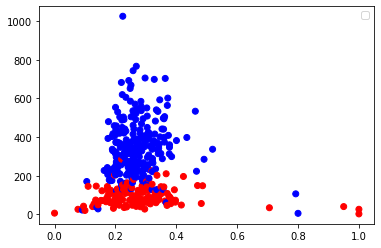

N         M  plant_type
plant_key_0                                                  
73a0dc181f83bed264af81ad8fafcf89    6.0  0.000000        True
ffe49cdf45d56b04b8542e6abc4f5fb6   26.0  0.076923        True
54df5e38455d75e5c0e2c55f40f825fa   22.0  0.090909       False
b7531d70dbb017fd3a72eeca4b4e91f6   42.0  0.095238        True
d00f3f3d151a0c4c195f1e05870fbd19   20.0  0.100000        True
...                                 ...       ...         ...
b0f07fe0f7de991bfca0de50391eb328  106.0  0.792453       False
5f55a6ece505a982f1ea0f396442bf23    5.0  0.800000       False
fa6fd762eab57575a037d306299c6452   40.0  0.950000        True
301bd17344eb5f9bc51f15c6cb91ae5b    2.0  1.000000        True
8e811a108a578f67e0024f7980d07434   26.0  1.000000        True

[385 rows x 3 columns]

In [573]:
# Кодирование магазина должнно хорошо сработать
# Кодирование магазина
def foo(o):
    return pd.Series({'N':len(o), 'M':o['y'].mean()})
o = data.groupby('plant_key_0')[['y','plant__is_SM_mean']].apply(foo).sort_values('M')

o = o.join((df_plants.set_index('plant')['plant_type']=='SM'))
plt.scatter(o['M'].to_numpy(), o['N'].to_numpy(), color = o['plant_type'].apply(lambda x:'red' if x else 'blue'))
plt.legend()
plt.show()
o